In [1]:
import mplfinance as mpf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
import pandas as pd
import numpy as np
import requests
import io
import os
import datetime
from concurrent.futures import ThreadPoolExecutor
import json
import urllib.request
import pandas as pd
import ccxt
import os
import gc
# from backtest_module import *

2023-04-30 23:00:44.137788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-30 23:00:44.137850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-30 23:00:44.309321: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-30 23:00:55.111384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-30 23:00:55.112262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
import json
from backtest_module import *
from lightfn_module import *

back test module is loaded !


## Controle Space

In [3]:
# ai_options
Normalization_File= "False"
Model_FileName= "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5"
WINDOW_SIZE= 7
PRESSISION=0.0
PERIODE_START="2023-02-09 00:00:00"
PERIODE_END="2023-02-11 00:00:00"

# start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
# end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')
start_period = pd.Timestamp(PERIODE_START)
end_period = pd.Timestamp(PERIODE_END)


#trading_options:
TAKE_PROFIT= 0.4  
STOP_LOSS=  0.8 
MAX_HOLDING_TIME= 16
PRECISION = 0.0

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
  

## Data space

In [4]:
#################### Files #################

DATABASE_DIR="./database"
INFO_DIR=f"{DATABASE_DIR}/Info"
ALL_BINANCE_TICKERS_LISTFILE=f"{INFO_DIR}/ALL_BINANCE_TICKERS_LISTFILE.json"
ONLY_MY_HALAL_LIST_FILE=f"{INFO_DIR}/ONLY_MY_HALAL_LIST.json"
halal_list_file_path=f"{INFO_DIR}/halal-crypto-list.txt"
BINANCE_KLINES_DATA_DIR=f"{DATABASE_DIR}/OpenBinance/KLINES"
BINANCE_TRADES_DATA_DIR=f"{DATABASE_DIR}/OpenBinance/Trades"
METADATA_FILE=f"{INFO_DIR}/METADATA.csv"
COINGEKO_INFO_FILE=f"{INFO_DIR}/COINGEKO_INFO_FILE.csv"
########### data info ################


In [5]:
def get_all_binance_tickers():
    """Return a list of all binance tickers from a local file or an API call."""
    try:
        with open(ALL_BINANCE_TICKERS_LISTFILE, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        url = 'https://api.binance.com/api/v3/ticker/price'
        response = requests.get(url)
        tickers = response.json()
        ticker_list = [ticker['symbol'] for ticker in tickers]
        with open(ALL_BINANCE_TICKERS_LISTFILE, "w") as f:
            json.dump(ticker_list, f)
        return ticker_list
ALL_BINANCE_TICKERS=get_all_binance_tickers()

def get_my_halal_list(halal_file=halal_list_file_path,ticker_list = ALL_BINANCE_TICKERS):
    
    try:
        with open(ONLY_MY_HALAL_LIST_FILE, "r") as f:
            json.dump(MY_HALA_DIC, f)
        
        VOLATILE_USDT_PAIRS=MY_HALA_DIC["USDT_PAIRS"]
        VOLATILE_BUSD_PAIRS=MY_HALA_DIC["BUSD_PAIRS"]
    except:
    
        ticker_list = ALL_BINANCE_TICKERS
        
        with open(halal_file, "r") as f:
            VOLATILE_COINS = [line.strip() for line in f.readlines()]
        
        VOLATILE_USDT_PAIRS = [f"{coin}/USDT" for coin in VOLATILE_COINS]
        VOLATILE_BUSD_PAIRS = [f"{coin}/BUSD" for coin in VOLATILE_COINS]
        
        # Remove BUSD pairs not listed in Binance
        VOLATILE_BUSD_PAIRS = [pair for pair in VOLATILE_BUSD_PAIRS if pair.replace('/', '') in ticker_list]
        
        # Remove USDT pairs not listed in Binance
        VOLATILE_USDT_PAIRS = [pair for pair in VOLATILE_USDT_PAIRS if pair.replace('/', '') in ticker_list]
        
        # # Remove USDT pairs that don't have 1m data
        # content = os.listdir('database/DataBackTest/1m')
        # VOLATILE_USDT_PAIRS = [pair for pair in VOLATILE_USDT_PAIRS if f"{pair.replace('/', '-')}.csv" in content]
        
        # # Remove BUSD pairs that don't have 1m data
        # VOLATILE_BUSD_PAIRS = [pair for pair in VOLATILE_BUSD_PAIRS if f"{pair.replace('/', '-')}.csv" in content]
    MY_HALA_DIC={"WORKING_PAIRS":VOLATILE_USDT_PAIRS+VOLATILE_BUSD_PAIRS,"VOLATILE_USDT_PAIRS":VOLATILE_USDT_PAIRS,"VOLATILE_BUSD_PAIRS":VOLATILE_BUSD_PAIRS}
    with open(ONLY_MY_HALAL_LIST_FILE, "w") as f:
        json.dump(MY_HALA_DIC, f)
    return VOLATILE_USDT_PAIRS + VOLATILE_BUSD_PAIRS , VOLATILE_USDT_PAIRS ,VOLATILE_BUSD_PAIRS




ALL_USDT_BUSD_PAIRS=extract_pairs(ALL_BINANCE_TICKERS)
WORKING_PAIRS,VOLATILE_USDT_PAIRS ,VOLATILE_BUSD_PAIRS=get_my_halal_list(halal_file=halal_list_file_path)
MY_HALA_DIC=get_my_halal_list(halal_file=halal_list_file_path)
ALL_CIBLED_COINS = list(set([symbol.split('/')[0].lower() for symbol in ALL_USDT_BUSD_PAIRS] ))


In [6]:

def read_metadata(pairs):
    if not os.path.exists(DATABASE_DIR):
        os.makedirs(DATABASE_DIR)
    try:
        MetaData = pd.read_csv(METADATA_FILE,index_col=0)
        pairs_in_csv = set(MetaData['Pair'].tolist())
        pairs_to_get_metadata = list(set(pairs) - pairs_in_csv)
        if pairs_to_get_metadata:
            new_metadata = get_crypto_metadata(pairs_to_get_metadata)
            MetaData = pd.concat([MetaData, new_metadata], ignore_index=True)
            MetaData.to_csv(METADATA_FILE, index=False)
        return MetaData
    except:
        MetaData = get_crypto_metadata(pairs)
        MetaData.to_csv(METADATA_FILE, index=False)
        return MetaData
MetaData=read_metadata(WORKING_PAIRS)
MetaData

Pair  launch_week_stamp  launch_day_stamp  \
0                                                            
LTCUSDT      LTC/USDT      1512950400000     1513123200000   
ARUSDT        AR/USDT      1620604800000     1620950400000   
OPUSDT        OP/USDT      1653868800000     1654041600000   
TRIBEUSDT  TRIBE/USDT      1629676800000     1629763200000   
TVKUSDT      TVK/USDT      1627862400000     1628208000000   
...               ...                ...               ...   
PYRBUSD      PYR/BUSD      1637539200000     1637884800000   
GALBUSD      GAL/BUSD      1651449600000     1651708800000   
SRMBUSD      SRM/BUSD      1597017600000     1597104000000   
FIROBUSD    FIRO/BUSD      1655078400000     1655424000000   
SNMBUSD      SNM/BUSD      1661126400000     1661472000000   

                 launch_minute  
0                               
LTCUSDT    2017-12-13 03:32:00  
ARUSDT     2021-05-14 12:00:00  
OPUSDT     2022-06-01 08:00:00  
TRIBEUSDT  2021-08-24 06:00:00  
TVKUSDT    2021-08-06 10:00:00  
...                        ...  
PYRBUSD    2021-11-26 08:00:00  
GALBUSD    2022-05-05 12:00:00  
SRMBUSD    2020-08-11 13:30:00  
FIROBUSD   2022-06-17 10:00:00  
SNMBUSD    2022-08-26 08:00:00  

[227 rows x 4 columns]

In [7]:
from lightfn_module import *
def get_backtest_historical(exchange, symbol, timeframe, path="database/"):
    symbol = symbol.replace('/','-')
    df = pd.read_csv(filepath_or_buffer=path+"DataBackTest"+"/"+timeframe+"/"+symbol+".csv")
    df = df.set_index(df['date'])
    df.index = pd.to_datetime(df.index, unit='ms')
    del df['date']
    return df


In [8]:
import gc
from collections import defaultdict
from functools import partial
import ccxt

def get_historical_dataframes(working_pairs, oldest_pair="BTC/USDT", timeframes=("1m", "1d", "1h", "5m", "15m"), path="./database/"):
    if oldest_pair not in working_pairs:
        working_pairs.append(oldest_pair)
    
    error_list = []
    dataframes = defaultdict(dict)

    binance = ccxt.binance()
    get_backtest_historical_partial = partial(get_backtest_historical, binance, path=path)

    for pair in working_pairs:
        for tf in timeframes:
            try:
                df = get_backtest_historical_partial(pair, tf)
                dataframes[tf][pair] = df.loc[:]
                del(df)
            except Exception as e:
                print(f" error on {pair} : {e} ")
                error_list.append(pair)
                break

    gc.collect()
    print("Data load 100% use dataframes['1d']['BTC/USDT'] for example to access")
    return dataframes, error_list



In [9]:
WORKING_PAIRS=VOLATILE_USDT_PAIRS
dataframes, error_list = get_historical_dataframes(WORKING_PAIRS)


 error on UST/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/UST-USDT.csv' 
 error on BTG/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/BTG-USDT.csv' 
 error on EPS/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/EPS-USDT.csv' 
 error on DNT/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/DNT-USDT.csv' 
Data load 100% use dataframes['1d']['BTC/USDT'] for example to access


In [10]:
df_list1m = dataframes["1m"]
df_list1d = dataframes["1d"]
df_list1h = dataframes["1h"]
df_list5m = dataframes["5m"]
df_list15m = dataframes["15m"]


In [11]:
for ERROR_p in error_list: 
    if ERROR_p in WORKING_PAIRS:  WORKING_PAIRS.remove(ERROR_p)

In [12]:
# pair_list = WORKING_PAIRS
# #tf = '1m'
# oldest_pair = "BTC/USDT"
# if oldest_pair not in pair_list: pair_list.append(oldest_pair)
# df_list1m = {}
# df_list1d = {}
# df_list1h = {}
# df_list5m = {}
# df_list15m = {}

# ERROR_LIST=[]
# for pair in pair_list:
#     try:
#         df = get_backtest_historical(ccxt.binance(), pair, '1m', path="./database/")
#         df_list1m[pair] = df.loc[:]

#         df = get_backtest_historical(ccxt.binance(), pair, '1d', path="./database/")
#         df_list1d[pair] = df.loc[:]

#         df = get_backtest_historical(ccxt.binance(), pair, '1h', path="./database/")
#         df_list1h[pair] = df.loc[:]

#         df = get_backtest_historical(ccxt.binance(), pair, '5m', path="./database/")
#         df_list5m[pair] = df.loc[:]

#         df = get_backtest_historical(
#             ccxt.binance(), pair, '15m', path="./database/")
#         df_list15m[pair] = df.loc[:]
#         del(df)
#         gc.collect()
#     except Exception as e:
#         print(f" error on {pair} : {e} ")
#         ERROR_LIST.append(pair)

# df_list = df_list1m
# print("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



In [13]:
def get_min_max_dates(dataframes):
    min_start_date = None
    max_end_date = None

    for tf, df_dict in dataframes.items():
        for pair, df in df_dict.items():
            start_date = df.index.min()
            end_date = df.index.max()

            if min_start_date is None or start_date < min_start_date:
                min_start_date = start_date

            if max_end_date is None or end_date > max_end_date:
                max_end_date = end_date

    return min_start_date, max_end_date

min_start_date, max_end_date = get_min_max_dates(dataframes)
print(f"Minimum start date: {min_start_date}")
print(f"Maximum end date: {max_end_date}")


Minimum start date: 2022-11-11 00:00:00
Maximum end date: 2023-02-22 05:18:00


In [14]:
def get_max_min_dates(dataframes):
    max_start_date = None
    min_end_date = None

    for tf, df_dict in dataframes.items():
        for pair, df in df_dict.items():
            start_date = df.index.min()
            end_date = df.index.max()

            if max_start_date is None or start_date > max_start_date:
                max_start_date = start_date

            if min_end_date is None or end_date < min_end_date:
                min_end_date = end_date

    return max_start_date, min_end_date

max_start_date, min_end_date = get_max_min_dates(dataframes)
print(f"Maximum start date: {max_start_date}")
print(f"Minimum end date: {min_end_date}")


Maximum start date: 2022-11-11 00:00:00
Minimum end date: 2022-11-28 00:00:00


In [15]:
df_list1m

{'LTC/USDT':                        open    high     low   close    volume
 date                                                         
 2022-11-11 00:00:00   60.56   60.62   60.19   60.25   983.557
 2022-11-11 00:01:00   60.24   60.35   60.19   60.30  1035.641
 2022-11-11 00:02:00   60.33   60.34   60.22   60.30   513.629
 2022-11-11 00:03:00   60.30   60.33   60.22   60.30  1713.605
 2022-11-11 00:04:00   60.29   60.33   60.21   60.28   448.338
 ...                     ...     ...     ...     ...       ...
 2023-02-19 16:40:00   99.99  100.00   99.91   99.99   406.438
 2023-02-19 16:41:00   99.99  100.26   99.99  100.25   476.949
 2023-02-19 16:42:00  100.26  100.32  100.19  100.27   226.409
 2023-02-19 16:43:00  100.29  100.29  100.19  100.19   235.495
 2023-02-19 16:44:00  100.18  100.22  100.03  100.03   195.018
 
 [145005 rows x 5 columns],
 'AR/USDT':                       open   high    low  close   volume
 date                                                    
 2022-11-11 

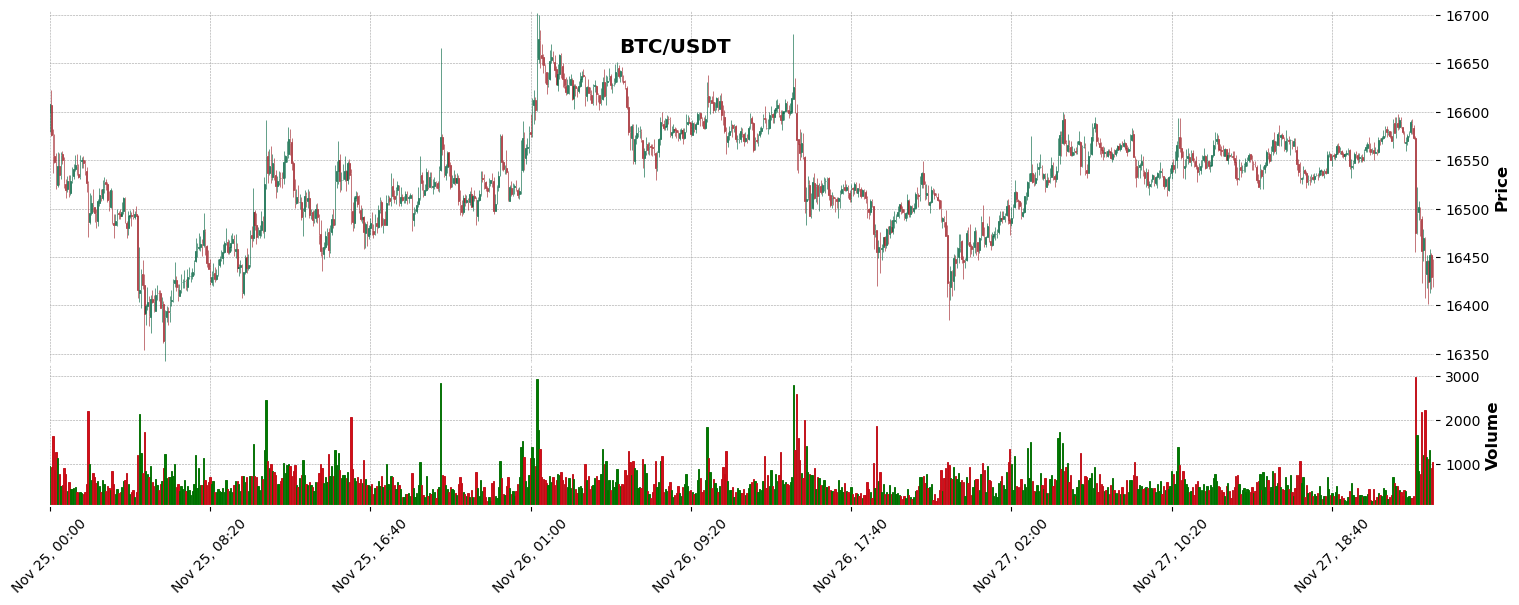

In [16]:
start_period=min_end_date-pd.Timedelta("3 days")
end_period=min_end_date
plot_ohlcv(df_list5m["BTC/USDT"],"BTC/USDT", start_date=start_period ,end_date=end_period)

In [17]:
def get_top_volumes(start_period,end_period,df_list1d=df_list1d):
    ALLTOP20VOLUMES={}
    for day in df_list1d["BTC/USDT"].index:
        if start_period<= day <= end_period:
            Top20vol={}
            for p,df in df_list1d.items():
                if p not in ["EUR/USDT","EUR/BUSD","BTC/USDT","BTC/BUSD"]:
                    try:Top20vol.update({p:(df.loc[day].volume*df.loc[day].close)})
                    except Exception as e :pdebug(f'Time Error wile working on {p}: {e}')
                    #print (Top20vol)
            ALLTOP20VOLUMES.update({day:sorted(Top20vol, key=Top20vol.get, reverse=True)[:20]})
    return ALLTOP20VOLUMES

def is_coin_in_portfolio(symbol,instant,PORTFOLIO):
    for i in range(1,TRADE_SLOTS+1):
        try:
            if (PORTFOLIO[f"slot{i}_symbol"].loc[instant]==symbol):
                return i
        except Exception as e:
            print(f"error :{e}")
    return False
ALLTOP20VOLUMES=get_top_volumes(start_period-pd.Timedelta("10 minute") ,end_period+pd.Timedelta("10 minute"))


In [18]:
SORT_SIGNAL=True
def backtest_buy_sell(SIGNAL_DF, df_list1m, start_period, end_period):
    pdebug(f"---   Backtesting form {start_period} to {end_period} while tp:{TAKE_PROFIT}% and sl:{STOP_LOSS}% and trading fee: {TRADING_FEE}% --- ")
    # Initialize variables and counters
    global ORDER_HISTORY 
    ORDER_HISTORY = pd.DataFrame(columns=['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
    current_time = pd.Timestamp(start_period)
    end_period_margin = end_period + pd.Timedelta(f"{2 * MAX_HOLDING_TIME} minute")
    PORTFOLIO = create_portfolio_dataframe(TRADE_SLOTS, init_quantity=550, base_currency=PAIR_WITH, PERIODE_START=start_period)
    PeriodRange = pd.date_range(start=pd.Timestamp(start_period), end=pd.Timestamp(end_period), freq='1min')

    # Verify buying opportunities
    for current_time in PeriodRange:
        if current_time == pd.Timestamp(start_period):
            pdebug(f"update_slots -> The first case : {current_time}")
            PORTFOLIO.loc[current_time + pd.Timedelta("1 minute")] =PORTFOLIO.loc[current_time]
            continue
        else:
            previous_minute = current_time - pd.Timedelta("1 minute")
        # print(PORTFOLIO.tail)
        PORTFOLIO=update_slots(current_time, df_list1m, PORTFOLIO=PORTFOLIO)
        pdebug(current_time)
        if SORT_SIGNAL:
            minute_signal_list=SIGNAL_DF[SIGNAL_DF.time == pd.Timestamp(current_time)].sort_values('note',ascending=False)
        else:
            minute_signal_list=SIGNAL_DF[SIGNAL_DF.time == pd.Timestamp(current_time)]
        for i, sig_row in minute_signal_list.iterrows():
            # Buy the coin if slot and cash is available:
            coin = sig_row['coin']
            time = sig_row['time']
            price = sig_row['price']  # We assume there's only one price per signal
            note = sig_row['note']
            slot_num = is_coin_in_portfolio(coin, previous_minute, PORTFOLIO)

            # Buy first:
            if (note + PRECISION) >= 0.5:
                PORTFOLIO = buy_coin(time, coin, price, PORTFOLIO=PORTFOLIO, pair_with_qte=TRADE_TOTAL)

        if USE_TRAILING_STOP_LOSS:
            PORTFOLIO = trailing_stop_loss_take_profit(current_time, PORTFOLIO, TAKE_PROFIT, STOP_LOSS, TRAILING_STOP_LOSS, TRAILING_TAKE_PROFIT)
        else:
            PORTFOLIO = stop_loss_or_take_profit(current_time, df_list1m, PORTFOLIO, STOP_LOSS, TAKE_PROFIT, TRADING_FEE)
        PORTFOLIO = stop_holding(current_time, PORTFOLIO, MAX_HOLDING_TIME)
        pct_benefit = 100 * PORTFOLIO.at[current_time, f'total_{PAIR_WITH}'] / PORTFOLIO[f'total_{PAIR_WITH}'].iloc[0]
        pdebug(f"Total benefit pct {pct_benefit}")
        
    return PORTFOLIO

def stop_holding(time, PORTFOLIO, max_holding_duration):
    max_holding_duration_td = pd.Timedelta(minutes=max_holding_duration)

    for slot_ft in range(1, TRADE_SLOTS + 1):
        if not pd.isna(PORTFOLIO.at[time, f'slot{slot_ft}_symbol']):
            coin = PORTFOLIO.at[time, f'slot{slot_ft}_symbol']
            bought_time = PORTFOLIO.at[time, f'slot{slot_ft}_bought_time']
            holding_duration = time - bought_time

            if holding_duration > max_holding_duration_td:
                # Sell the coin
                current_price = df_list1m[coin].at[time, "close"]
                slot_volume = PORTFOLIO.at[time, f'slot{slot_ft}_volume']
                slot_total_value = PORTFOLIO.at[time, f'slot{slot_ft}_current_total_{PAIR_WITH}']
                slot_fee = (TRADING_FEE / 100) * slot_total_value
                
                PORTFOLIO.at[time, f'slot{slot_ft}_symbol'] = np.nan
                PORTFOLIO.at[time, f'slot{slot_ft}_volume'] = np.nan
                PORTFOLIO.at[time, f'slot{slot_ft}_original_price_{PAIR_WITH}'] = np.nan
                PORTFOLIO.at[time, f'slot{slot_ft}_current_total_{PAIR_WITH}'] = np.nan
                PORTFOLIO.at[time, f'slot{slot_ft}_bought_time'] = np.nan
                
                PORTFOLIO.at[time, f'total_{PAIR_WITH}'] -= slot_fee
                PORTFOLIO.at[time, f'reserve_{PAIR_WITH}'] += (slot_total_value - slot_fee)
                
                add_order_to_history(pair=f"{coin}_{PAIR_WITH}", side='sell', price=current_price, quantity=slot_volume, executed=slot_volume, time=time, status='filled')
                pdebug(f"Automatic sell triggered for {coin} in slot {slot_ft} due to exceeding holding duration")
    return PORTFOLIO



In [19]:

def day_expand(data_full):
    ser = pd.to_datetime(pd.Series(data_full.index))
    data_full["day"]=ser.dt.isocalendar().day.values
    data_full["hour"]=ser.dt.hour.values
    data_full["minute"]=ser.dt.minute.values
    

def Meta_expand(data_full,metadt,pair):
    data_full["lunch_day"]=int(-(pd.to_datetime(metadt[metadt["Pair"] == pair]["launch_minute"])-pd.Timestamp('2020-01-01 00:00:00.000000')).dt.days)


def expand_previous_v0(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        for i in range(1, window+1):
            df.loc[window:len(df),"high-"+str(i)]=None
            df.loc[window:len(df),"low-"+str(i)]=None
            df.loc[window:len(df),"close-"+str(i)]=None            
            df.loc[window:len(df),"volume-"+str(i)]=None
        window=len(df)

    for i in range(1, window+1):
        try:
            df.loc[window:len(df),"high-"+str(i)]=None
            df["high-"+str(i)].iloc[window:len(df)]=df["high"][window-i:len(df)-i].to_list()
            df.loc[window:len(df),"low-"+str(i)]=None
            df["low-"+str(i)].iloc[window:len(df)]=df["low"][window-i:len(df)-i].to_list()
            df.loc[window:len(df),"close-"+str(i)]=None
            df["close-"+str(i)].iloc[window:len(df)]=df["close"][window-i:len(df)-i].to_list()            
            df.loc[window:len(df),"volume-"+str(i)]=None
            df["volume-"+str(i)].iloc[window:len(df)]=df["volume"][window-i:len(df)-i].to_list()
            
        except:
            prerr("Error in     expand_previous: " +str(i))
    if window >= len(df): return df       
    return df.iloc[window:]

def expand_previous_org(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        for i in range(1, window+1):
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=None            
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=None
        window=len(df)

    for i in range(1, window+1):
        try:
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=df["high"][window-i:len(df)-i].to_list()
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=df["low"][window-i:len(df)-i].to_list()
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=df["close"][window-i:len(df)-i].to_list()            
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=df["volume"][window-i:len(df)-i].to_list()
            
        except:
            prerr("Error in     expand_previous: " +str(i))
    if window >= len(df): return df       
    return df.iloc[window:]


def expand_previous(dataframe, window=10):
    df = dataframe.copy()
    for i in range(1, window + 1):
        try:
            df.loc[window:, f"high-{i}"] = df["high"].shift(i)[window:].tolist()
            df.loc[window:, f"low-{i}"] = df["low"].shift(i)[window:].tolist()
            df.loc[window:, f"close-{i}"] = df["close"].shift(i)[window:].tolist()
            df.loc[window:, f"volume-{i}"] = df["volume"].shift(i)[window:].tolist()
        except Exception as e:
            print(f"Error in expand_previous: {e}")
    return df.iloc[window:]


def expand_previous_v2(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        df = df.reindex(columns=[col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]])
        return df

    window_cols = df[["high", "low", "close", "volume"]].rolling(window, min_periods=1)
    window_cols = window_cols.apply(lambda x: pd.Series(x.values))
    window_cols.columns = [col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]]
    df = pd.concat([df, window_cols], axis=1)
    df = df.iloc[window:]
    return df

def rapid1d_expand(df1m,df1d,window=2):
    d1min=df1m.copy()
    d1day=df1d.loc[
    d1min.index[0].round(freq='1d')-pd.Timedelta(str(window)+' day'):
    d1min.index[len(d1min)-1].round(freq='1d')+pd.Timedelta('1 day')
    ].copy()
    d1day_pre=expand_previous(d1day,window)
    d1day_pre=d1day_pre.drop(columns=['open', 'low','close','high','volume'])
    d1day_pre=d1day_pre.add_suffix("_day")
    d1min=pd.merge_asof(
        d1min, d1day_pre, on=None, left_on=None, right_on=None, left_index=True, 
        right_index=True, by=None, left_by=None, right_by=None, 
        suffixes=('', '_day'),
        tolerance=pd.Timedelta('1 day'), allow_exact_matches=True, direction='backward')
    return d1min

def rapid1h_expand(df1m,df1h,window=2):
    d1min=df1m.copy()
    d1hour=df1h.loc[
    d1min.index[0].round(freq='H')-pd.Timedelta(str(window)+' hour'):
    d1min.index[len(d1min)-1].round(freq='H')+pd.Timedelta('1 hour')
    ].copy()
    d1hour_pre=expand_previous(d1hour,window)
    d1hour_pre=d1hour_pre.drop(columns=['open', 'low','close','high','volume'])
    d1hour_pre=d1hour_pre.add_suffix("_hour")
    d1min=pd.merge_asof(
    d1min, d1hour_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_hour'),
    tolerance=pd.Timedelta('1 hour'), allow_exact_matches=True, direction='backward')
    return d1min


def rapid5m_expand(df1m,df5m,window=2):
    d1min=df1m.copy()
    d5min=df5m.loc[
    d1min.index[0].round(freq='5 min')-pd.Timedelta(str(window*5+10)+' min'):
    d1min.index[len(d1min)-1].round(freq='5 min')+pd.Timedelta('5 min')
    ].copy()
    d5min_pre=expand_previous(d5min,window)
    d5min_pre=d5min_pre.drop(columns=['open', 'low','close','high','volume'])
    d5min_pre=d5min_pre.add_suffix("_5min")
    d1min=pd.merge_asof(
    d1min, d5min_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_5min'),
    tolerance=pd.Timedelta('5 min'), allow_exact_matches=True, direction='backward')
    return d1min

def rapid15m_expand(df1m,df15m,window=2):
    d1min=df1m.copy()
    d15min=df15m.loc[
    d1min.index[0].round(freq='15 min')-pd.Timedelta(str(window*15+30)+' min'):
    d1min.index[len(d1min)-1].round(freq='15 min')+pd.Timedelta('15 min')
    ].copy()
    d15min_pre=expand_previous(d15min,window)
    d15min_pre=d15min_pre.drop(columns=['open', 'low','close','high','volume'])
    d15min_pre=d15min_pre.add_suffix("_15min")
    d1min=pd.merge_asof(
    d1min, d15min_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_15min'),
    tolerance=pd.Timedelta('15 min'), allow_exact_matches=True, direction='backward')
    return d1min


def full_expand(df1m,df5m,df15m,df1h,df1d,window=10):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=window).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,window)
    d1min=rapid1h_expand(d1min,df1h,window)
    d1min=rapid15m_expand(d1min,df15m,window)
    d1min=rapid5m_expand(d1min,df5m,window)
    return d1min

def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min



        

def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min

def maxi_expand_v3(pair="GMT/USDT", i=0, j=10000, TIME_WINDOW=15, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase,
                 w1m=6,w5m=30,w15m=30,w1h=3,w1d=7,
                 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=30,btc_w1d=30,
                 df_list1m=df_list1m,df_list5m=df_list5m, df_list15m=df_list15m, df_list1h=df_list1h, df_list1d=df_list1d
                 ):
    start_index=i
    end_index=j
    window=TIME_WINDOW
    window_size=window
    buy_fn=buy_function

    pdebug(f"maxi custum expend : {pair} with those parameters: w1m={w1m},w5m={w5m},w15m={w15m},w1h={w1h},w1d={w1d} btc_w1m={btc_w1m},btc_w5m={btc_w5m},btc_w15m={btc_w15m},btc_w1h={btc_w1h},btc_w1d={btc_w1d}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand_costum(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d)
    btc_full = full_expand_costum(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], w1m=btc_w1m,w5m=btc_w5m,w15m=btc_w15m,w1h=btc_w1h,w1d=btc_w1d)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    # print(merged.columns)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=TIME_WINDOW)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"]) 
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=1-(merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=1-(merged[key])/merged["price"]

    merged=merged.dropna()
    pdebug(f'######################  max expend {pair} - shape {merged.shape}  buy mean : {merged.buy.mean()*100} ############################')
    return merged

def human_pct(float_pct,type_string="Precent Mean",ShowMessage=True):
    nb=round(float_pct*100,3)
    if ShowMessage: print(type_string+": "+"{:.3f}".format(nb)+"%")
    return nb
hp=human_pct


import warnings
warnings.filterwarnings('ignore')
PRERR=False
def prerr(err):
    if PRERR:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

PDEBUG=True
def pdebug(err):
    if PDEBUG:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))
        
        

In [20]:
tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
noww=pd.Timestamp(datetime.now())
tests_history_filename=f"workdir/backtest/test_all_models_tp{STOP_LOSS}_sl{TAKE_PROFIT}_mht{MAX_HOLDING_TIME}_between__{start_period.date()}-{end_period.date()}.csv"

In [21]:
ALLTOP20VOLUMES

{Timestamp('2022-11-25 00:00:00'): ['DOGE/USDT',
  'XRP/USDT',
  'LTC/USDT',
  'SHIB/USDT',
  'SOL/USDT',
  'TRX/USDT',
  'ADA/USDT',
  'REN/USDT',
  'EOS/USDT',
  'DOT/USDT',
  'ETC/USDT',
  'APE/USDT',
  'AVAX/USDT',
  'NEAR/USDT',
  'XMR/USDT',
  'ALGO/USDT',
  'OP/USDT',
  'GRT/USDT',
  'GALA/USDT',
  'LAZIO/USDT'],
 Timestamp('2022-11-26 00:00:00'): ['DOGE/USDT',
  'LTC/USDT',
  'XRP/USDT',
  'SOL/USDT',
  'MOB/USDT',
  'COCOS/USDT',
  'APE/USDT',
  'REN/USDT',
  'SHIB/USDT',
  'ADA/USDT',
  'TRX/USDT',
  'DOT/USDT',
  'ETC/USDT',
  'NEAR/USDT',
  'AVAX/USDT',
  'SCRT/USDT',
  'OP/USDT',
  'XMR/USDT',
  'JASMY/USDT',
  'ALGO/USDT'],
 Timestamp('2022-11-27 00:00:00'): ['DOGE/USDT',
  'XRP/USDT',
  'LTC/USDT',
  'SHIB/USDT',
  'APE/USDT',
  'MOB/USDT',
  'SOL/USDT',
  'WAVES/USDT',
  'COCOS/USDT',
  'TRX/USDT',
  'FLUX/USDT',
  'ADA/USDT',
  'ETC/USDT',
  'NEAR/USDT',
  'DOT/USDT',
  'REN/USDT',
  'AVAX/USDT',
  'LUNA/USDT',
  'KDA/USDT',
  'ENS/USDT'],
 Timestamp('2022-11-28 00:00:

In [22]:
w1m=6
w5m=10
w15m=50 #25
w1h=8
w1d=7
btc_w1m=6
btc_w5m=4
btc_w15m=5
btc_w1h=12
btc_w1d=15
Timestamp=pd.Timestamp
Mini_ALLTOP20VOLUMES={pd.Timestamp('2022-11-26 00:00:00'): ['DOGE/USDT',
  'LTC/USDT',
  'DOGE/BUSD',
  'XRP/USDT',
  'MOB/BUSD',
  'COCOS/BUSD',
  'SOL/USDT',
  'MOB/USDT',
  'COCOS/USDT',
  'APE/USDT',
  'SOL/BUSD',
  'SNM/BUSD',
  'REN/USDT',
  'XRP/BUSD',
  'LTC/BUSD',
  'SHIB/USDT',
  'REN/BUSD',
  'ADA/USDT',
  'TRX/USDT',
  'IQ/BUSD'],
 Timestamp('2022-11-27 00:00:00'): ['DOGE/USDT',
  'DOGE/BUSD',
  'XRP/USDT',
  'LTC/USDT',
  'MOB/BUSD',
  'SHIB/USDT',
  'APE/USDT',
  'MOB/USDT',
  'SOL/USDT',
  'XRP/BUSD',
  'COCOS/BUSD',
  'WAVES/USDT',
  'COCOS/USDT',
  'APE/BUSD',
  'TRX/USDT',
  'FLUX/BUSD',
  'SHIB/BUSD',
  'SOL/BUSD',
  'LTC/BUSD',
  'SNM/BUSD'],
 Timestamp('2022-11-28 00:00:00'): ['DOGE/USDT',
  'XRP/USDT',
  'DOGE/BUSD',
  'LTC/USDT',
  'XRP/BUSD',
  'APE/USDT',
  'SOL/USDT',
  'SOL/BUSD',
  'ADA/USDT',
  'SHIB/USDT',
  'TRX/USDT',
  'SNM/BUSD',
  'APE/BUSD',
  'LTC/BUSD',
  'DOT/USDT',
  'ETC/USDT',
  'WAVES/USDT',
  'AVAX/USDT',
  'NEAR/USDT',
  'SHIB/BUSD']}


In [23]:
def rapid1d_expand_v2(df1m, df1d, window=2):
    # Resample df1d to daily frequency and shift by the window size
    d1day = df1d.resample('D').ffill().shift(window).iloc[window:-1].copy()

    # Compute the rolling window for d1day and drop original columns
    d1day_pre = d1day.rolling(window, min_periods=1, closed='right')
    d1day_pre = d1day_pre.apply(lambda x: pd.Series(x.values))
    d1day_pre = d1day_pre.drop(columns=['open', 'low', 'close', 'high', 'volume'])
    d1day_pre = d1day_pre.add_suffix("_day")

    # Merge the rolling window with df1m using the timestamp as the join key
    d1min = pd.merge(df1m, d1day_pre, how='left', left_index=True, right_index=True)

    return d1min

def expand_previous_v2(dataframe, window=10): # not working
    """
    The new implementation first checks if the window parameter is greater than or equal to the length of the DataFrame. If so, it creates a new DataFrame with the desired number of columns and returns it.

    If the window parameter is less than the length of the DataFrame, the function uses Pandas' rolling method to compute a rolling window over the "high", "low", "close", and "volume" columns of the DataFrame. 
    The resulting rolling window DataFrame is then transformed into a new DataFrame with columns for each previous value of the "high", "low", "close", and "volume" columns, using a nested list comprehension. 
    Finally, the function concatenates the original DataFrame and the new DataFrame and returns the modified DataFrame with the previous values columns.

    This implementation should be faster and more memory-efficient than the original implementation, especially for large DataFrames with many rows and columns.
    """
    df = dataframe.copy()
    if window >= len(df):
        df = df.reindex(columns=[col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]])
        return df

    window_cols = df[["high", "low", "close", "volume"]].rolling(window, min_periods=1)
    window_cols = window_cols.apply(lambda x: pd.Series(x.values))
    window_cols.columns = [col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]]
    df = pd.concat([df, window_cols], axis=1)
    df = df.iloc[window:]
    return df

def expand_previous_v3(dataframe, window=10,columns = ['high', 'low', 'close', 'volume']):
    if window >= len(dataframe):
        dataframe = dataframe.iloc[-window:]
        return dataframe.fillna(value=None)
    df = dataframe.copy()
    for col in columns:
        for i in range(1, window + 1):
            df[f"{col}-{i}"] = df[col].shift(i)

    return df.iloc[window:]

def rapid1d_expand_v3(df1m, df1d, window=2):
    d1min=df1m.copy()
    d1day=df1d.loc[
    d1min.index[0].round(freq='1d')-pd.Timedelta(str(window)+' day'):
    d1min.index[len(d1min)-1].round(freq='1d')+pd.Timedelta('1 day')
    ].copy()
    d1day_pre=expand_previous_v3(d1day,window)
    d1day_pre=d1day_pre.drop(columns=['open', 'low','close','high','volume'])
    d1day_pre=d1day_pre.add_suffix("_day")
    d1min=pd.merge_asof(
        d1min, d1day_pre, on=None, left_on=None, right_on=None, left_index=True, 
        right_index=True, by=None, left_by=None, right_by=None, 
        suffixes=('', '_day'),
        tolerance=pd.Timedelta('1 day'), allow_exact_matches=True, direction='backward')
    return d1min

In [24]:
def noteq(ddd,ddd2):
    not_equal = ddd.ne(ddd2)
    # not_equal
    # get the rows that are not equal
    not_equal_rows = ddd2[not_equal.any(axis=1)]
    print(not_equal_rows)
    return not_equal_rows

In [25]:
import sys
day=pd.Timestamp("2022-11-26")
coin="ETC/USDT"
loc_start = df_list1m[coin].index.get_loc(day)
loc_end = df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
mini_df=maxi_expand_v3(pair=coin, i=loc_start, j=loc_end, TIME_WINDOW=3, metadata=MetaData,
                                    high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                                    buy_function=buy_alwase,
                                    w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15,
                           df_list1m=df_list1m,df_list5m=df_list5m, df_list15m=df_list15m, df_list1h=df_list1h, df_list1d=df_list1d)

 Error in pdebug maxi custum expend : ETC/USDT with those parameters: w1m=6,w5m=10,w15m=50,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
 Error in pdebug ######################  max expend ETC/USDT - shape (1434, 499)  buy mean : 100.0 ############################


In [26]:
mini_df

price    high-1         low-1   close-1  volume-1  \
date                                                                       
2022-11-26 00:06:00  20.0850  0.000747  2.240478e-03  0.000747    432.75   
2022-11-26 00:07:00  20.1000  0.000000  1.492537e-03  0.000000    188.34   
2022-11-26 00:08:00  20.1025  0.000124  1.243626e-04  0.000124     87.98   
2022-11-26 00:09:00  20.1025 -0.000373  1.243626e-04  0.000124    280.84   
2022-11-26 00:10:00  20.1000 -0.000995  4.975124e-04 -0.000498    413.48   
...                      ...       ...           ...       ...       ...   
2022-11-26 23:55:00  19.8750 -0.000252 -2.515723e-04 -0.000252     56.64   
2022-11-26 23:56:00  19.8700 -0.000503 -2.220446e-16 -0.000503     73.23   
2022-11-26 23:57:00  19.8750 -0.000252  7.547170e-04  0.000755    115.13   
2022-11-26 23:58:00  19.8650 -0.000755 -2.516990e-04 -0.000252      1.95   
2022-11-26 23:59:00  19.8825  0.000629  1.131648e-03  0.001132     22.81   

                       high-2     low-2   close-2  volume-2    high-3  ...  \
date                                                                   ...   
2022-11-26 00:06:00  0.001245  0.001743  0.001245    322.02  0.000747  ...   
2022-11-26 00:07:00  0.001493  0.002985  0.001493    432.75  0.001990  ...   
2022-11-26 00:08:00  0.000124  0.001617  0.000124    188.34  0.001617  ...   
2022-11-26 00:09:00  0.000124  0.000124  0.000124     87.98  0.000124  ...   
2022-11-26 00:10:00 -0.000498  0.000000  0.000000    280.84  0.000000  ...   
...                       ...       ...       ...       ...       ...  ...   
2022-11-26 23:55:00 -0.002264 -0.000755 -0.000755    696.96 -0.001258  ...   
2022-11-26 23:56:00 -0.000503 -0.000503 -0.000503     56.64 -0.002516  ...   
2022-11-26 23:57:00 -0.000252  0.000252 -0.000252     73.23 -0.000252  ...   
2022-11-26 23:58:00 -0.000755  0.000252  0.000252    115.13 -0.000755  ...   
2022-11-26 23:59:00  0.000126  0.000629  0.000629      1.95  0.000126  ...   

                     BTC_volume-3_5min  BTC_high-4_5min  BTC_low-4_5min  \
date                                                                      
2022-11-26 00:06:00          700.81826        -0.002538       -0.001027   
2022-11-26 00:07:00          700.81826        -0.002364       -0.000854   
2022-11-26 00:08:00          700.81826        -0.002475       -0.000965   
2022-11-26 00:09:00          700.81826        -0.002448       -0.000937   
2022-11-26 00:10:00          453.05190        -0.000969        0.000918   
...                                ...              ...             ...   
2022-11-26 23:55:00          711.99002         0.000751        0.001382   
2022-11-26 23:56:00          711.99002         0.000561        0.001192   
2022-11-26 23:57:00          711.99002         0.000441        0.001072   
2022-11-26 23:58:00          711.99002         0.000529        0.001160   
2022-11-26 23:59:00          711.99002         0.000578        0.001210   

                     BTC_close-4_5min  BTC_volume-4_5min  day  hour  minute  \
date                                                                          
2022-11-26 00:06:00         -0.001111          491.92598    6     0       6   
2022-11-26 00:07:00         -0.000938          491.92598    6     0       7   
2022-11-26 00:08:00         -0.001049          491.92598    6     0       8   
2022-11-26 00:09:00         -0.001022          491.92598    6     0       9   
2022-11-26 00:10:00          0.000826          700.81826    6     0      10   
...                               ...                ...  ...   ...     ...   
2022-11-26 23:55:00          0.000896          276.60211    6    23      55   
2022-11-26 23:56:00          0.000706          276.60211    6    23      56   
2022-11-26 23:57:00          0.000586          276.60211    6    23      57   
2022-11-26 23:58:00          0.000674          276.60211    6    23      58   
2022-11-26 23:59:00          0.000723          276.60211    6    23      59   

               

In [27]:
import sys

def generate_signals_costum(ALLTOP20VOLUMES, df_list1m, HoldingTime, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,
                           w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15):
    SIGNAL_DF = pd.DataFrame(columns=['coin', 'time', 'price', 'note'])
    for day, TOPLIST in ALLTOP20VOLUMES.items():
        for coin in TOPLIST:
            try:
                pdebug(f">>>>>>>>>>> working on {coin} at: {day} :")
                loc_start = df_list1m[coin].index.get_loc(day)
                loc_end = df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
                gc.collect()
                # df = maxi_expand_v3(pair=coin, i=loc_start, j=loc_end, TIME_WINDOW=3, metadata=MetaData, BUY_PCT=TAKE_PROFIT, SELL_PCT=STOP_LOSS,high_weight=1, buy_function=buy_alwase,
                #            w1m=w1m,w5m-w5m,w15m=w15m,w1h=w1h,w1d=w1d,
                #            btc_w1m=btc_w1m,btc_w5m=btc_w5m,btc_w15m=btc_w15m,btc_w1h=btc_w1h,btc_w1d=btc_w1d)
                df = maxi_expand_v3(pair=coin, i=loc_start, j=loc_end, TIME_WINDOW=3, metadata=MetaData,
                                    high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                                    buy_function=buy_alwase,
                                    w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d,
                                    btc_w1m=btc_w1m,btc_w5m=btc_w5m,btc_w15m=btc_w15m,btc_w1h=btc_w1h,btc_w1d=btc_w1d)
                
                dt = df.iloc[:,:-1].to_numpy(dtype=np.float32)
                predictions_note = backtest_model.predict(dt,verbose=0)
                predictions_round = predictions_note.round()
                dico_signal = {"coin":coin, "time":df[predictions_round==1].index.values, "price":df[predictions_round==1]["price"].values, "note":predictions_note[predictions_round==1]}
                df_signal_coin = pd.DataFrame(dico_signal)
                SIGNAL_DF = pd.concat([SIGNAL_DF, df_signal_coin])
            except:
                pdebug(f"error at {day} in {coin}")
    return SIGNAL_DF




In [28]:
def get_back_test_metrics(PORTFOLIO,pttitle="Total Assets Value Over Time"):
    initial_investment = PORTFOLIO.at[PORTFOLIO.index[0], f"reserve_{PAIR_WITH}"]
    final_value = PORTFOLIO.at[PORTFOLIO.index[-1], f"total_{PAIR_WITH}"]
    profit = final_value - initial_investment
    roi = (profit / initial_investment) * 100

    # Calculate the 10 biggest wins and losses
    PORTFOLIO['change'] = PORTFOLIO[f"total_{PAIR_WITH}"].diff()
    PORTFOLIO['change'] = pd.to_numeric(PORTFOLIO['change'], errors='coerce')
    top_10_wins = PORTFOLIO.nlargest(10, 'change')
    top_10_losses = PORTFOLIO.nsmallest(10, 'change')

    metrics = {
        'initial_investment': initial_investment,
        'final_value': final_value,
        'profit': profit,
        'roi': roi,
        'top_10_wins': top_10_wins,
        'top_10_losses': top_10_losses
    }
    
    print(f"Initial Investment: {initial_investment:.2f} {PAIR_WITH}")
    print(f"Final Value: {final_value:.2f} {PAIR_WITH}")
    print(f"Profit: {profit:.2f} {PAIR_WITH}")
    print(f"Return on Investment (ROI): {roi:.2f}%")

    # Set the desired plot dimensions (width, height)
    plt.figure(figsize=(20, 7))

    # Draw plot of total assets
    plt.plot(PORTFOLIO.index, PORTFOLIO[f"total_{PAIR_WITH}"], label="Total Assets")
    plt.scatter(top_10_wins.index, top_10_wins[f"total_{PAIR_WITH}"], color='g', label='Top 10 Wins')
    plt.scatter(top_10_losses.index, top_10_losses[f"total_{PAIR_WITH}"], color='r', label='Top 10 Losses')
    plt.xlabel("Time")
    plt.ylabel(f"Total {PAIR_WITH}")
    plt.title(pttitle)
    
    plt.legend()
    plt.grid()
    plt.show()
    return metrics


In [29]:
def save_results(take_profit,model_file_name,FinalValue,Profit,ROI,Nbr_wins,best_win,worst_loss,stop_loss=10,max_holding_time=1440):
    tests_history_filename=f"workdir/backtest/test_all_models_between_{start_period.date()}--{end_period.date()}.csv"
    try: 
        tests_history=pd.read_csv(tests_history_filename,index_col=0)
        # if tests_history:
        #     print(tests_history.head)
    except:
        tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
    model_results = pd.Series({
            'Model-FileName': model_file_name,
            'TAKE_PROFIT': take_profit,
            'STOP_LOSS': stop_loss,
            'MAX_HOLDING_TIME': max_holding_time,
            'FinalValue': FinalValue,
            'Profit': Profit,
            'ROI': ROI,
            'Nbr_wins': Nbr_wins,
            'best_win': best_win,
            'worst_loss': worst_loss
            })
    tests_history = tests_history.append(model_results, ignore_index=True)
    tests_history.to_csv(tests_history_filename)
    print(f"saving Test in {tests_history_filename}")
    return tests_history

def save_results2(take_profit,model_file_name,FinalValue,Profit,ROI,Nbr_wins,best_win,worst_loss,stop_loss=10,max_holding_time=1440,csvname="./workdir/backtest/all.csv"):
    tests_history_filename=csvname#f"workdir/backtest/test_all_models_between_{start_period.date()}--{end_period.date()}.csv"
    try: 
        tests_history=pd.read_csv(tests_history_filename,index_col=0)
        # if tests_history:
        #     print(tests_history.head)
    except:
        tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
    model_results = pd.Series({
            'Model-FileName': model_file_name,
            'TAKE_PROFIT': take_profit,
            'STOP_LOSS': stop_loss,
            'MAX_HOLDING_TIME': max_holding_time,
            'FinalValue': FinalValue,
            'Profit': Profit,
            'ROI': ROI,
            'Nbr_wins': Nbr_wins,
            'best_win': best_win,
            'worst_loss': worst_loss
            })
    tests_history = tests_history.append(model_results, ignore_index=True)
    tests_history.to_csv(tests_history_filename)
    print(f"saving Test in {tests_history_filename}")
    return tests_history

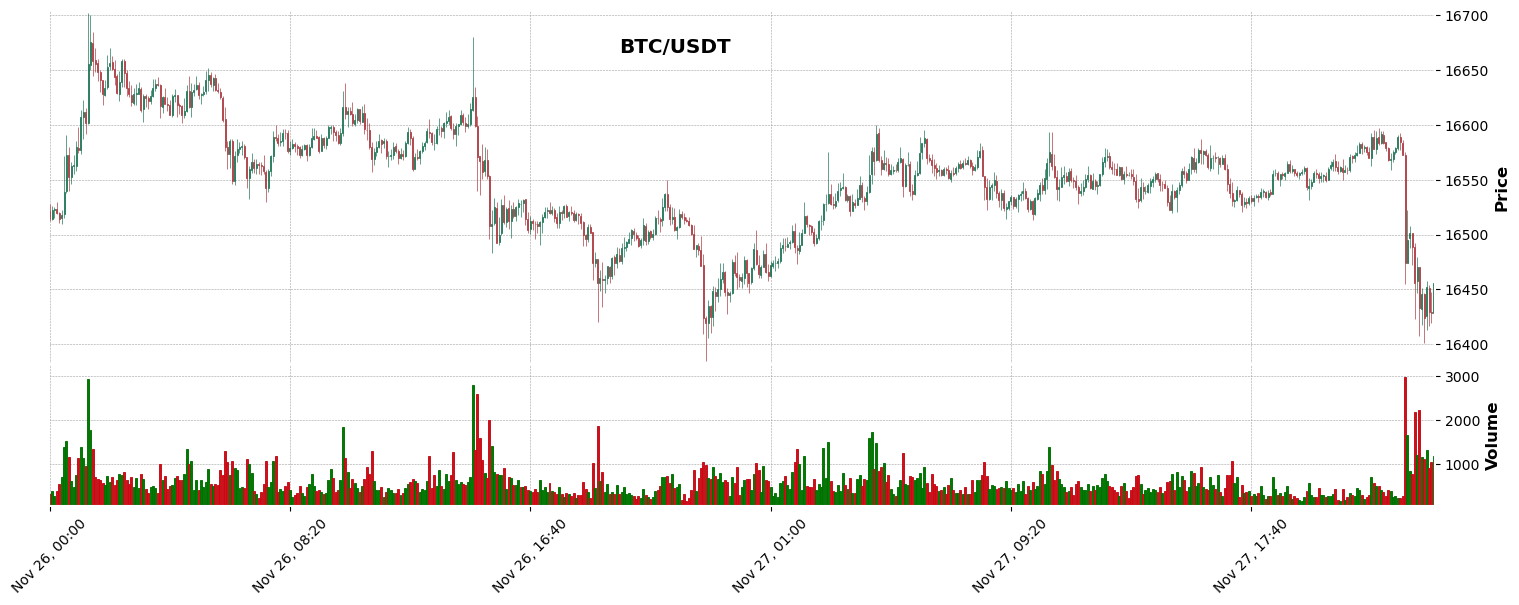

In [30]:
#save_results(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME)
# plot_ohlcv(df_list5m["BTC/USDT"],"BTC/USDT", start_date=start_period ,end_date=end_period)
# pd.read_csv(f"workdir/backtest/test_all_models_between_{start_period.date()}--{end_period.date()}.csv",)

start_period=min_end_date-pd.Timedelta("2 days")
end_period=min_end_date

plot_ohlcv(df_list5m["BTC/USDT"],"BTC/USDT", start_date=start_period ,end_date=end_period)

Testing model: /UltimeTradingBot/Data/IS_HIGH/tp430_w43_max43min_Model_true_win_model_Re1.h5 


2023-04-30 23:03:13.773550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-30 23:03:13.773640: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-30 23:03:13.773714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abj-K93SV
2023-04-30 23:03:13.773750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abj-K93SV
2023-04-30 23:03:13.773941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-04-30 23:03:13.774118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0


-------- ---------------------- TAKE_PROFIT = 4.3  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 683.58 USDT
Profit: 133.58 USDT
Return on Investment (ROI): 24.29%


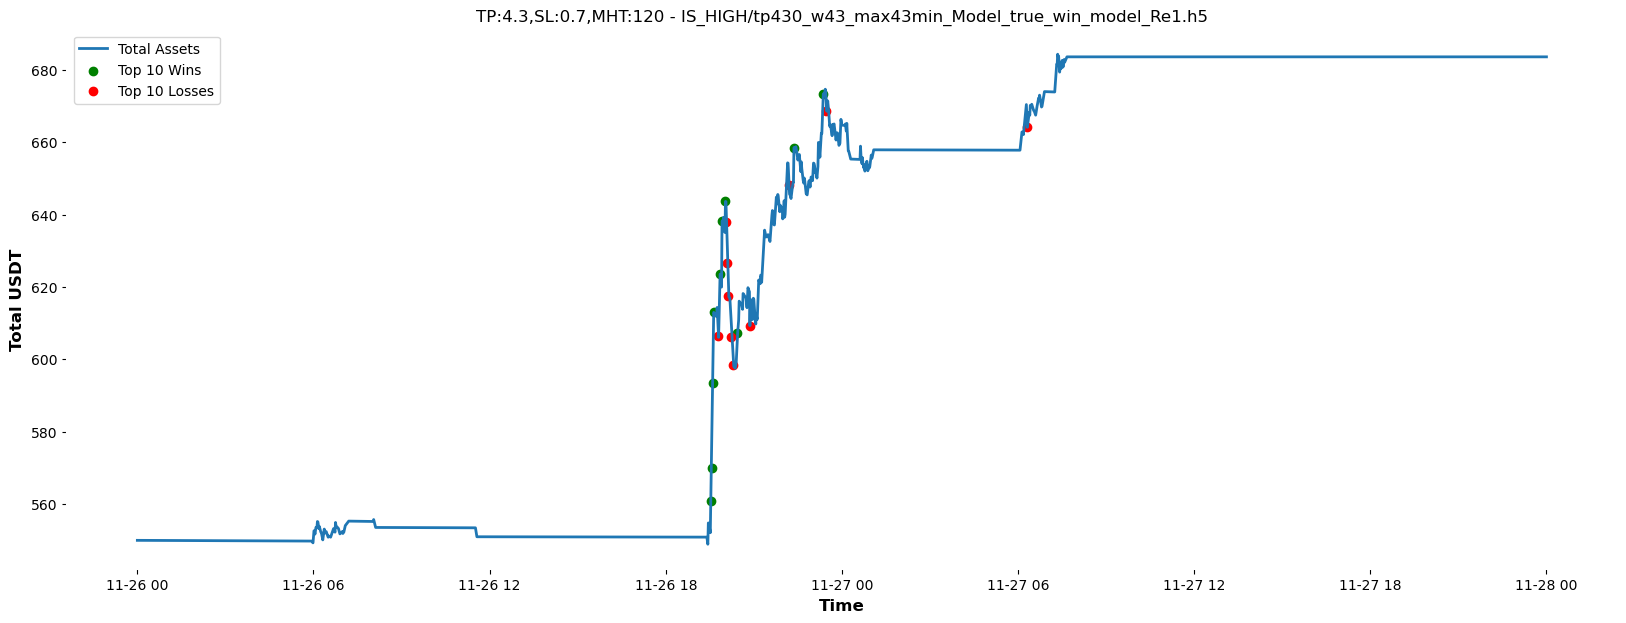

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv


In [31]:
## Recomended params
DEBUG=False
PDEBUG=False
MAX_HOLDING_TIME=120
Model_FileName="/UltimeTradingBot/Data/IS_HIGH/tp430_w43_max43min_Model_true_win_model_Re1.h5"
PRECISION=-0.0
USE_TRAILING_STOP_LOSS= False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
model_file=Model_FileName
print(f"Testing model: {model_file} ")
backtest_model=load_model(Model_FileName)
SIGNAL_DF = generate_signals_costum(Mini_ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)

TAKE_PROFIT= 4.3                  
STOP_LOSS= 0.7

print(f'-------- ---------------------- TAKE_PROFIT = {TAKE_PROFIT}  ---------------------------------') 

ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
TRAILING_DATA=pd.DataFrame()
Mname=Model_FileName.split('Data/')[1]
PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
win,loss=calculate_wins_losses(ORDER_HISTORY)
tt1=save_results(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME)


Testing model: /UltimeTradingBot/Data/IS_HIGH/tp430_w43_max43min_Model_true_win_model_Re1.h5 
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 647.48 USDT
Profit: 97.48 USDT
Return on Investment (ROI): 17.72%


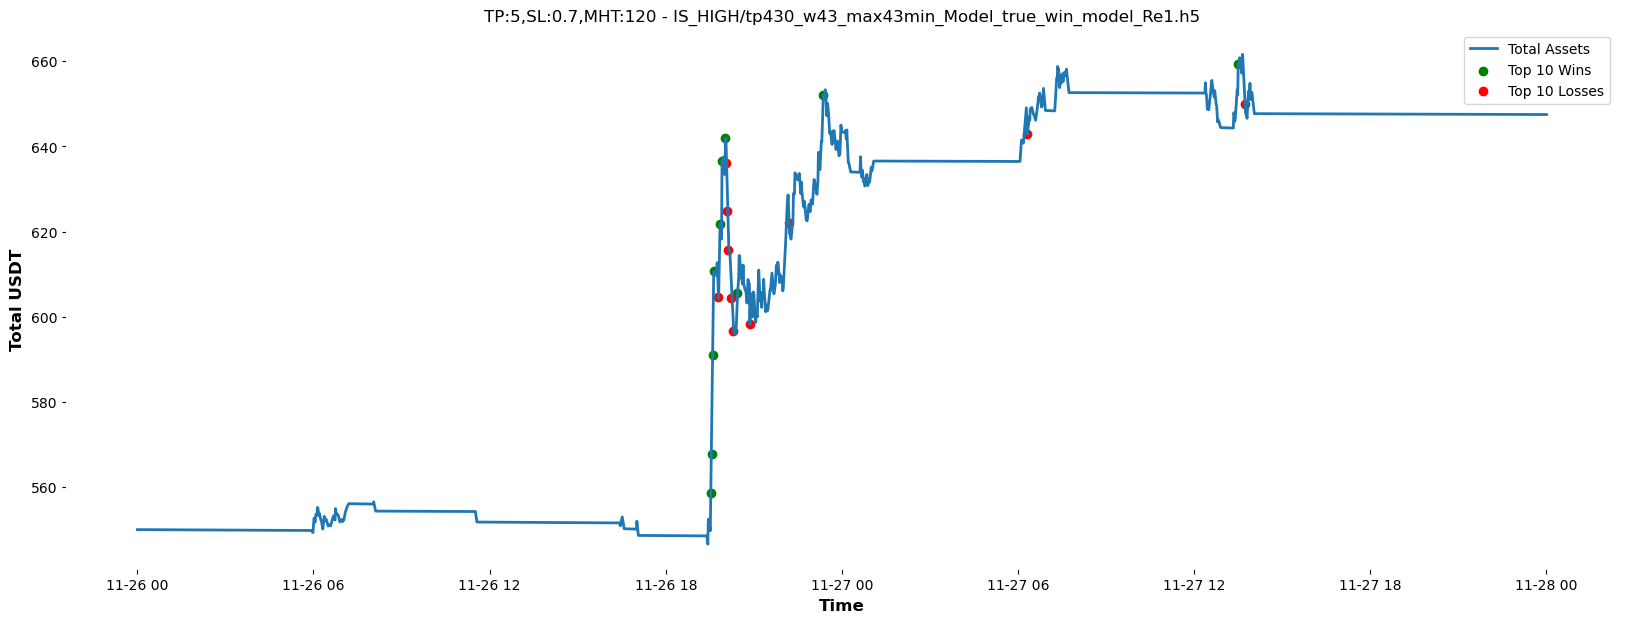

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 652.80 USDT
Profit: 102.80 USDT
Return on Investment (ROI): 18.69%


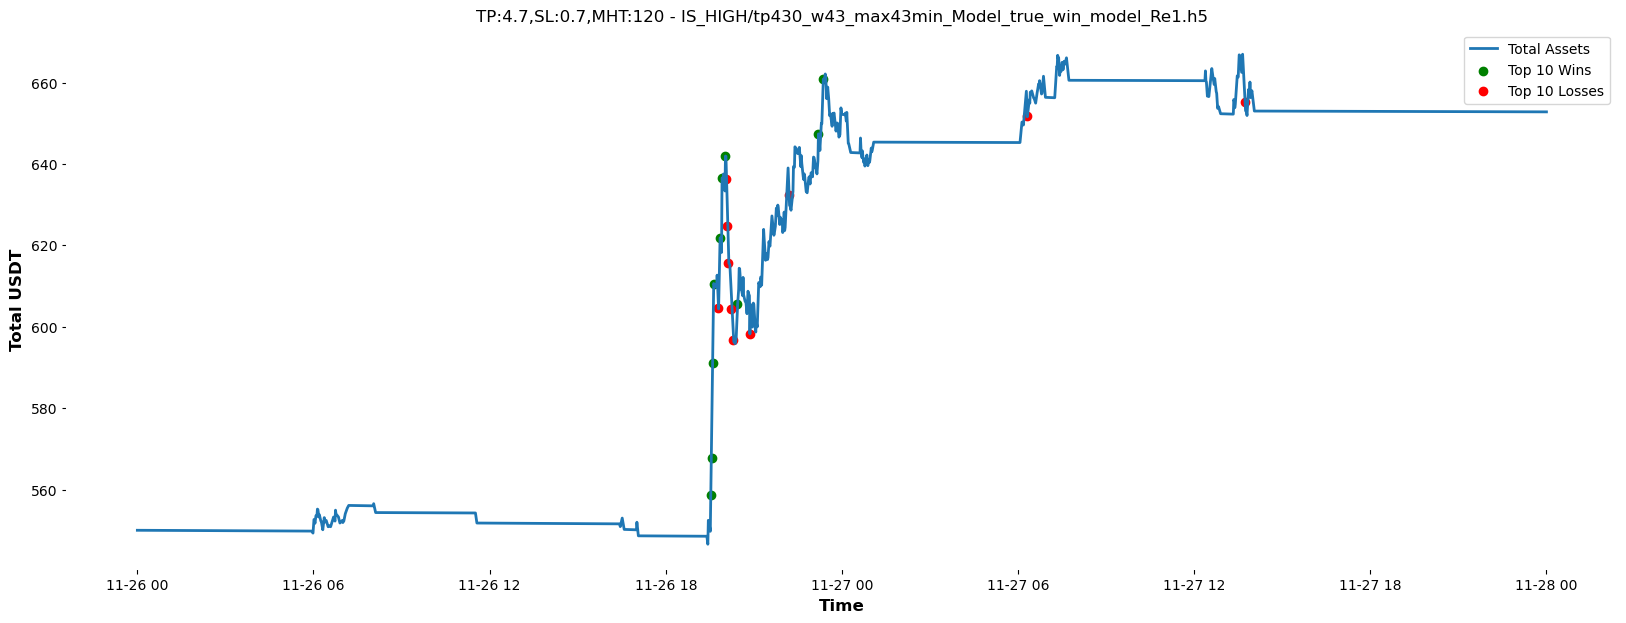

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 623.57 USDT
Profit: 73.57 USDT
Return on Investment (ROI): 13.38%


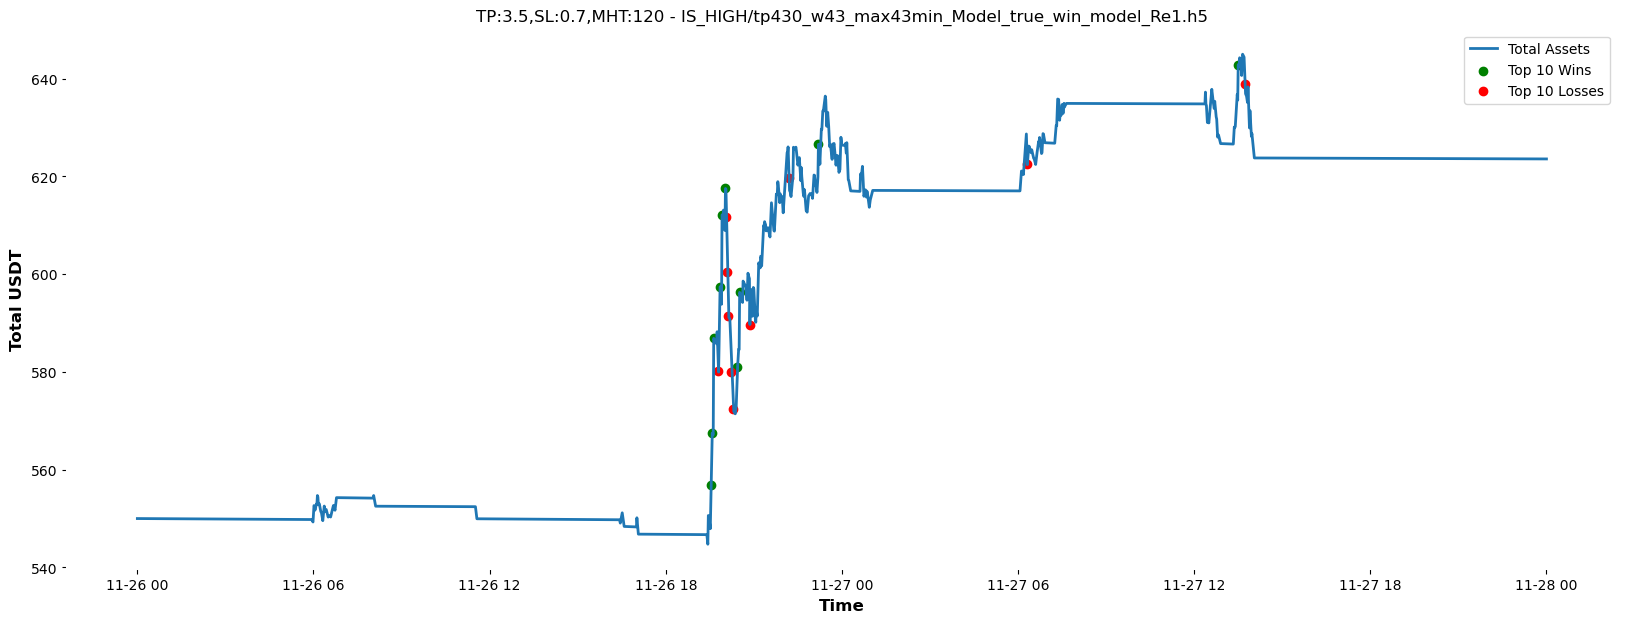

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 604.16 USDT
Profit: 54.16 USDT
Return on Investment (ROI): 9.85%


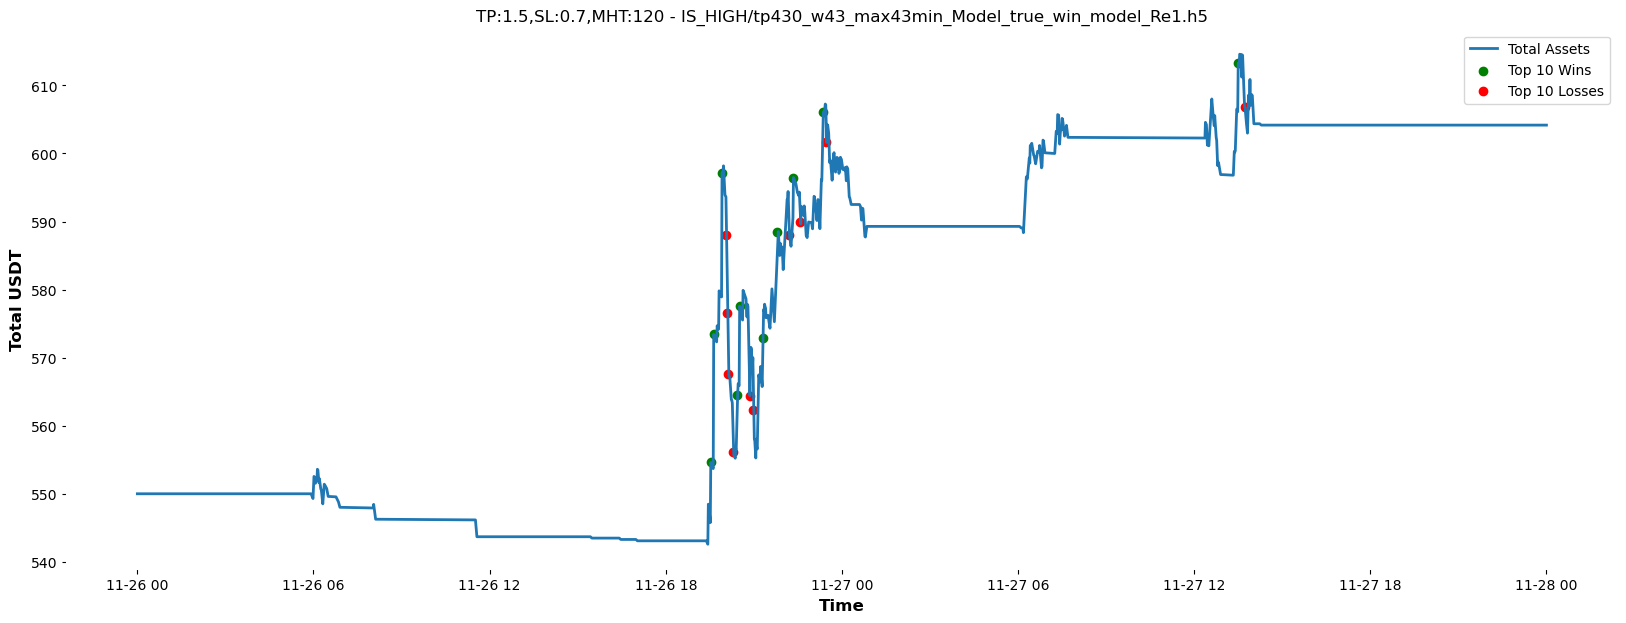

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 596.62 USDT
Profit: 46.62 USDT
Return on Investment (ROI): 8.48%


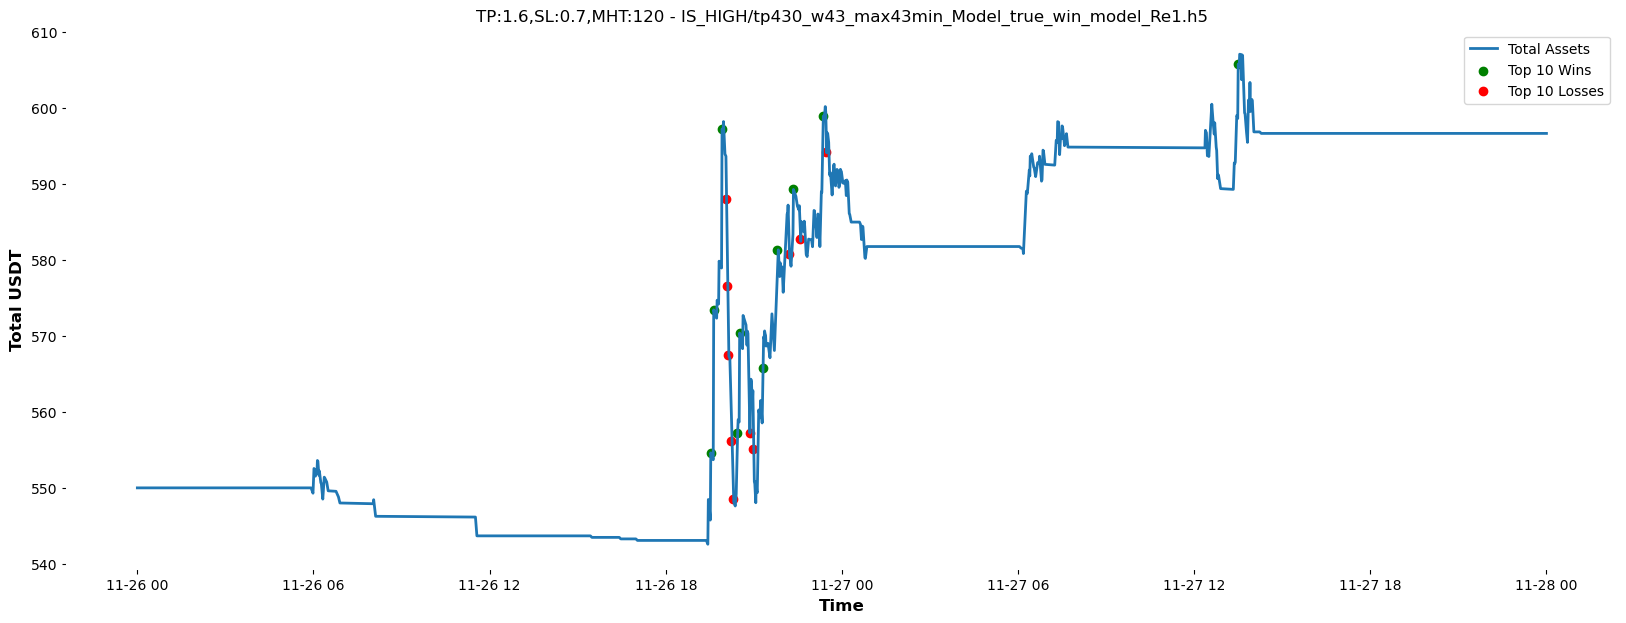

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 574.13 USDT
Profit: 24.13 USDT
Return on Investment (ROI): 4.39%


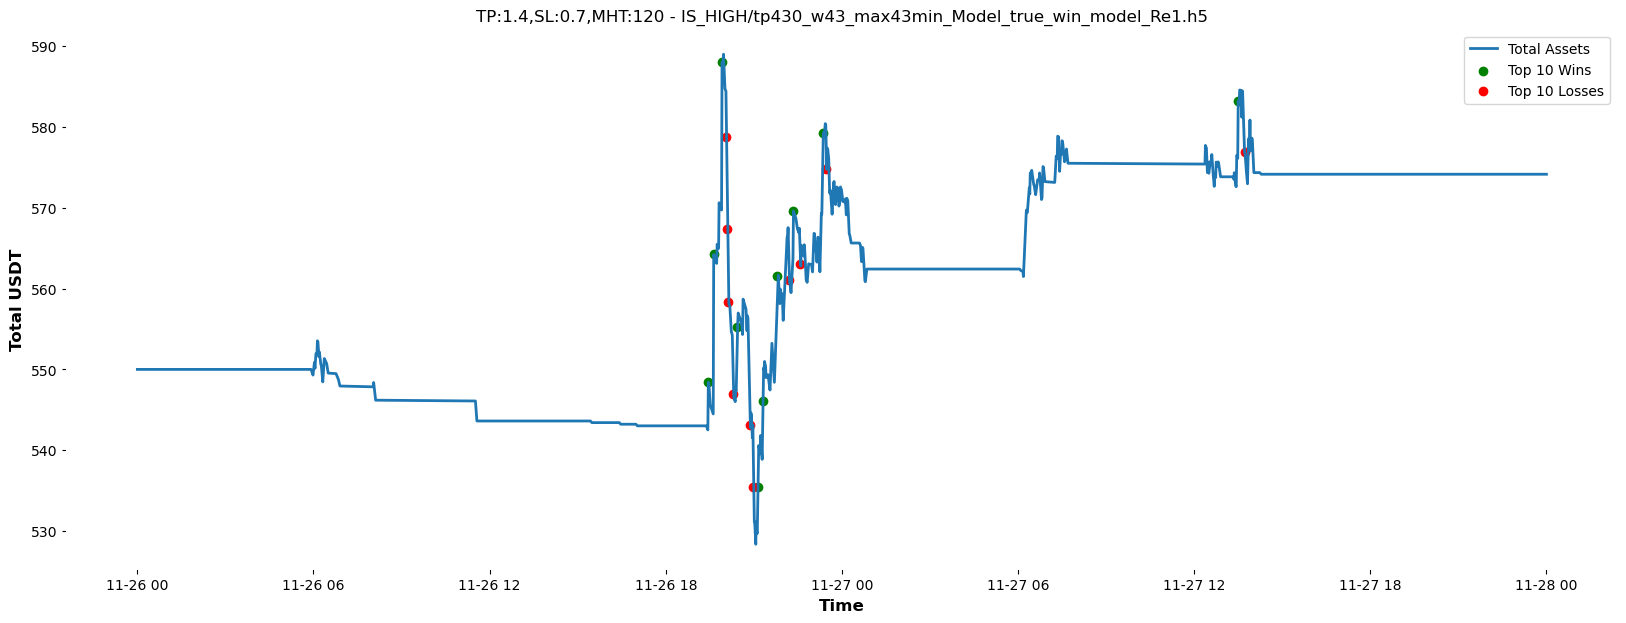

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 595.25 USDT
Profit: 45.25 USDT
Return on Investment (ROI): 8.23%


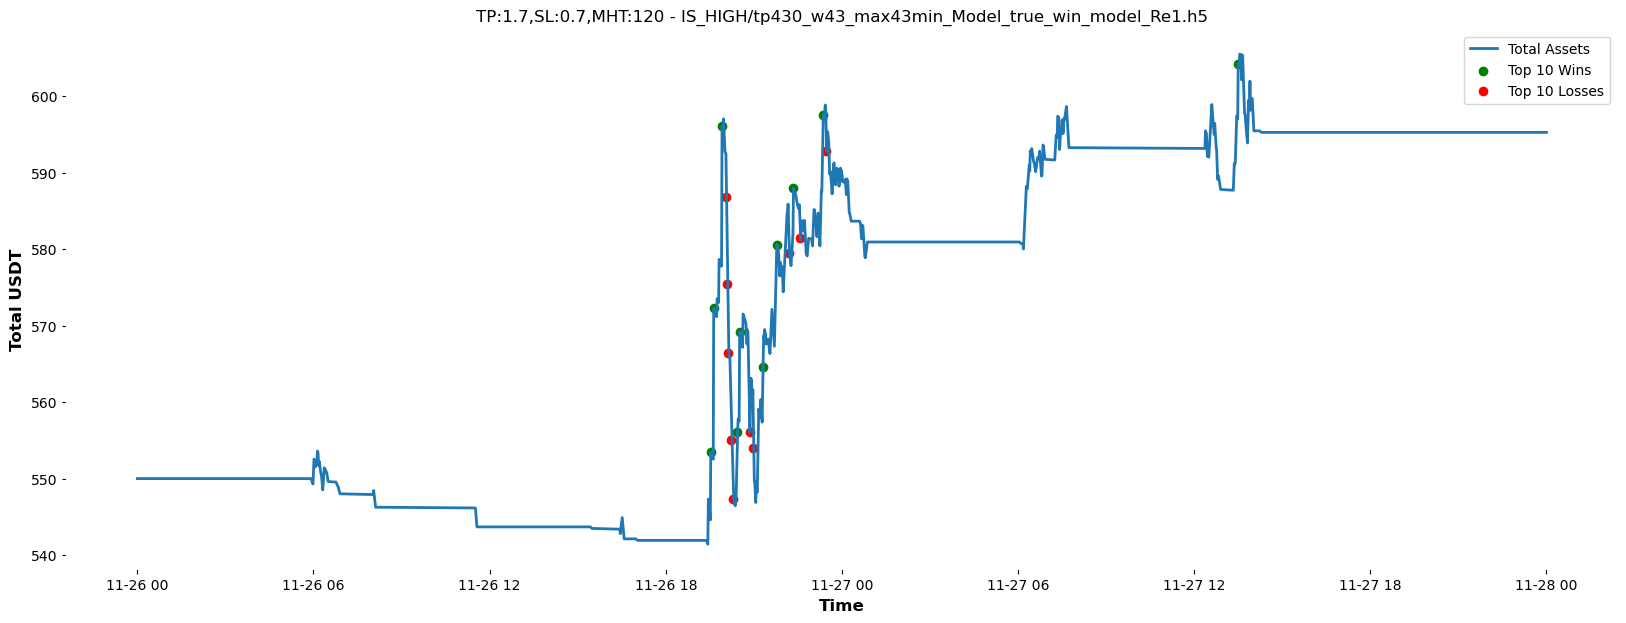

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 605.49 USDT
Profit: 55.49 USDT
Return on Investment (ROI): 10.09%


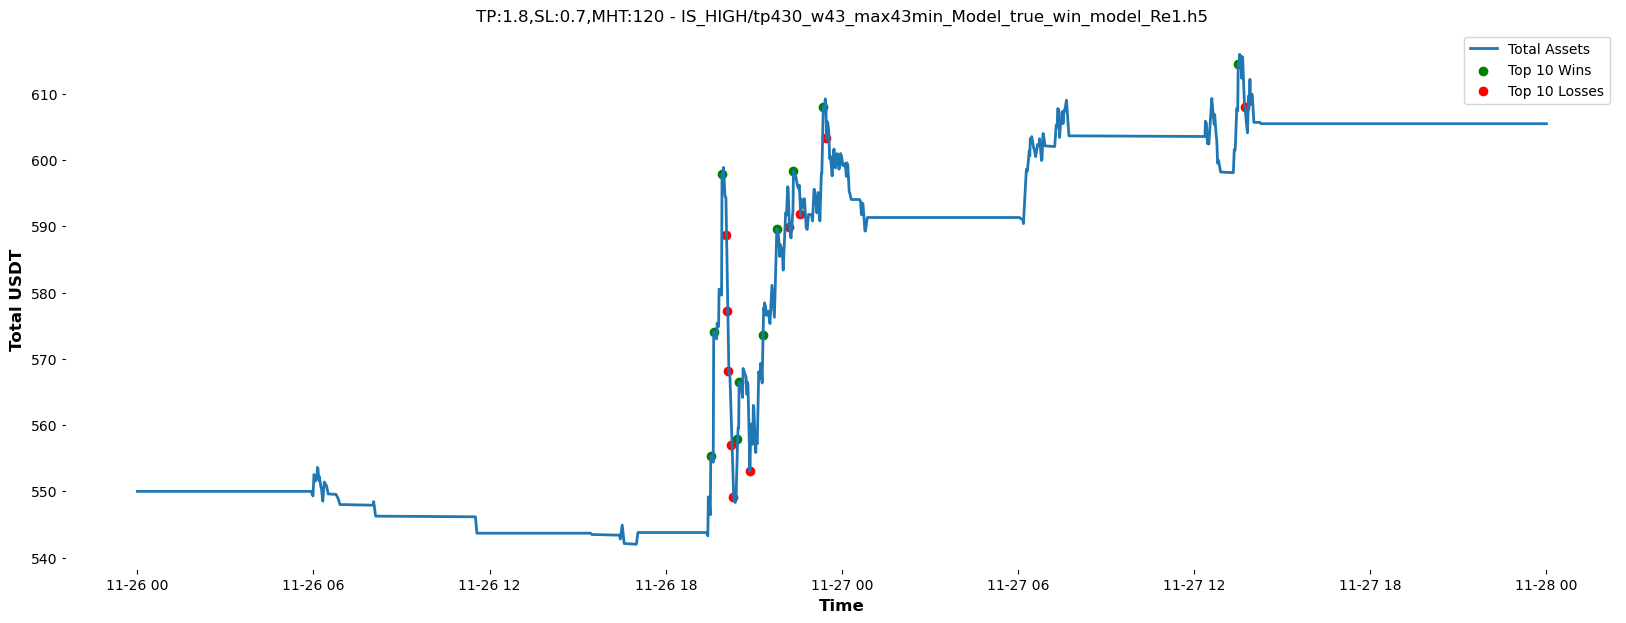

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 613.83 USDT
Profit: 63.83 USDT
Return on Investment (ROI): 11.61%


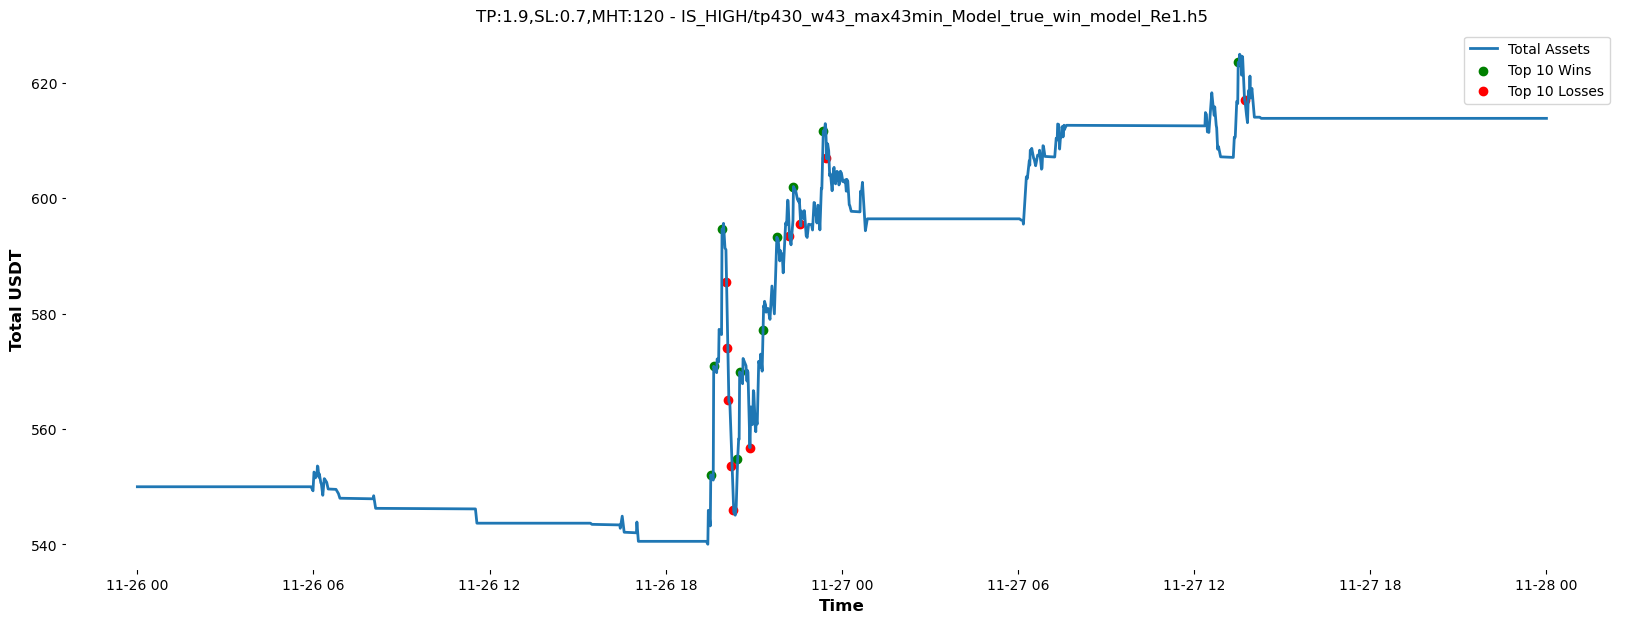

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 615.88 USDT
Profit: 65.88 USDT
Return on Investment (ROI): 11.98%


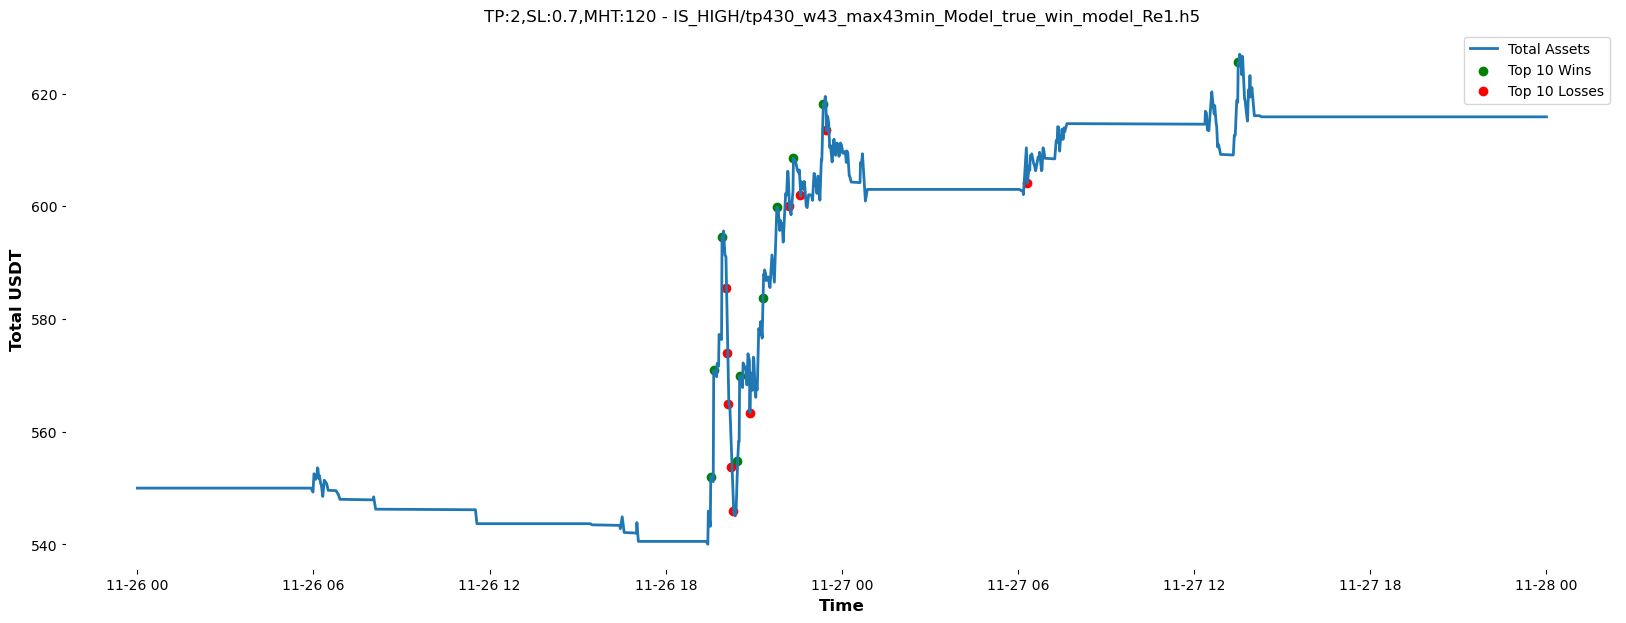

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 631.70 USDT
Profit: 81.70 USDT
Return on Investment (ROI): 14.85%


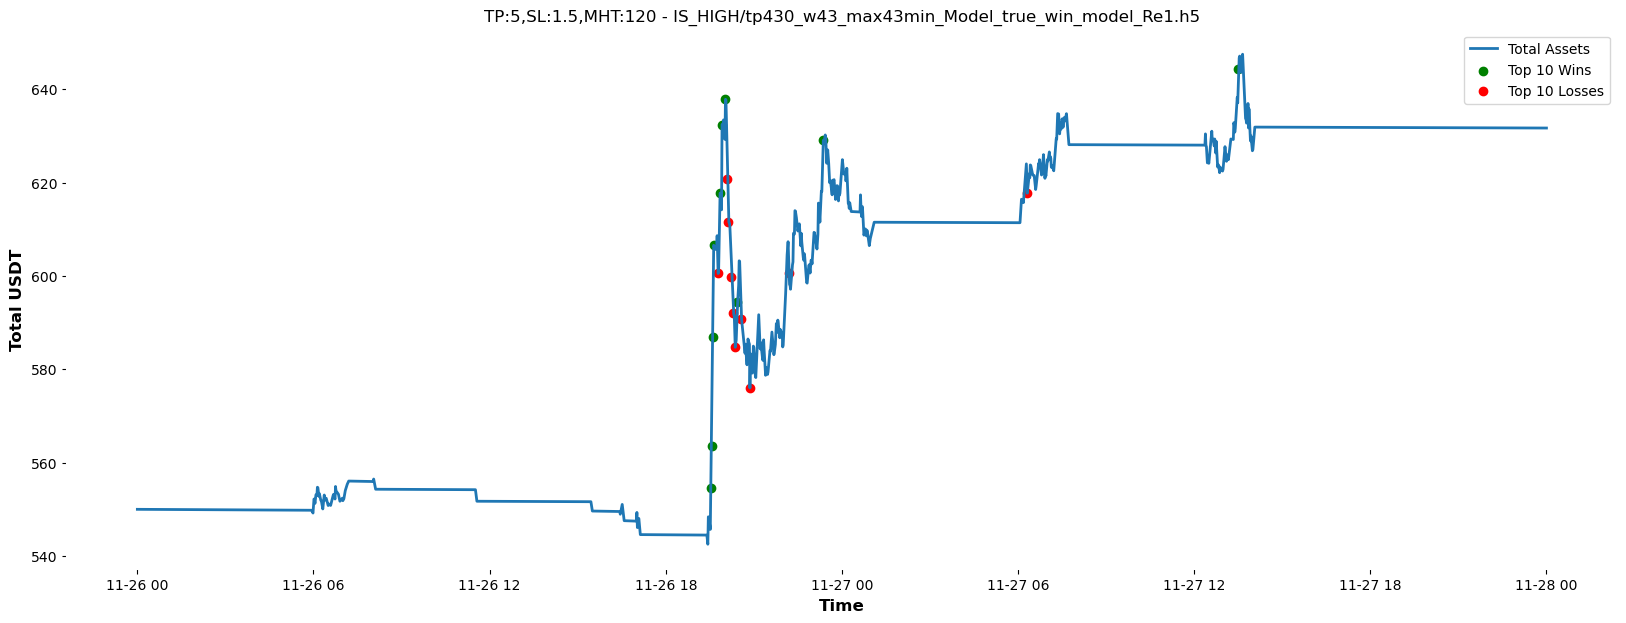

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 627.85 USDT
Profit: 77.85 USDT
Return on Investment (ROI): 14.15%


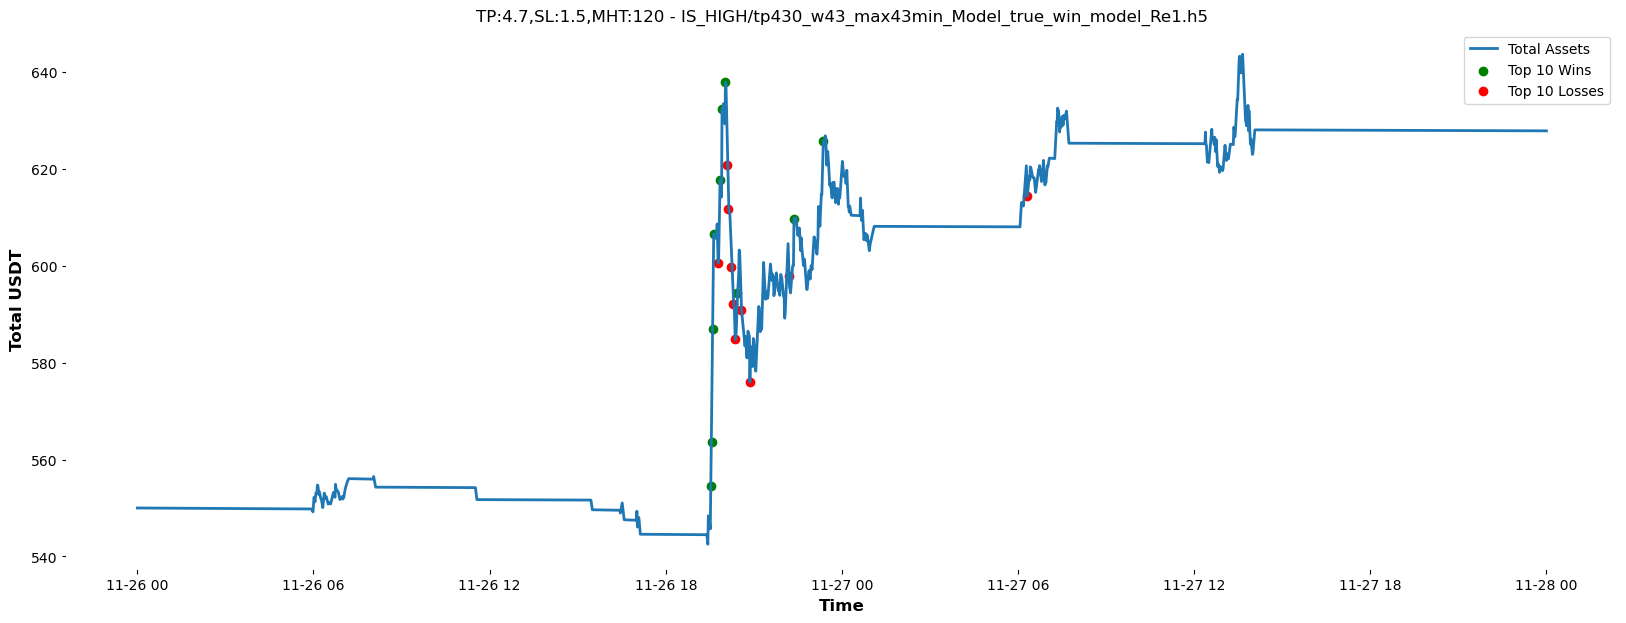

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 608.33 USDT
Profit: 58.33 USDT
Return on Investment (ROI): 10.61%


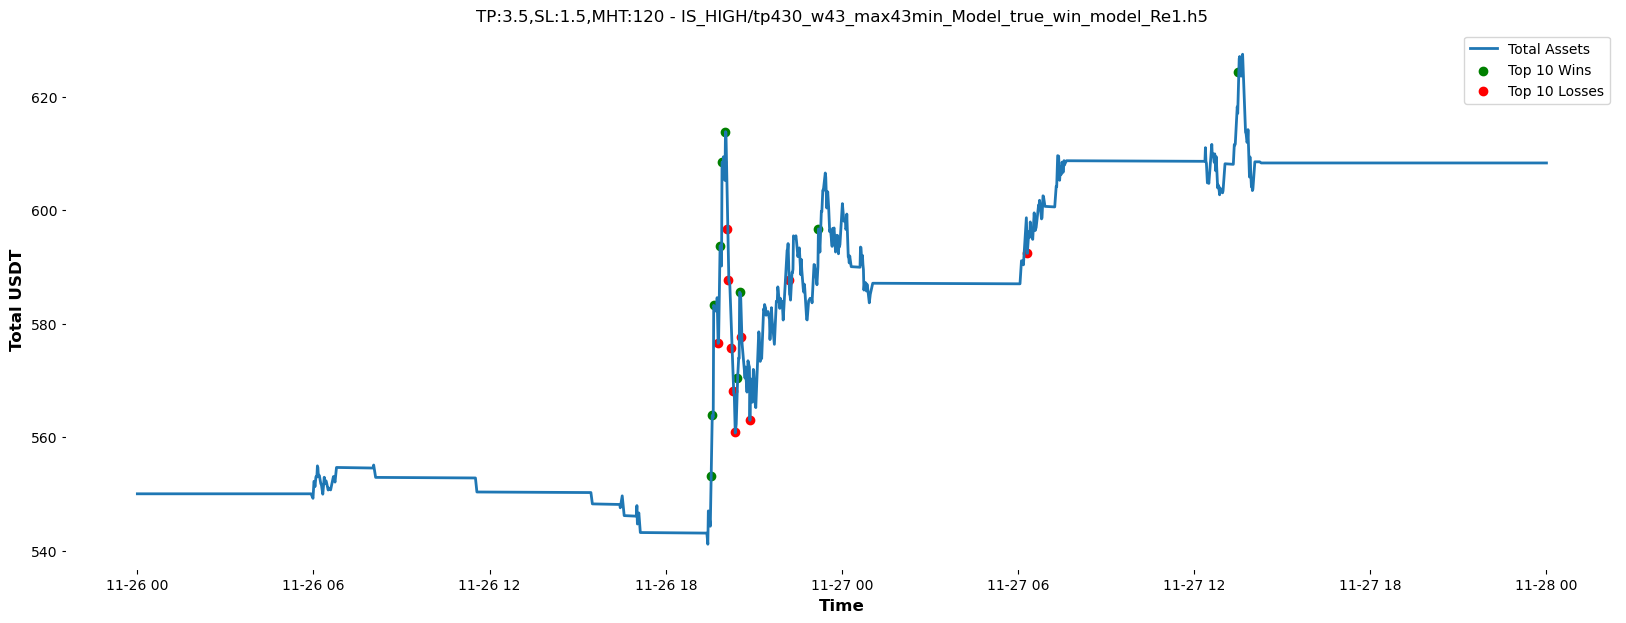

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 583.29 USDT
Profit: 33.29 USDT
Return on Investment (ROI): 6.05%


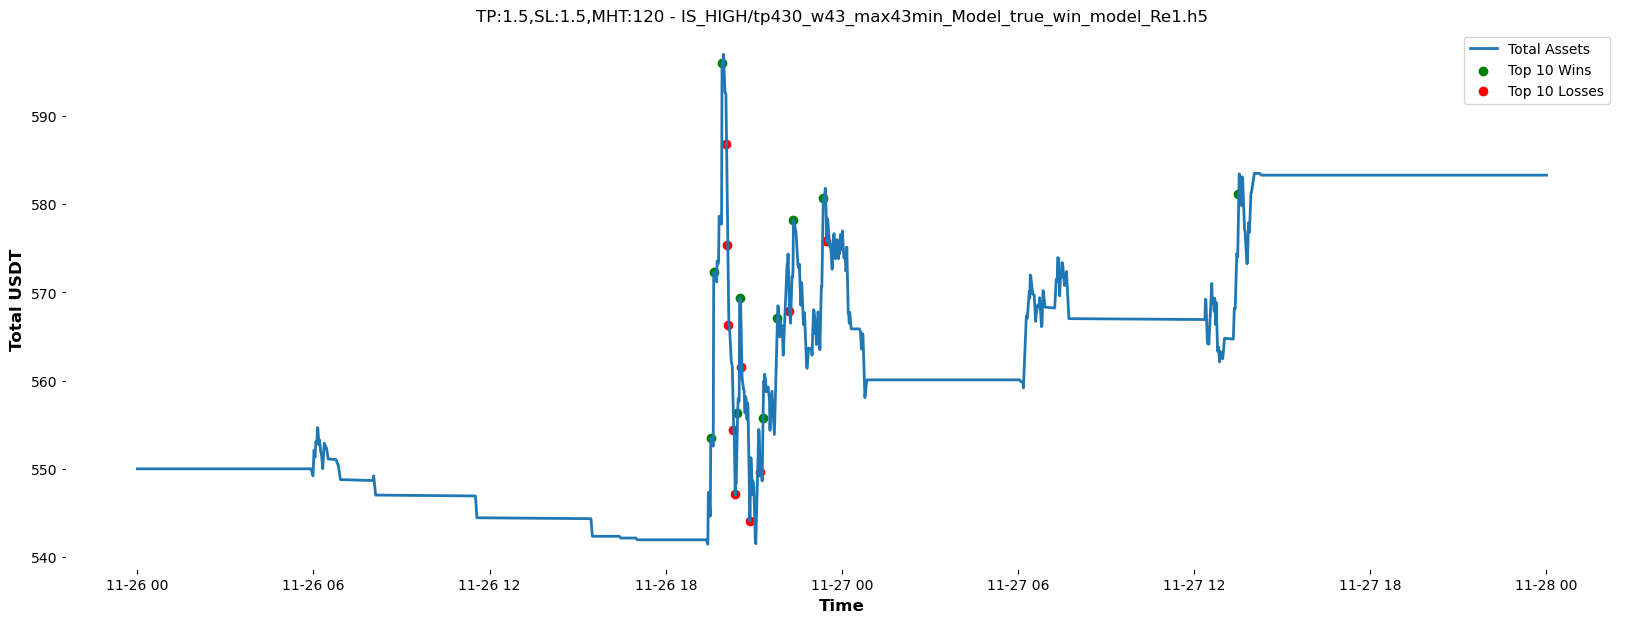

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 576.60 USDT
Profit: 26.60 USDT
Return on Investment (ROI): 4.84%


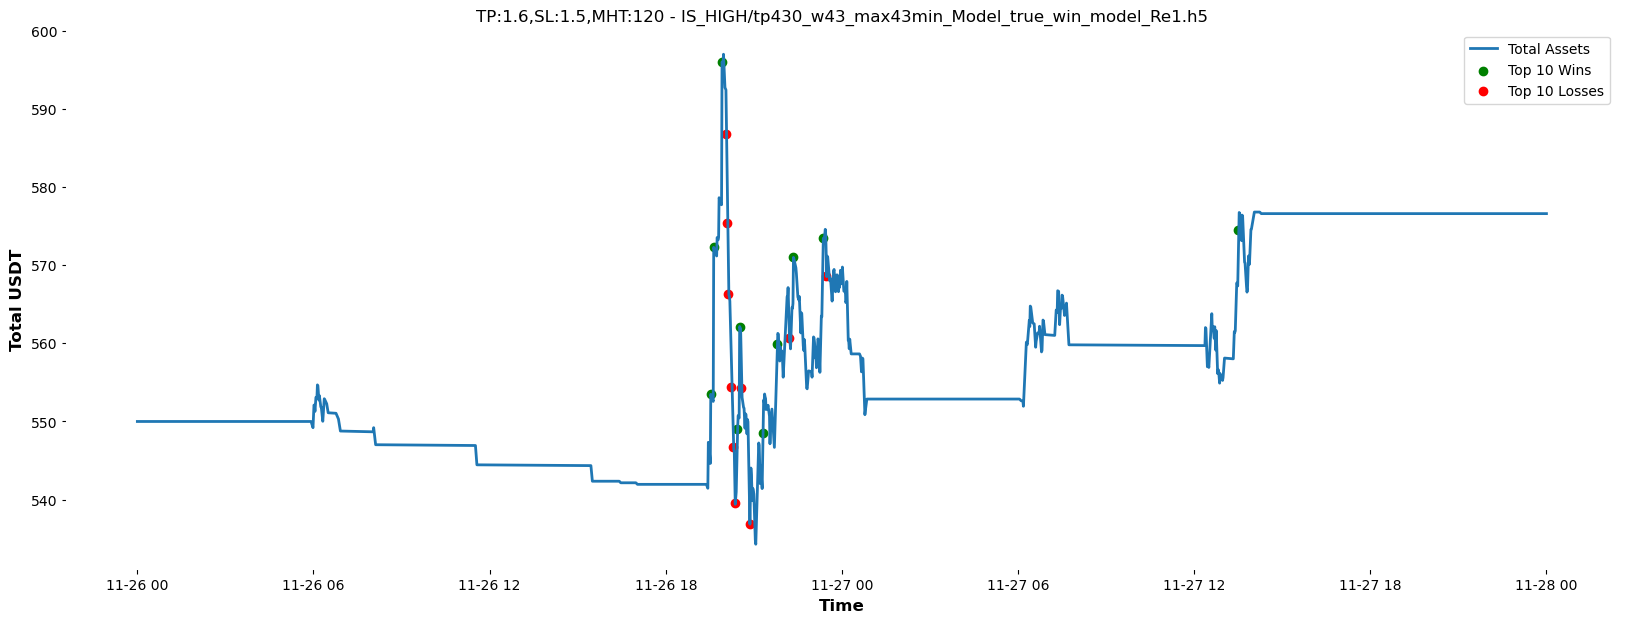

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 547.86 USDT
Profit: -2.14 USDT
Return on Investment (ROI): -0.39%


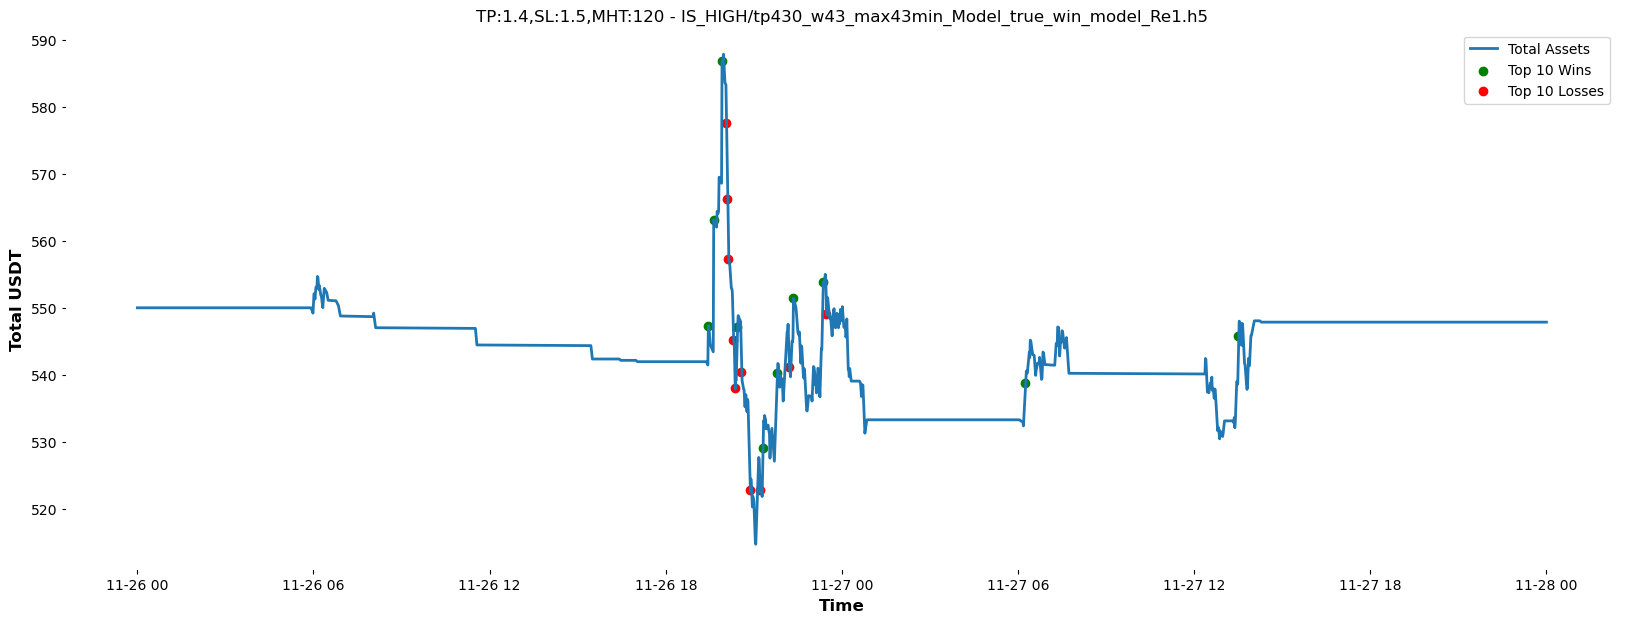

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 573.59 USDT
Profit: 23.59 USDT
Return on Investment (ROI): 4.29%


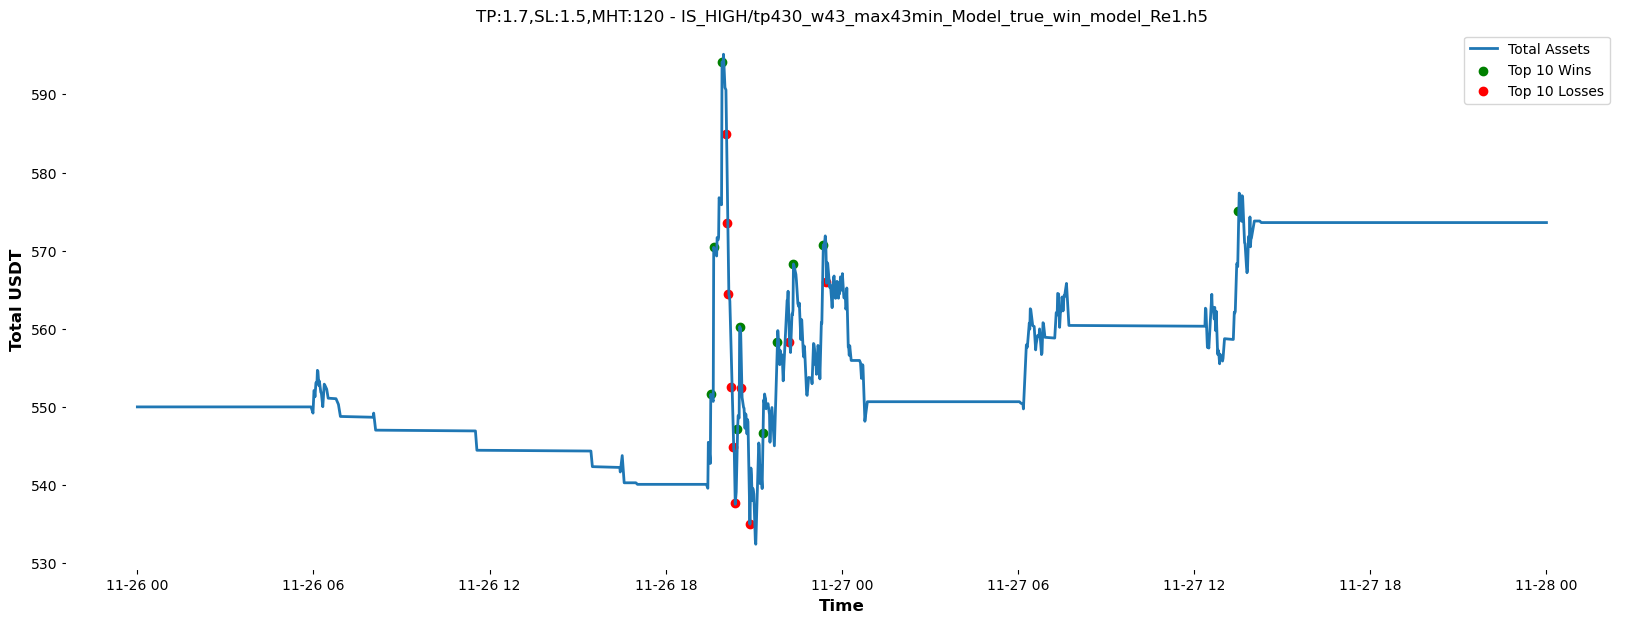

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 574.54 USDT
Profit: 24.54 USDT
Return on Investment (ROI): 4.46%


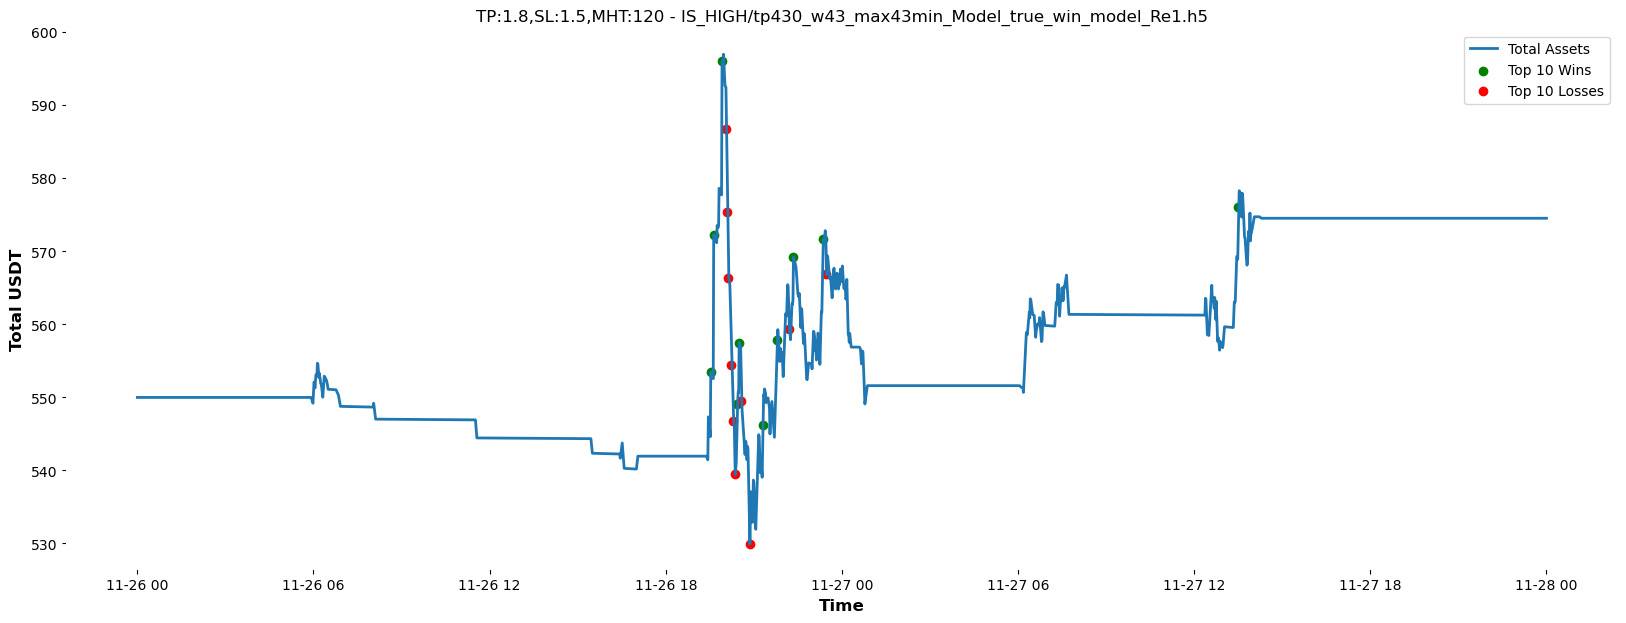

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 577.44 USDT
Profit: 27.44 USDT
Return on Investment (ROI): 4.99%


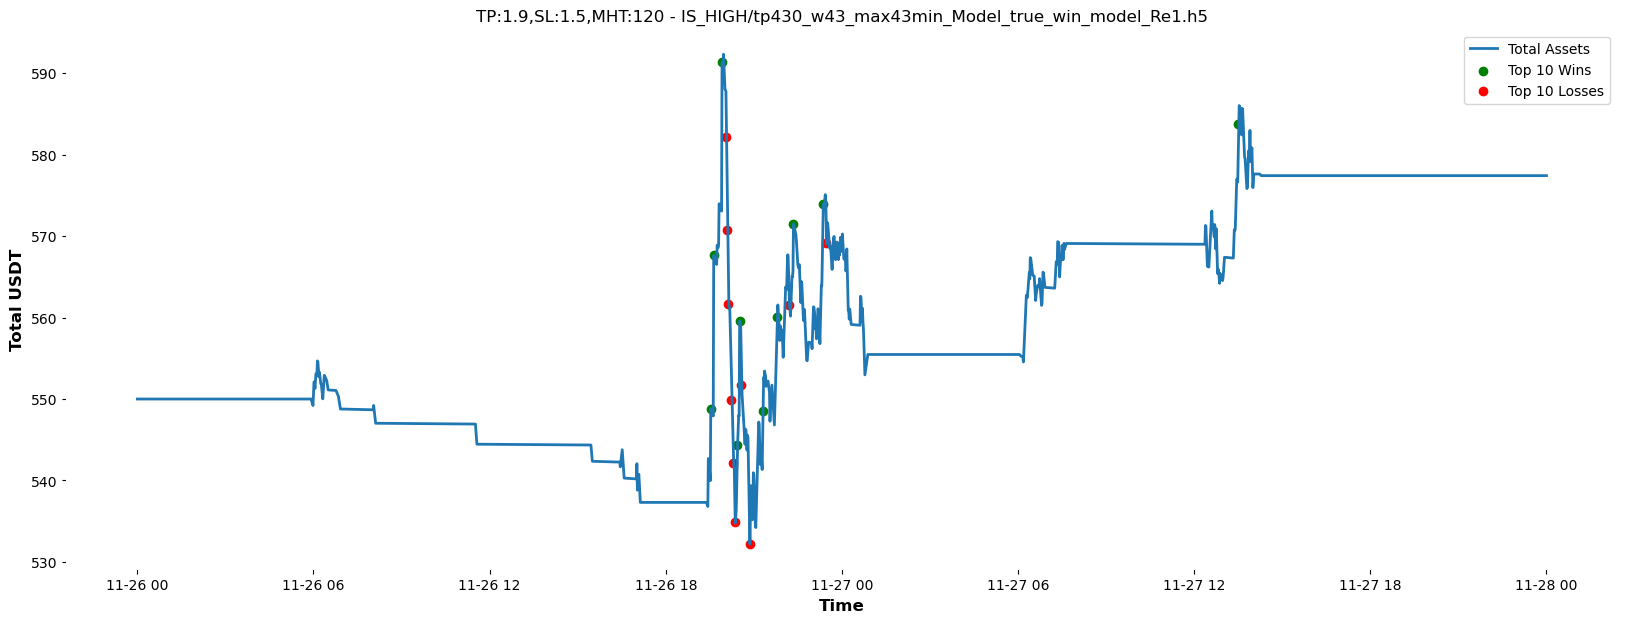

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 577.75 USDT
Profit: 27.75 USDT
Return on Investment (ROI): 5.04%


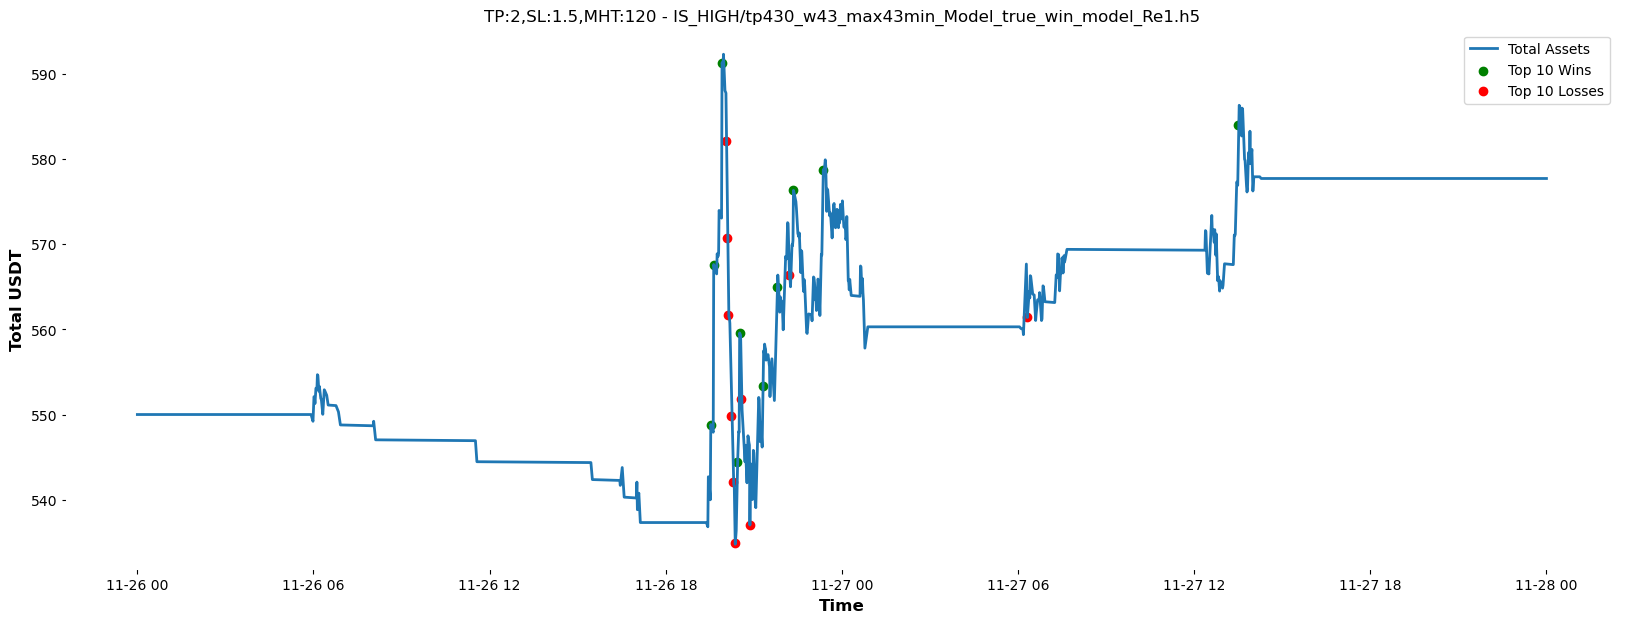

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 621.31 USDT
Profit: 71.31 USDT
Return on Investment (ROI): 12.96%


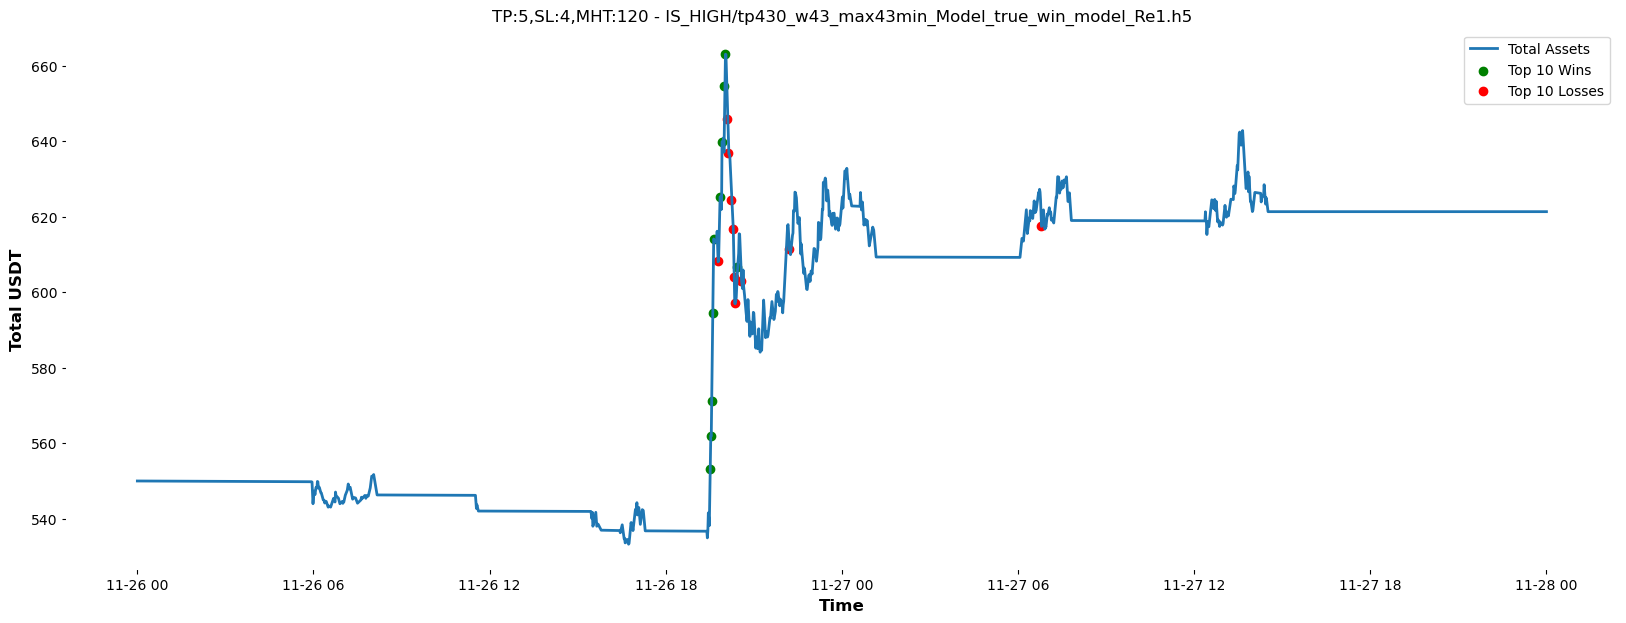

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 604.22 USDT
Profit: 54.22 USDT
Return on Investment (ROI): 9.86%


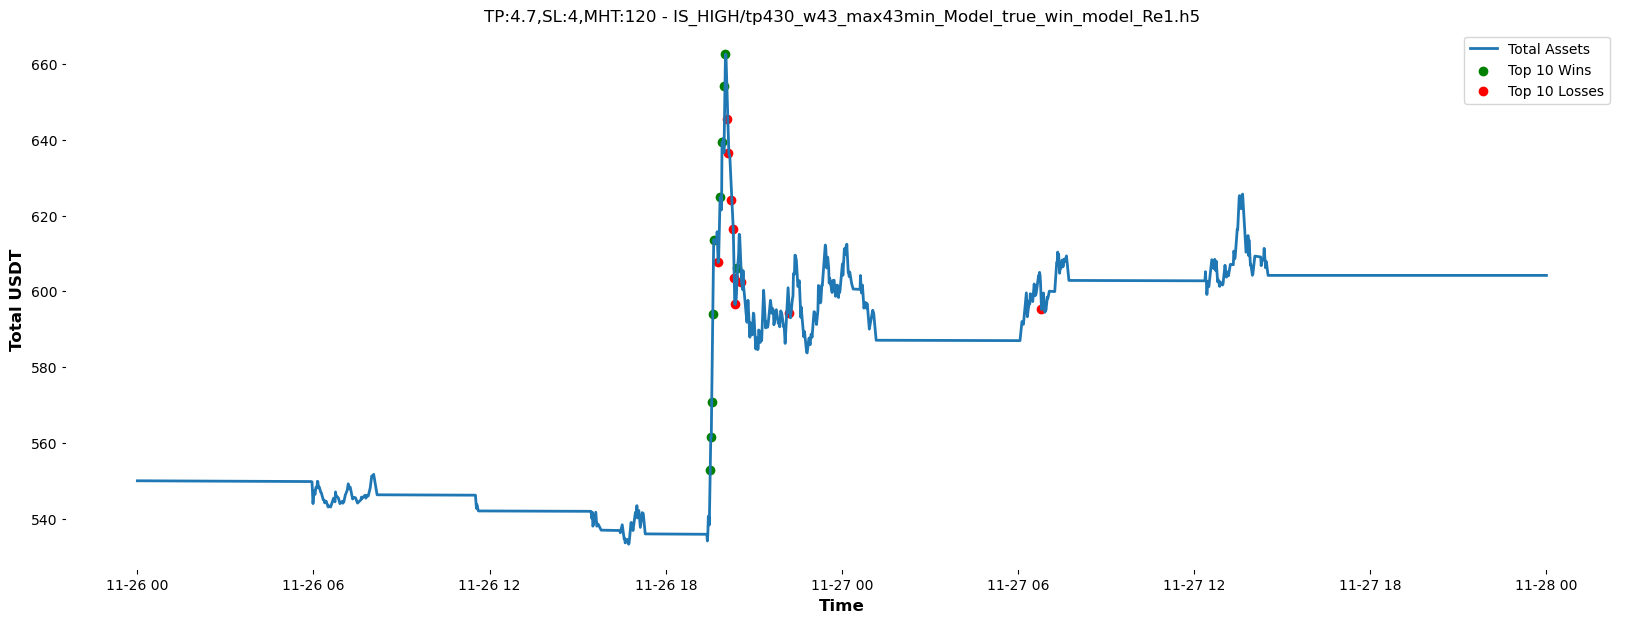

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 595.63 USDT
Profit: 45.63 USDT
Return on Investment (ROI): 8.30%


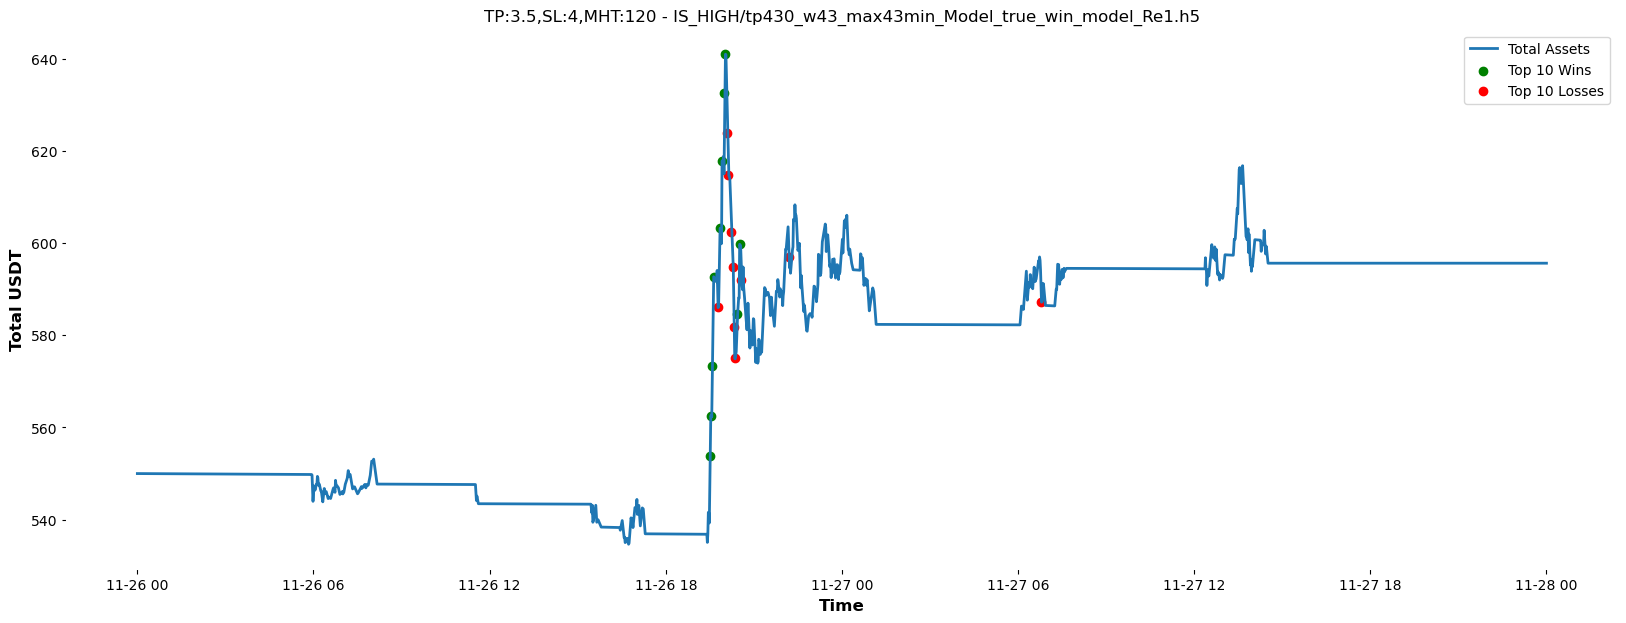

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 567.03 USDT
Profit: 17.03 USDT
Return on Investment (ROI): 3.10%


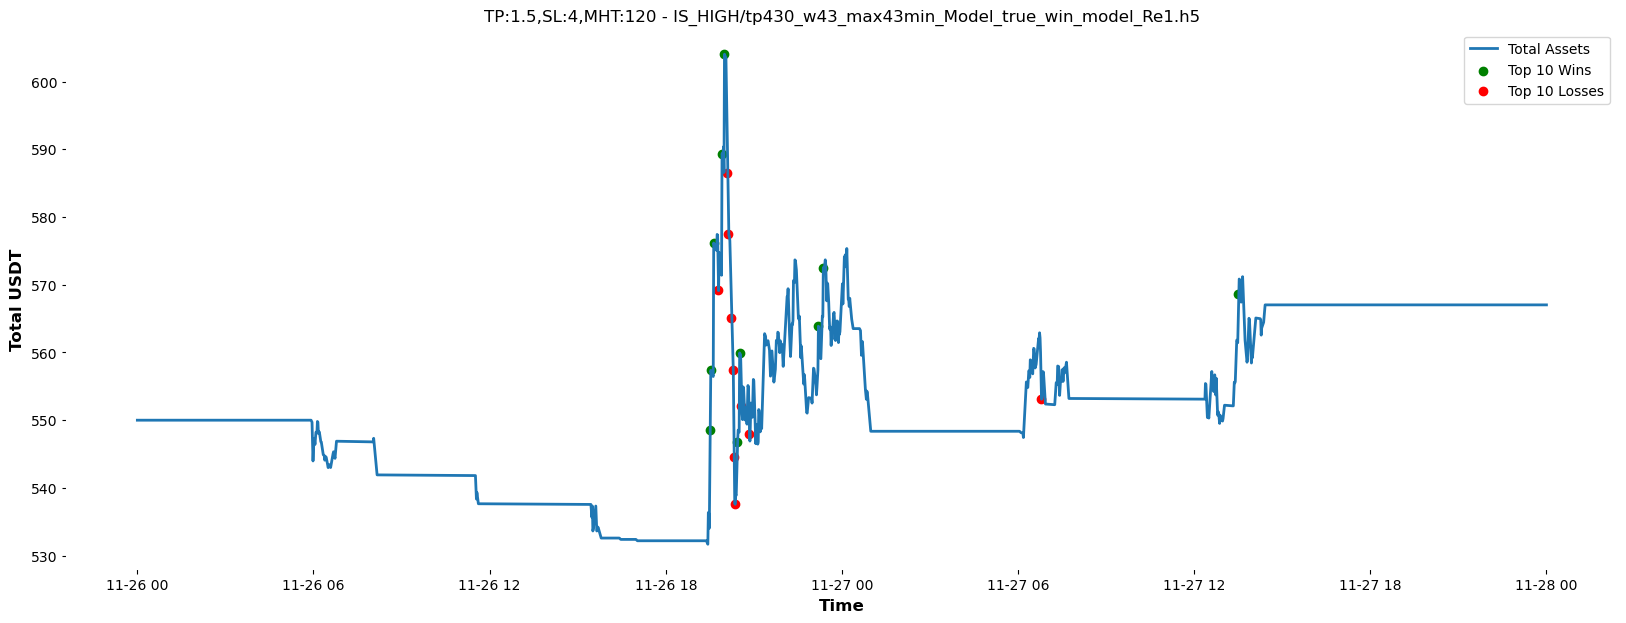

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 569.01 USDT
Profit: 19.01 USDT
Return on Investment (ROI): 3.46%


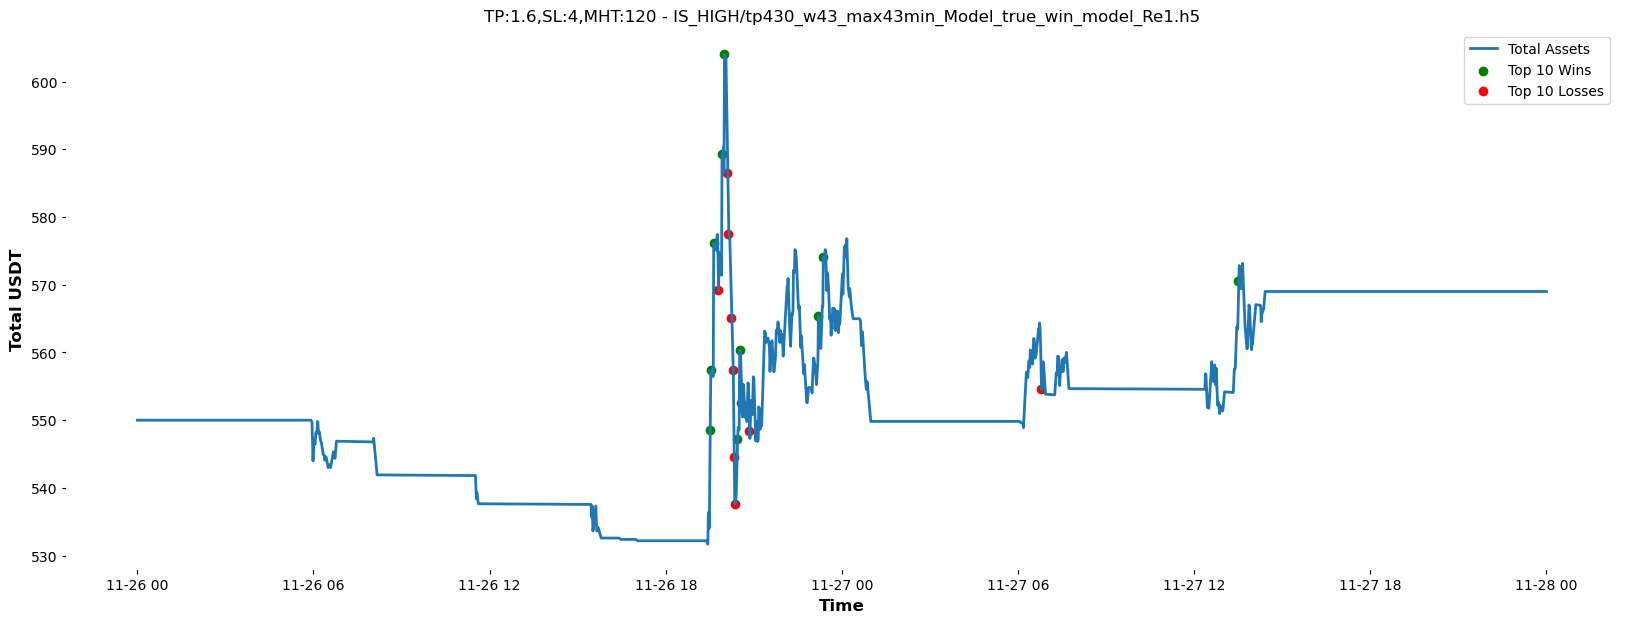

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 529.63 USDT
Profit: -20.37 USDT
Return on Investment (ROI): -3.70%


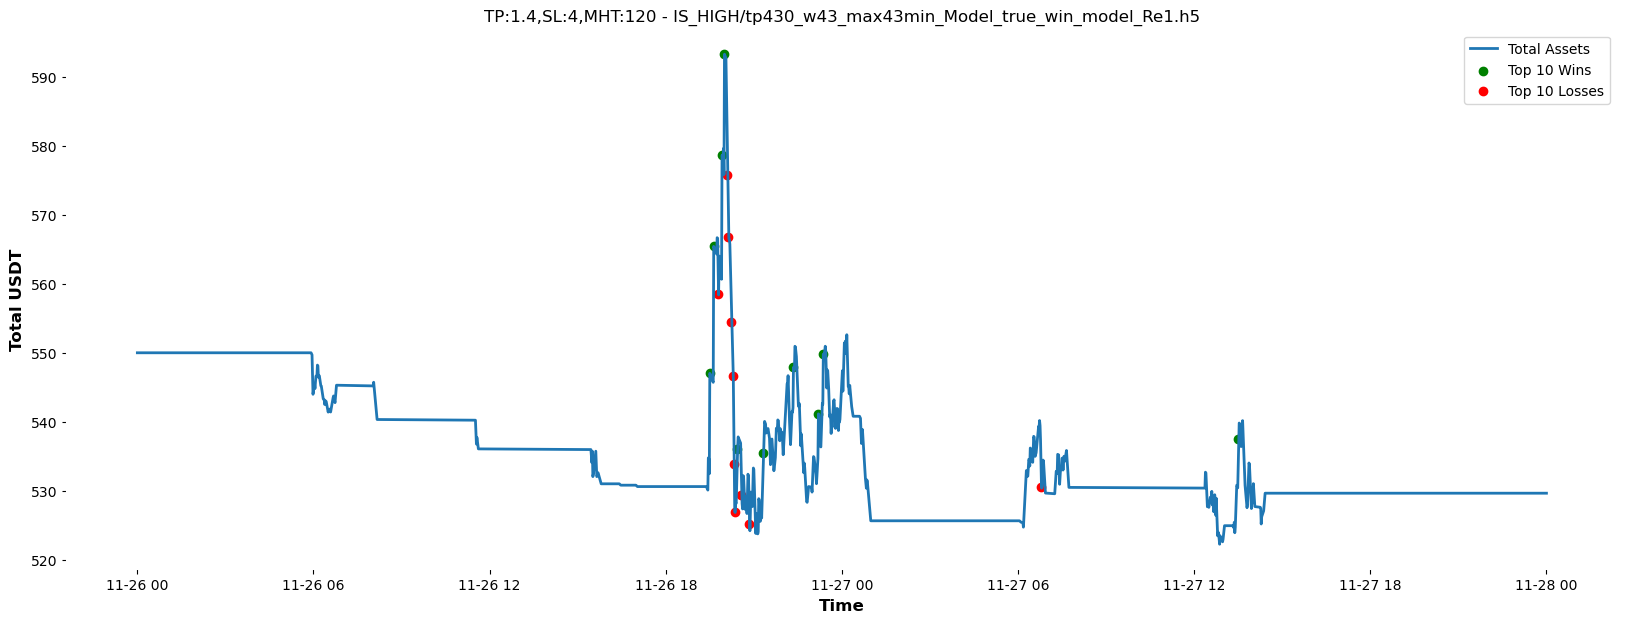

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 563.96 USDT
Profit: 13.96 USDT
Return on Investment (ROI): 2.54%


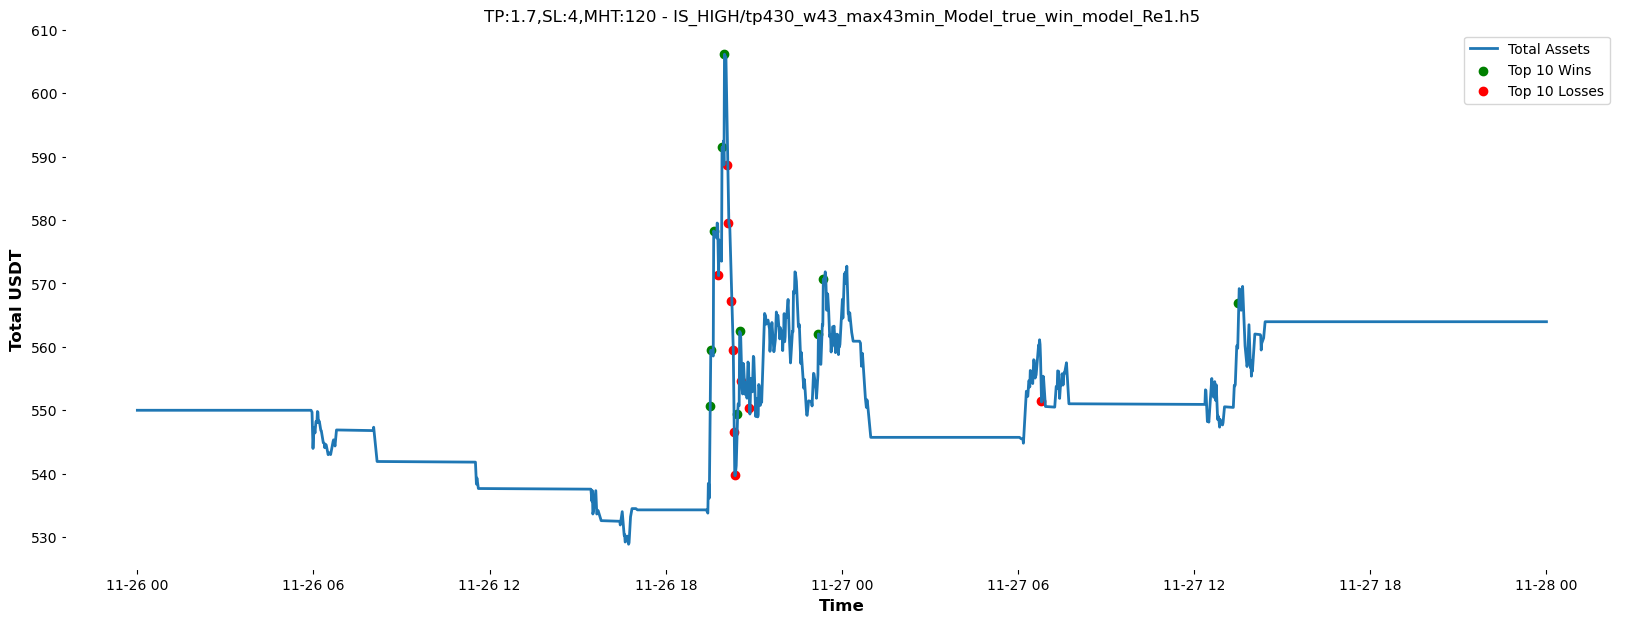

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 563.83 USDT
Profit: 13.83 USDT
Return on Investment (ROI): 2.52%


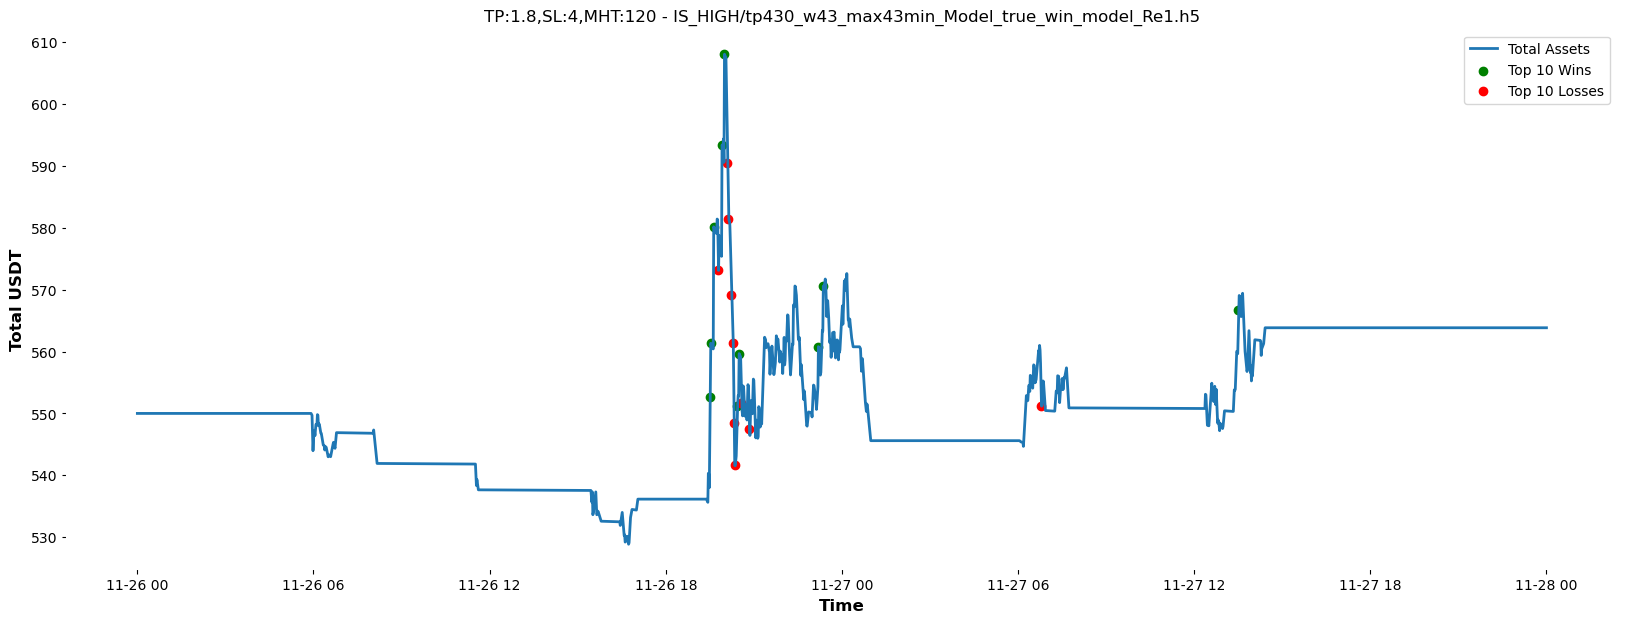

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 577.05 USDT
Profit: 27.05 USDT
Return on Investment (ROI): 4.92%


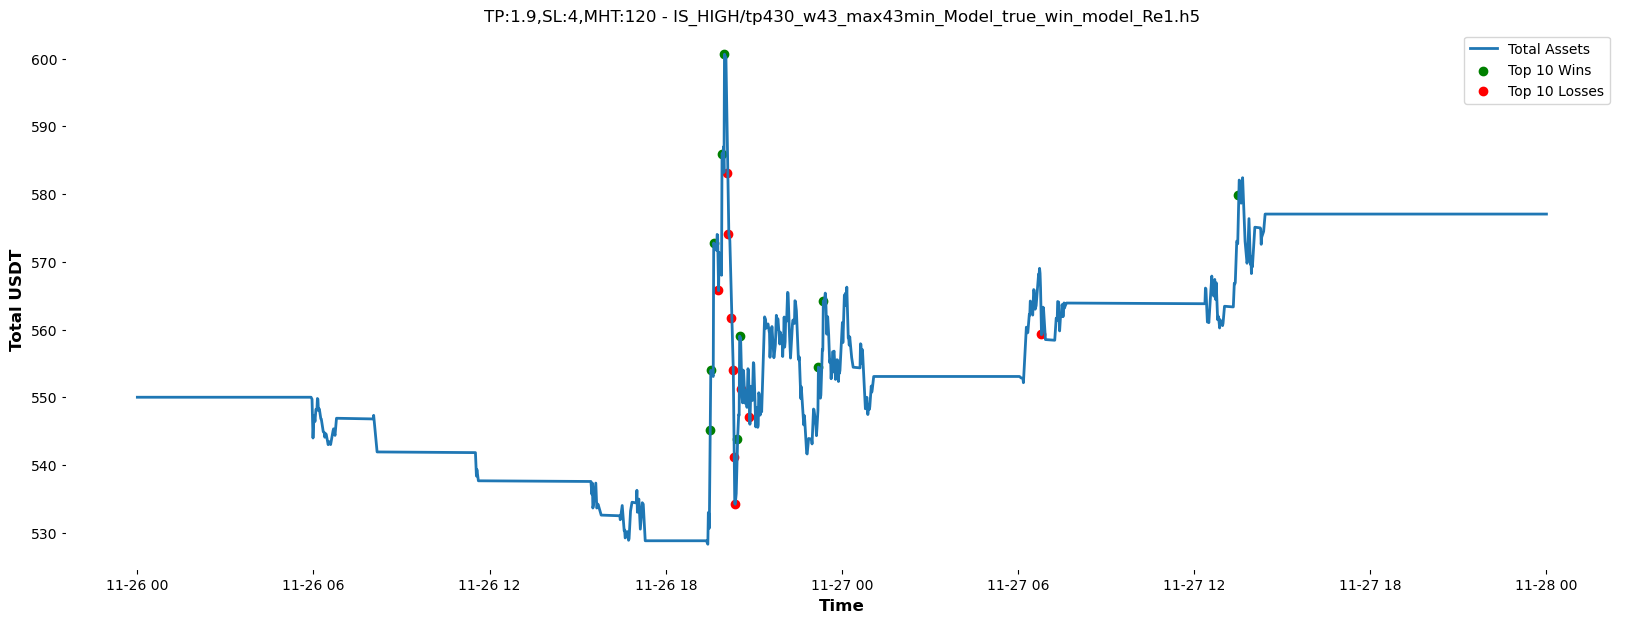

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 578.16 USDT
Profit: 28.16 USDT
Return on Investment (ROI): 5.12%


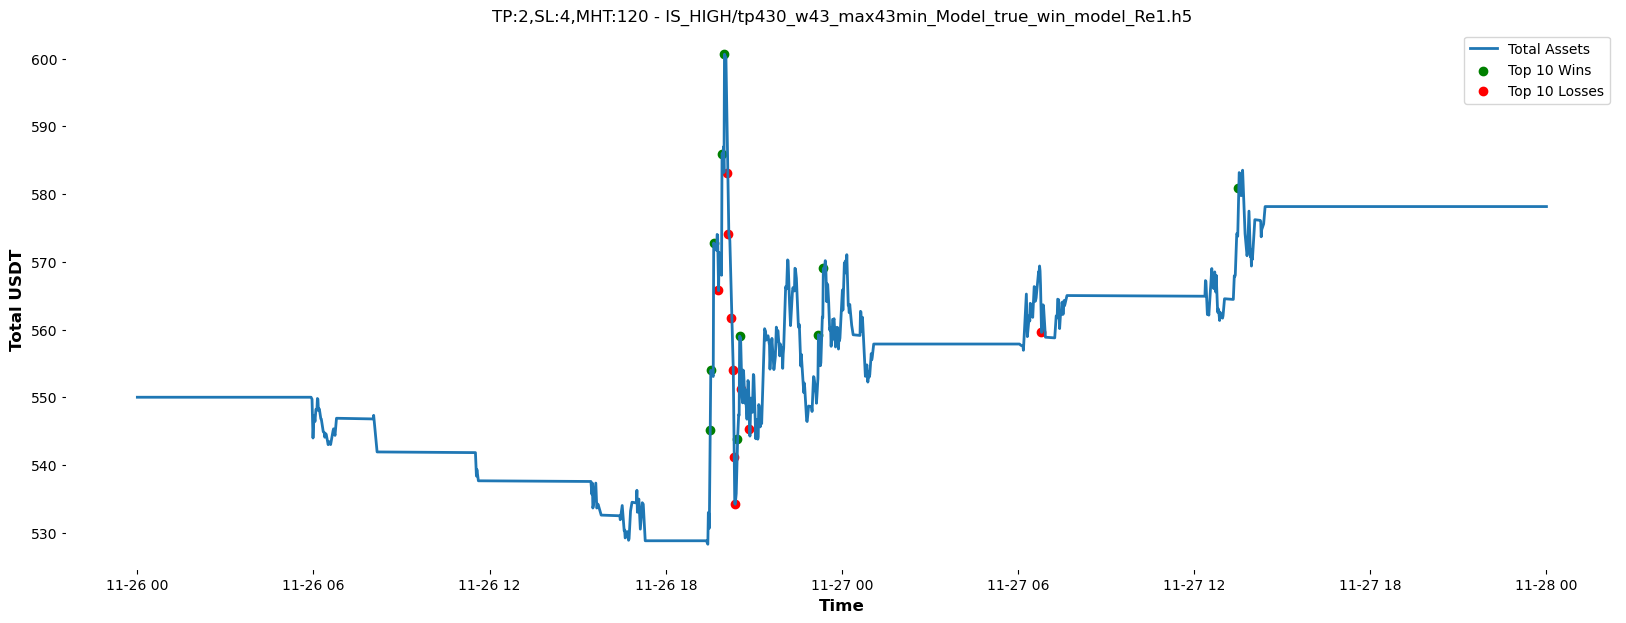

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 635.18 USDT
Profit: 85.18 USDT
Return on Investment (ROI): 15.49%


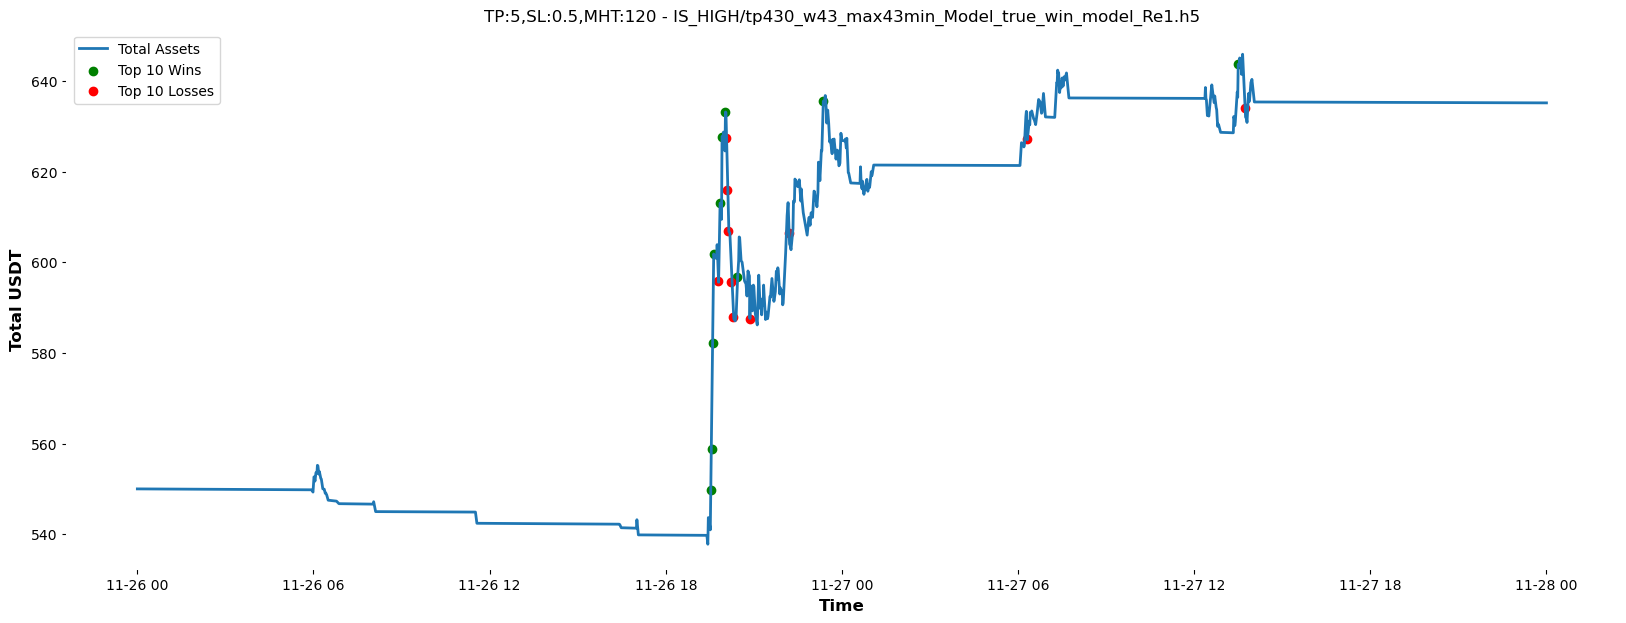

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 641.18 USDT
Profit: 91.18 USDT
Return on Investment (ROI): 16.58%


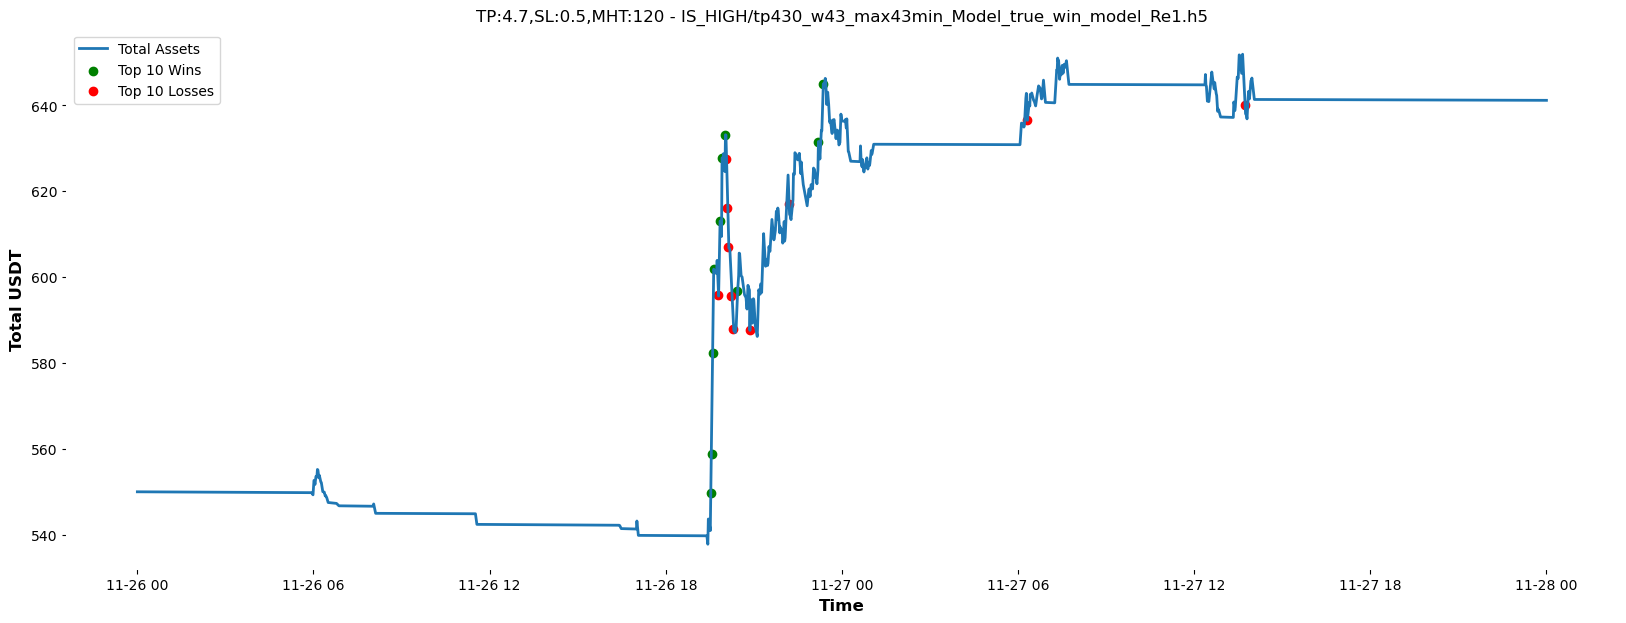

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 614.47 USDT
Profit: 64.47 USDT
Return on Investment (ROI): 11.72%


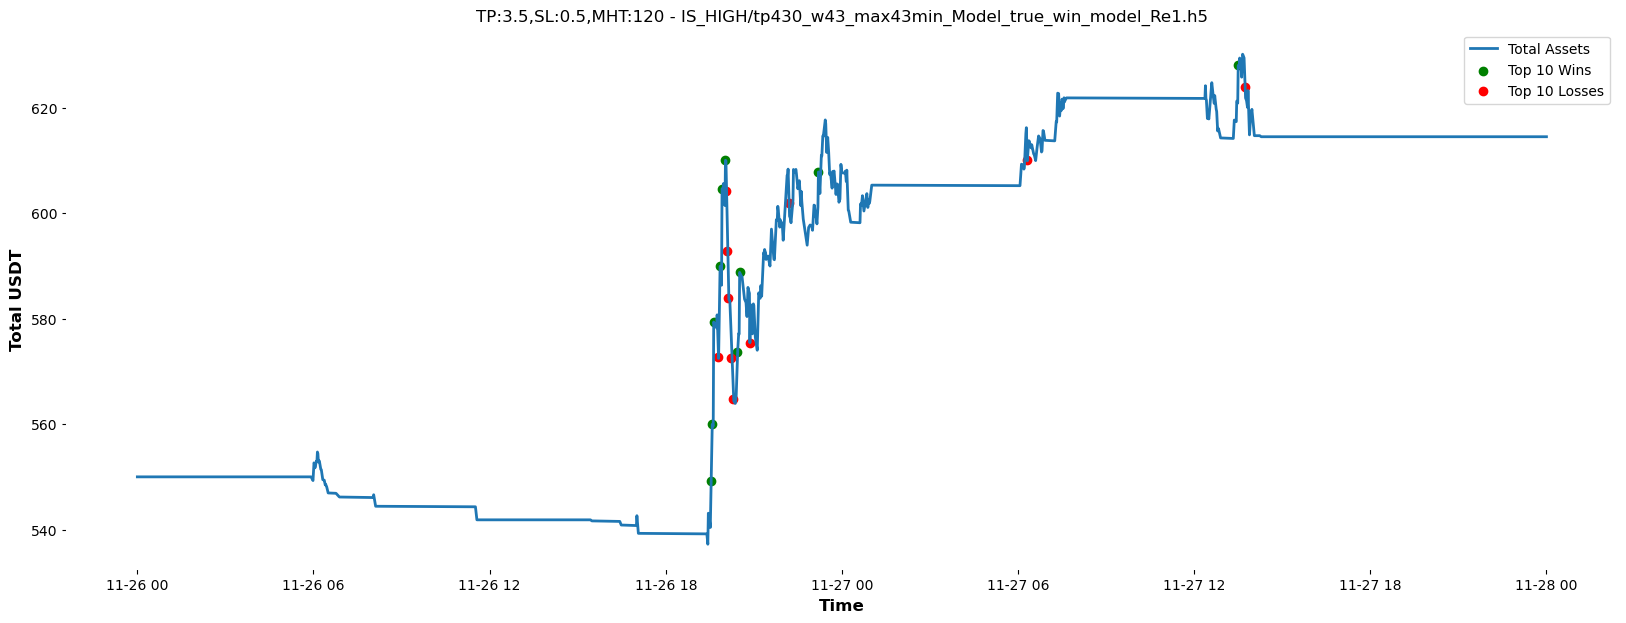

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 597.81 USDT
Profit: 47.81 USDT
Return on Investment (ROI): 8.69%


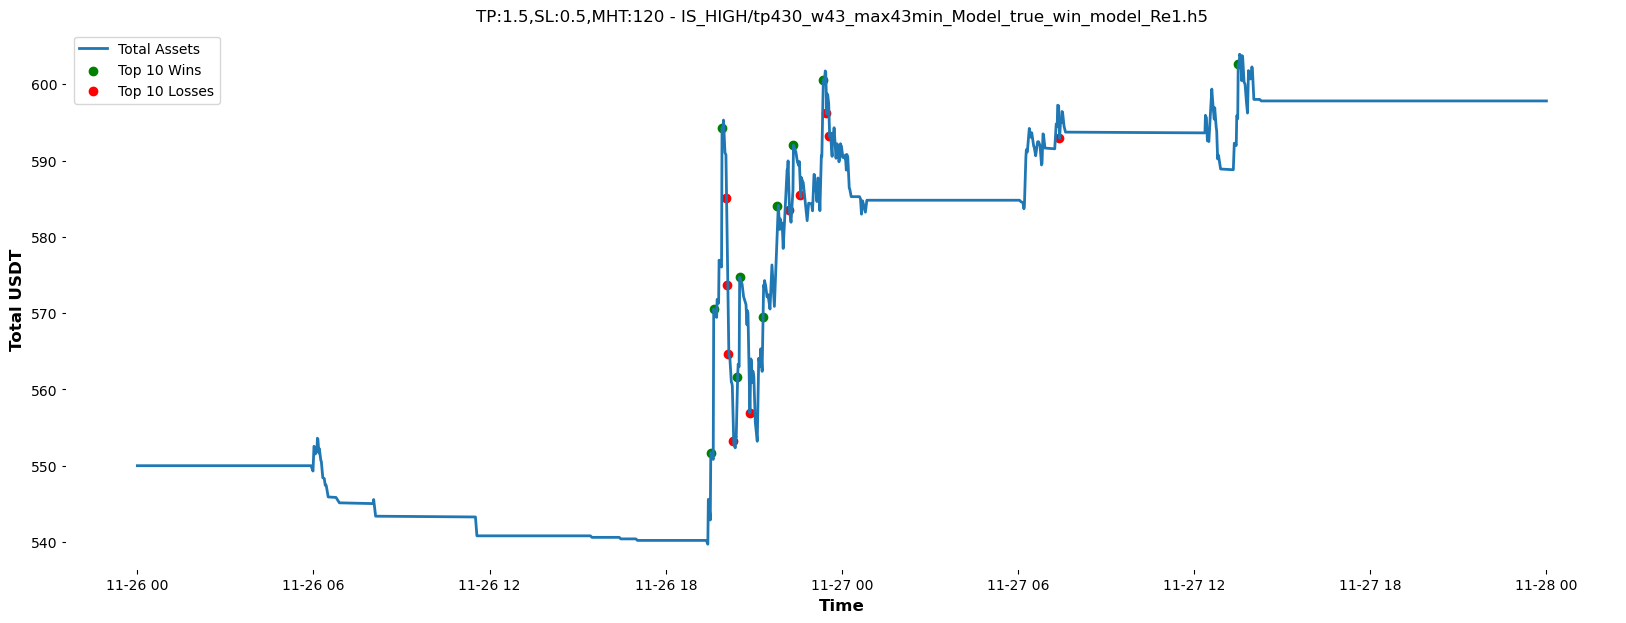

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 594.70 USDT
Profit: 44.70 USDT
Return on Investment (ROI): 8.13%


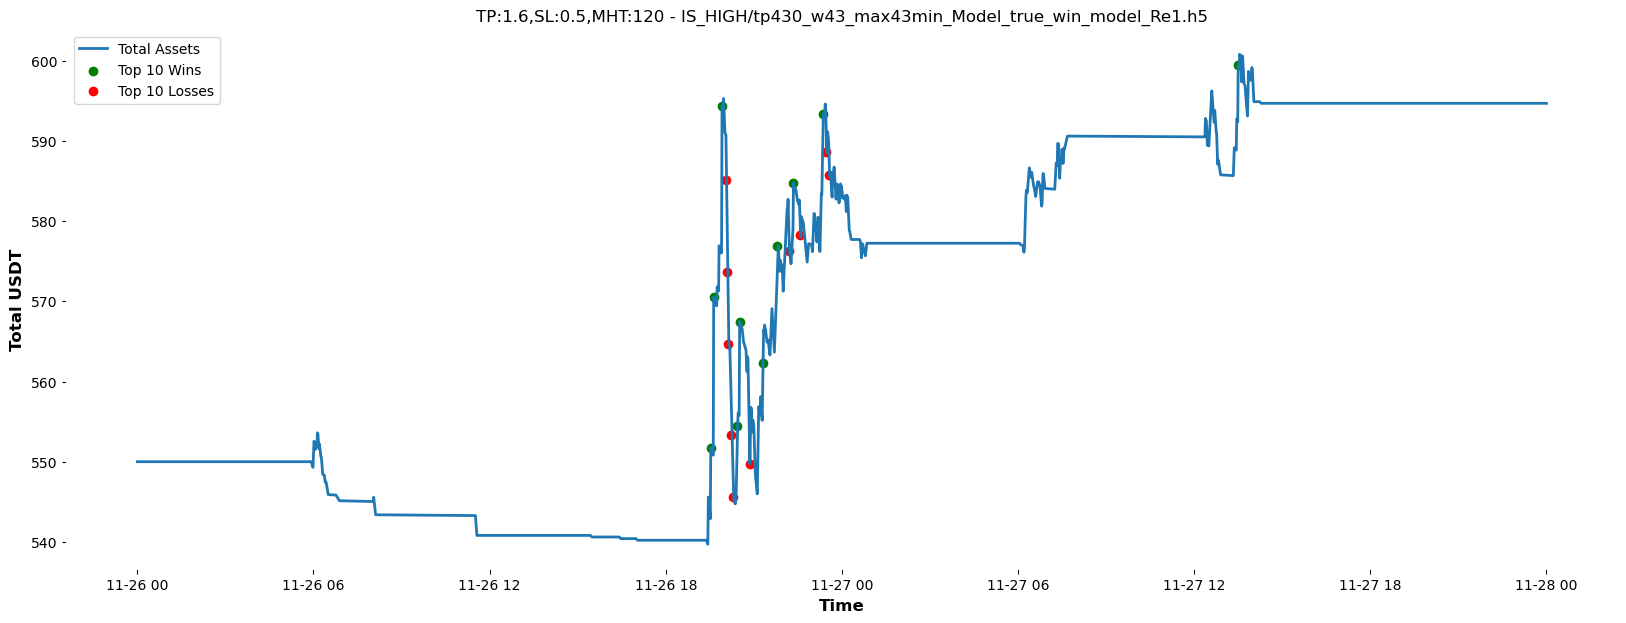

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 563.85 USDT
Profit: 13.85 USDT
Return on Investment (ROI): 2.52%


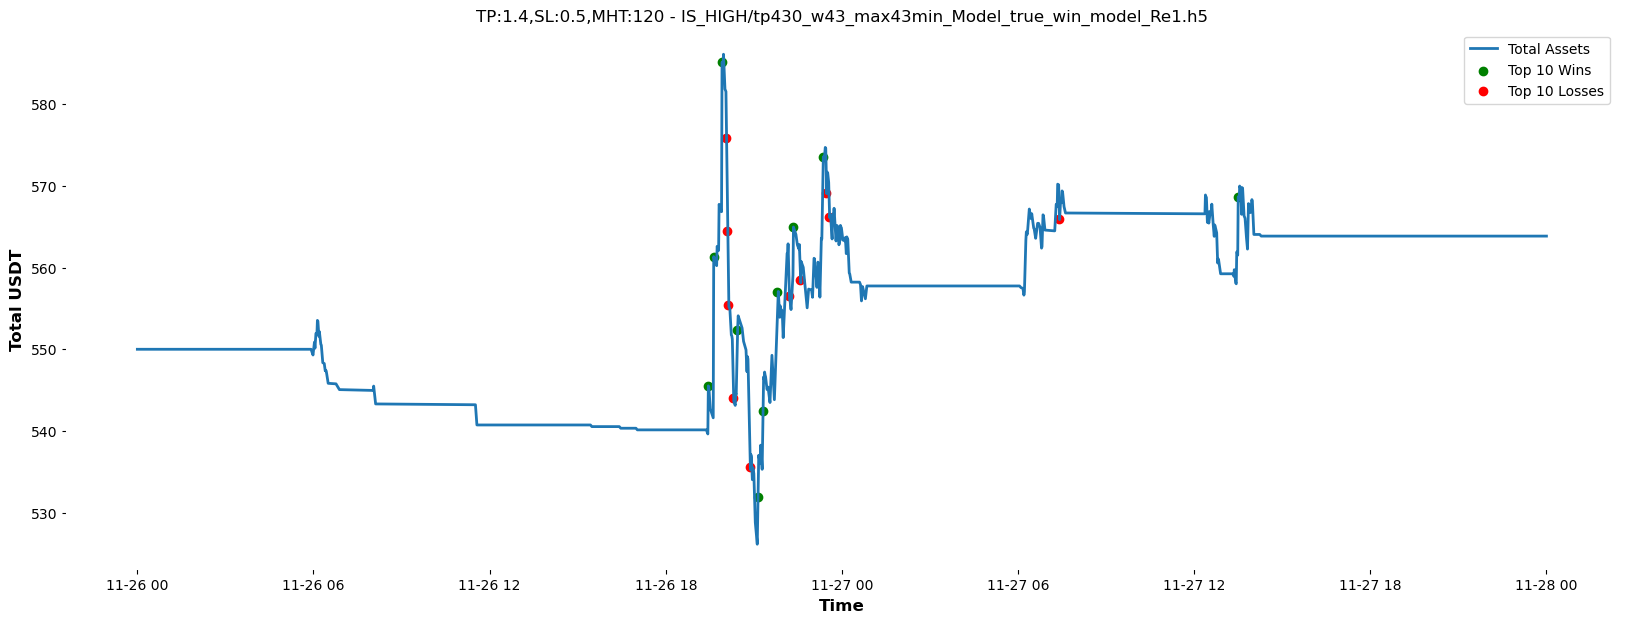

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 588.02 USDT
Profit: 38.02 USDT
Return on Investment (ROI): 6.91%


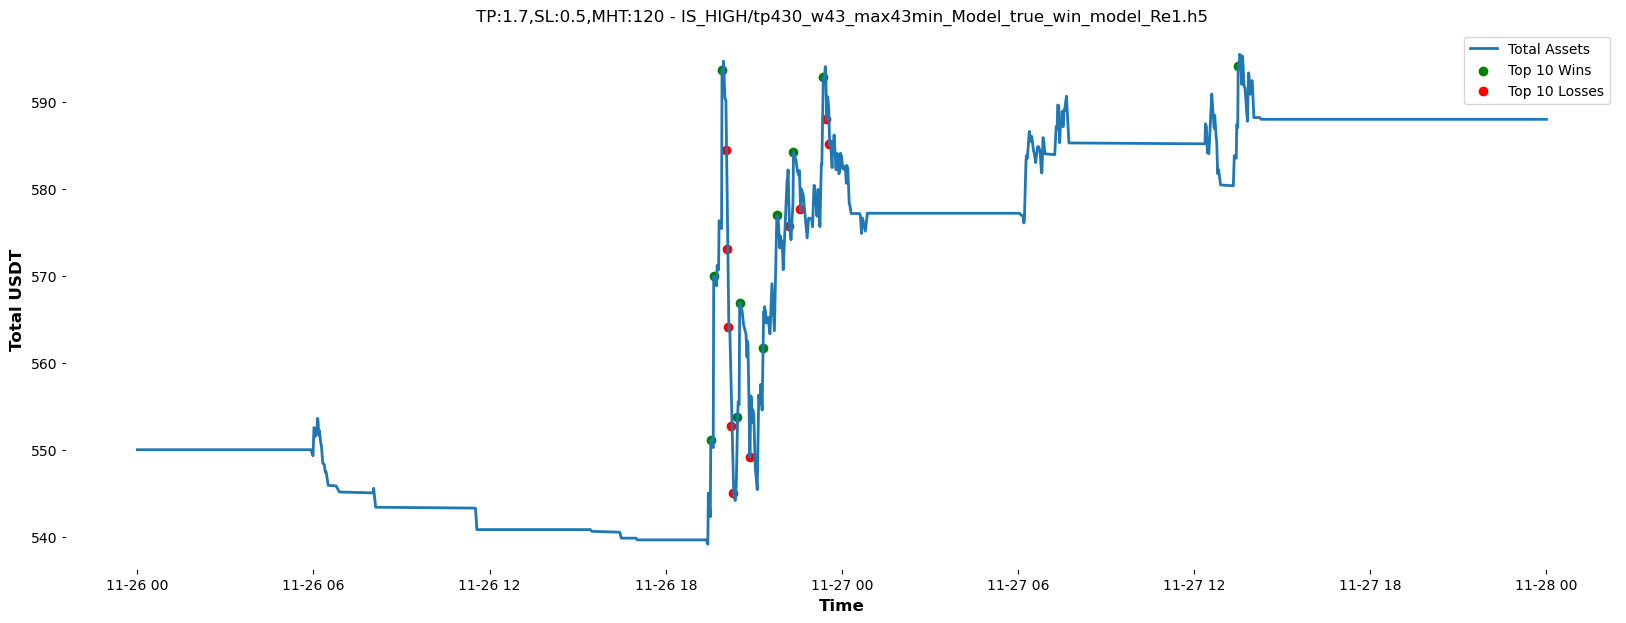

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 588.90 USDT
Profit: 38.90 USDT
Return on Investment (ROI): 7.07%


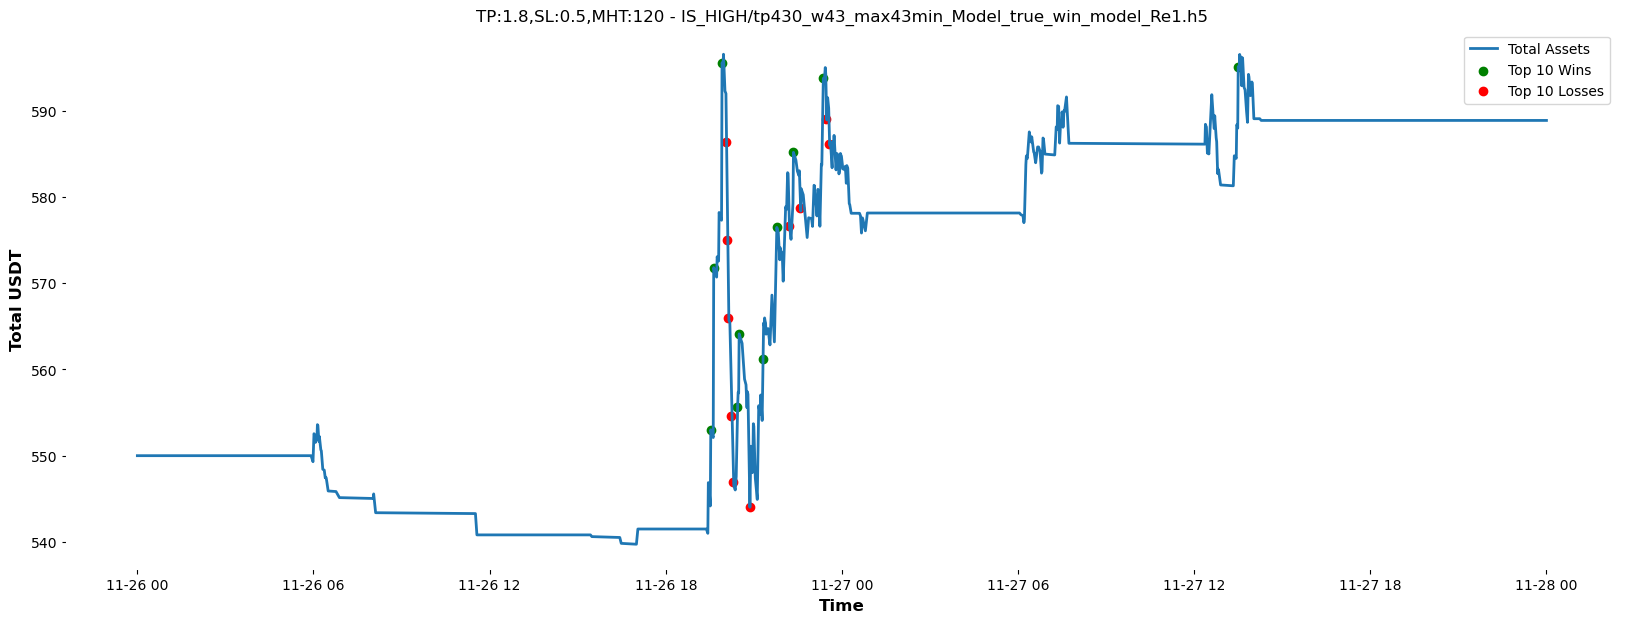

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 599.95 USDT
Profit: 49.95 USDT
Return on Investment (ROI): 9.08%


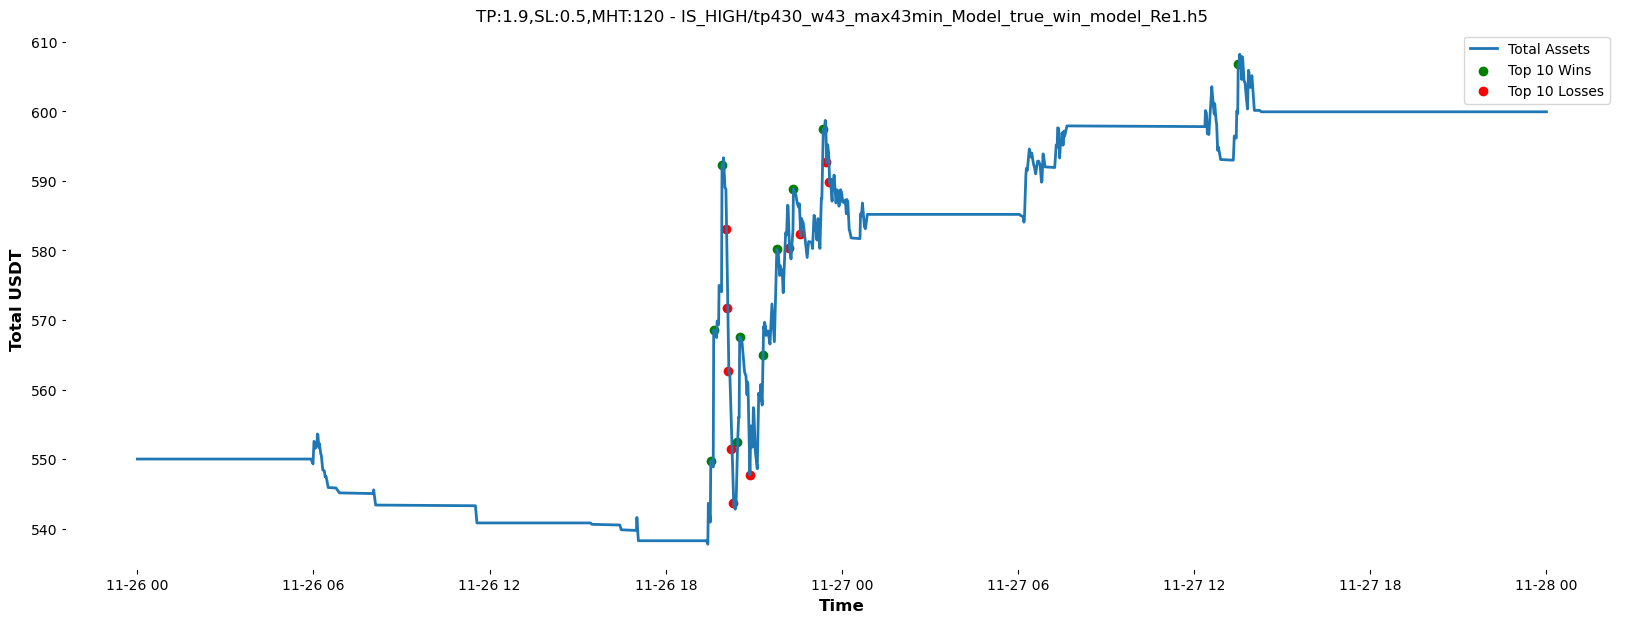

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv
-------- ---------------------- MAX_HOLDING_TIME = 120  ---------------------------------
Initial Investment: 550.00 USDT
Final Value: 600.24 USDT
Profit: 50.24 USDT
Return on Investment (ROI): 9.13%


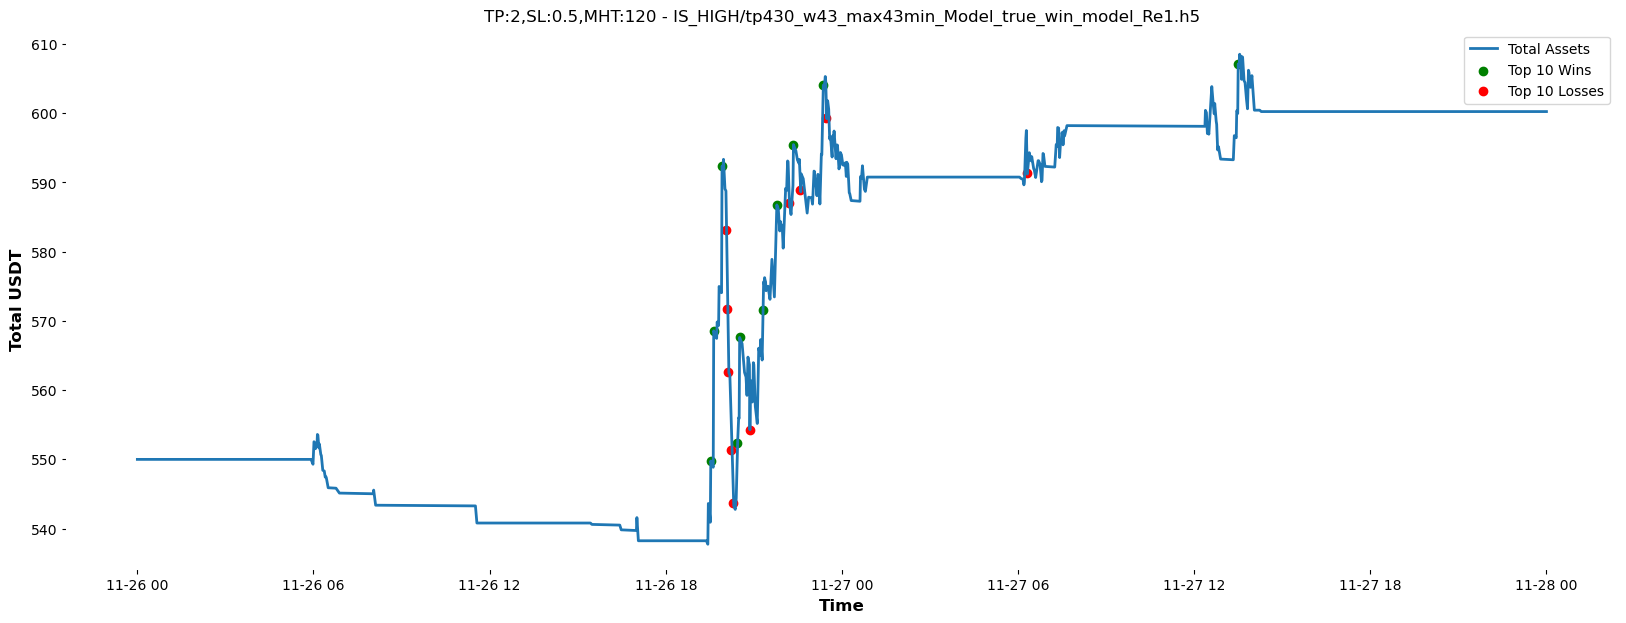

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/test_all_models_between_2022-11-26--2022-11-28.csv


In [35]:
## Multi MHT
PRECISION = -0.0
DEBUG=False
PDEBUG=False
Model_FileName="/UltimeTradingBot/Data/IS_HIGH/tp430_w43_max43min_Model_true_win_model_Re1.h5"

USE_TRAILING_STOP_LOSS= False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
model_file=Model_FileName
print(f"Testing model: {model_file} ")
backtest_model=load_model(Model_FileName)
SIGNAL_DF = generate_signals_costum(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)


for STOP_LOSS in [0.7,1.5,4,0.5]:
    for TAKE_PROFIT in [5,4.7,3.5,1.5,1.6,1.4,1.7,1.8,1.9,2]:
        for t in [120]:
            MAX_HOLDING_TIME=t
            print(f'-------- ---------------------- MAX_HOLDING_TIME = {MAX_HOLDING_TIME}  ---------------------------------') 
            ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
            TRAILING_DATA=pd.DataFrame()
            PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
            Mname=Model_FileName.split('Data/')[1]
            metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
            win,loss=calculate_wins_losses(ORDER_HISTORY)
            tt2=save_results(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME)


In [89]:
Sigcoin=SIGNAL_DF[SIGNAL_DF.coin=="DOGE/USDT"]

In [94]:
Sigcoin_shifted=Sigcoin.shift(3)

0                 NaT
1                 NaT
2                 NaT
3     0 days 00:03:00
4     0 days 00:03:00
            ...      
201   0 days 00:09:00
202   0 days 00:09:00
203   0 days 00:11:00
204   0 days 00:05:00
205   0 days 00:05:00
Name: time, Length: 982, dtype: timedelta64[ns]

In [95]:
Sigcoin.time-Sigcoin_shifted.time

0                 NaT
1                 NaT
2                 NaT
3     0 days 00:03:00
4     0 days 00:03:00
            ...      
201   0 days 00:09:00
202   0 days 00:09:00
203   0 days 00:11:00
204   0 days 00:05:00
205   0 days 00:05:00
Name: time, Length: 982, dtype: timedelta64[ns]

In [ ]:
## Tp == Sl
DEBUG=False
PDEBUG=False
MAX_HOLDING_TIME=80
Model_FileName="/UltimeTradingBot/Data/IS_CLOSE/tp170_w40_max40min_Model_VeryDeep.h5"

USE_TRAILING_STOP_LOSS= False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.0
model_file=Model_FileName
print(f"Testing model: {model_file} ")
backtest_model=load_model(Model_FileName)
SIGNAL_DF = generate_signals_costum(Mini_ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
for i in range(1,30):
    TAKE_PROFIT= 0.2 + i/10 
    STOP_LOSS= 0.2 + i/10 

    print(f'-------- ---------------------- TAKE_PROFIT = {TAKE_PROFIT}  ---------------------------------') 
    PRECISION = -0.0


    ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
    TRAILING_DATA=pd.DataFrame()
    PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
    metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
    win,loss=calculate_wins_losses(ORDER_HISTORY)
    tt6=save_results(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME)


In [ ]:
### Multi TP
DEBUG=False
PDEBUG=False
MAX_HOLDING_TIME=60*4
Model_FileName="/UltimeTradingBot/Data/IS_CLOSE/tp170_w40_max40min_Model_true_win_model_Re2.h5" # best 1.7 4h sl:15

USE_TRAILING_STOP_LOSS= False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
model_file=Model_FileName
print(f"Testing model: {model_file} ")
backtest_model=load_model(Model_FileName)
#SIGNAL_DF = generate_signals_costum(Mini_ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=25,w1h=8,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
SIGNAL_DF = generate_signals_costum(Mini_ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)

for i in range(1,30):
    TAKE_PROFIT= 0.3 +i/10 
    print(f'-------- ---------------------- TAKE_PROFIT = {TAKE_PROFIT}  ---------------------------------') 
    # TAKE_PROFIT= 1.5
    STOP_LOSS=  15 
    PRECISION = -0.0


    ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
    TRAILING_DATA=pd.DataFrame()
    PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
    metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
    win,loss=calculate_wins_losses(ORDER_HISTORY)
    tt3=save_results(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME)


In [80]:
## Multi models show
DEBUG=False
PDEBUG=False

MAX_HOLDING_TIME=60*8
TAKE_PROFIT= 3.1
STOP_LOSS=  3.1
PRECISION = -0.0

USE_TRAILING_STOP_LOSS= False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  
PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5
TRADING_FEE= 0.1
  #####################################
TestsHistory= pd.DataFrame(columns= ['Model-FileName','TAKE_PROFIT' ,'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins','best_win','worst_loss'])
import os
import glob

def find_matching_files(path="/UltimeTradingBot/Data", pattern=f"**/*w{WINDOW_SIZE}*.h5"):
    pattern = os.path.join(path, pattern)
    matching_files = []
    
    for file_path in glob.iglob(pattern, recursive=True):
        if os.path.isfile(file_path):
            matching_files.append(file_path)
    
    return matching_files

path = "/UltimeTradingBot/Data"
patternw7 = "**/*w7*.h5"
patternw15 = "**/*w15*.h5"
patterall = "**/*.h5"
patternw15Buy_opt = "BUY_OPTIMAL/*w15*.h5"
newpt="IS_*/*.h5"
costumpt="IS_HIGH/tp310_*"
mrept="*/*409*"
pattern = mrept #mrept#costumpt

Model_lists = find_matching_files(path, pattern)
print(Model_lists)
import random
random.shuffle(Model_lists)
print(Model_lists)

#####################################################################


# try: 
#     if tests_history:
#         print(tests_history.head)
# except:
#         tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
# tests_history_filename=f"workdir/backtest/test_all_models_sl{STOP_LOSS}_between_{start_period.date()}--{end_period.date()}.csv"
# pdebug(f"saving Test in {tests_history_filename}")





['/UltimeTradingBot/Data/PromizingModels/tp409_w60_max120min_Model_true_win_model_Re8.h5', '/UltimeTradingBot/Data/PromizingModels/tp409_w60_max120min_Model_true_win_model_Re9.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_minicnn.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re0.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_true_win_model_Re8.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re4.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_VeryDeep.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_true_win_model_Re5.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_VeryBig.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_true_win_model_Re2.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re2.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re1.h5', '/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_Model_true_win_mode

In [ ]:
old_test_file="/UltimeTradingBot/Crypto_backtest_tools/workdir/backtest/test_all_models_between_2022-05-06--2022-05-09.csv"
old_test_df=pd.read_csv(old_test_file,index_col=0)
top10=old_test_df[old_test_df.ROI>0].sort_values("worst_loss")[:10].sort_values("ROI",ascending=False)
top10

In [ ]:
for row in top10.values:
    print(row)
    MAX_HOLDING_TIME=row[3]
    TAKE_PROFIT= row[1]
    STOP_LOSS=  row[2]
    Model_FileName=row[0]
    
    print(f"=========================== TP:{TAKE_PROFIT} , SL:{STOP_LOSS} , MHT:{MAX_HOLDING_TIME} Model:{Model_FileName}   ===========================================")
    try:
        model_file=Model_FileName
        print(f"Testing model: {model_file} ")
        backtest_model=load_model(Model_FileName)
        SIGNAL_DF = generate_signals_costum(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                                                btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
        
        ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])


        USE_TRAILING_STOP_LOSS= False

        TRAILING_DATA=pd.DataFrame()
        PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
        Mname=Model_FileName.split('Data/')[1]
        metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
        win,loss=calculate_wins_losses(ORDER_HISTORY)

        tt4=save_results2(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME,csvname="workdir/backtest/re3_v1.csv")
    except Exception as e:
        print(f"Error {Model_FileName}:    {e}")

=========================== TP:2.9 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 466.84 USDT
Profit: -83.16 USDT
Return on Investment (ROI): -15.12%


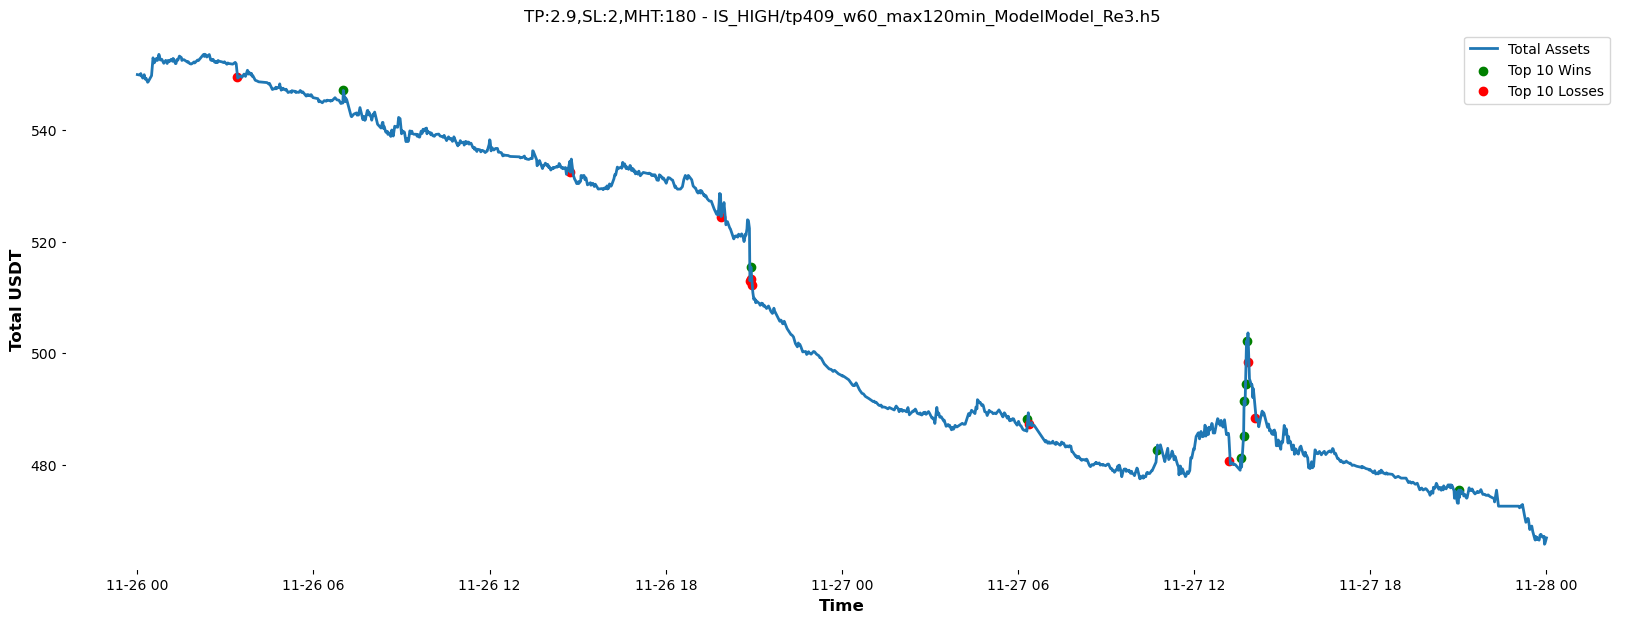

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:4 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 460.12 USDT
Profit: -89.88 USDT
Return on Investment (ROI): -16.34%


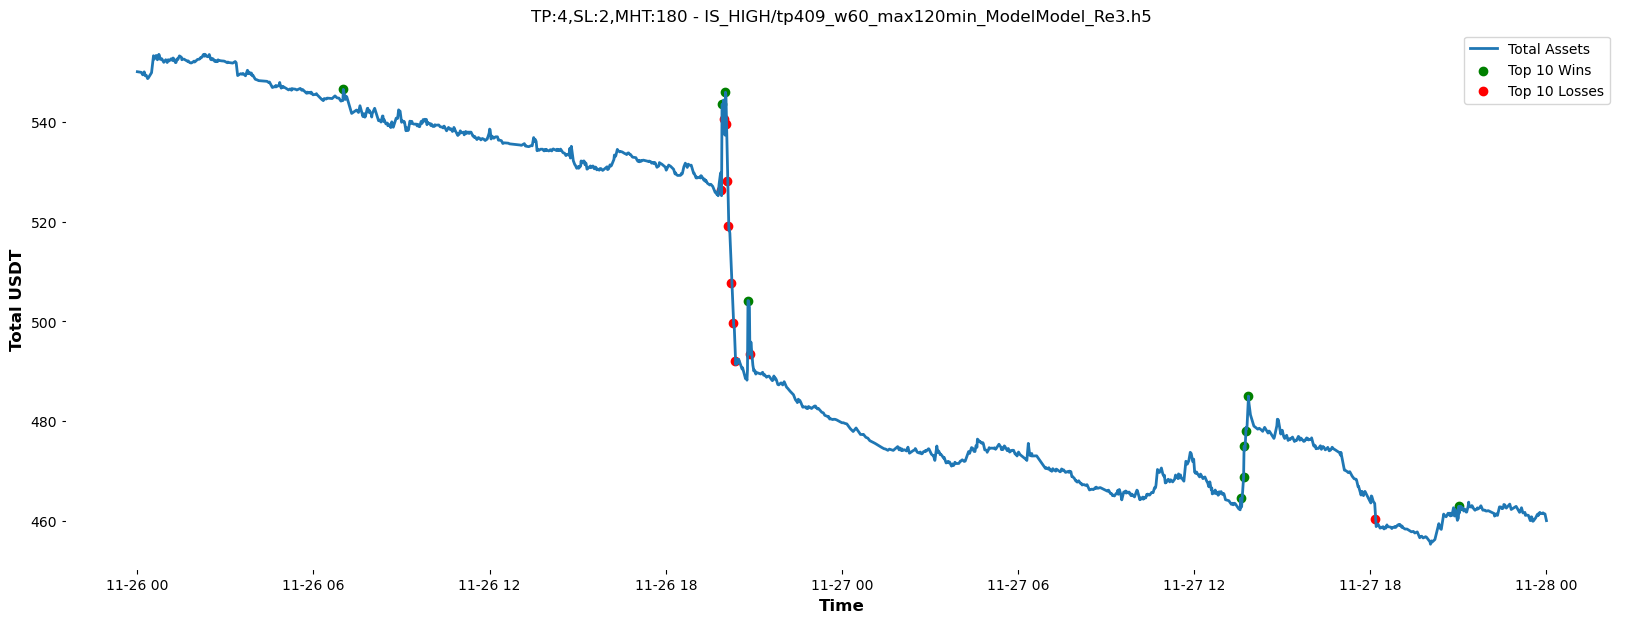

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:5 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 526.95 USDT
Profit: -23.05 USDT
Return on Investment (ROI): -4.19%


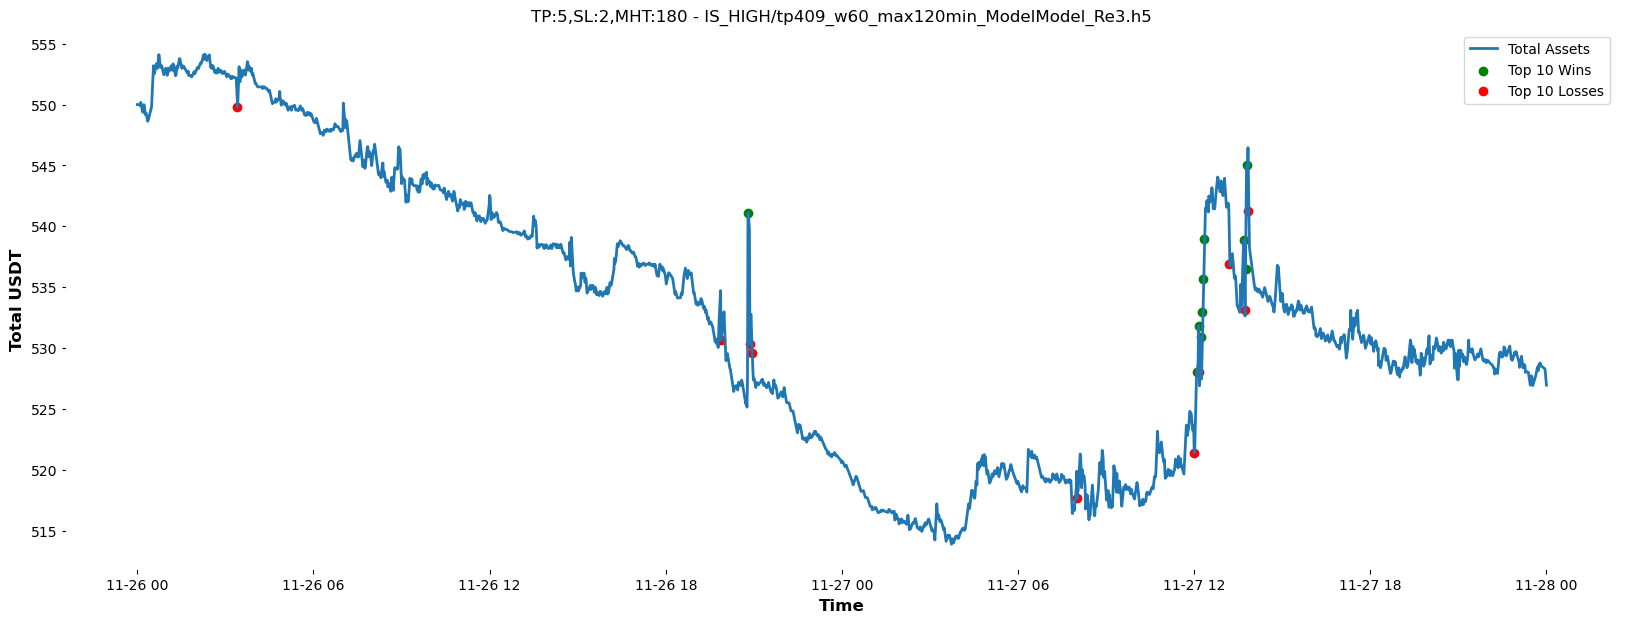

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:0.9 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 388.58 USDT
Profit: -161.42 USDT
Return on Investment (ROI): -29.35%


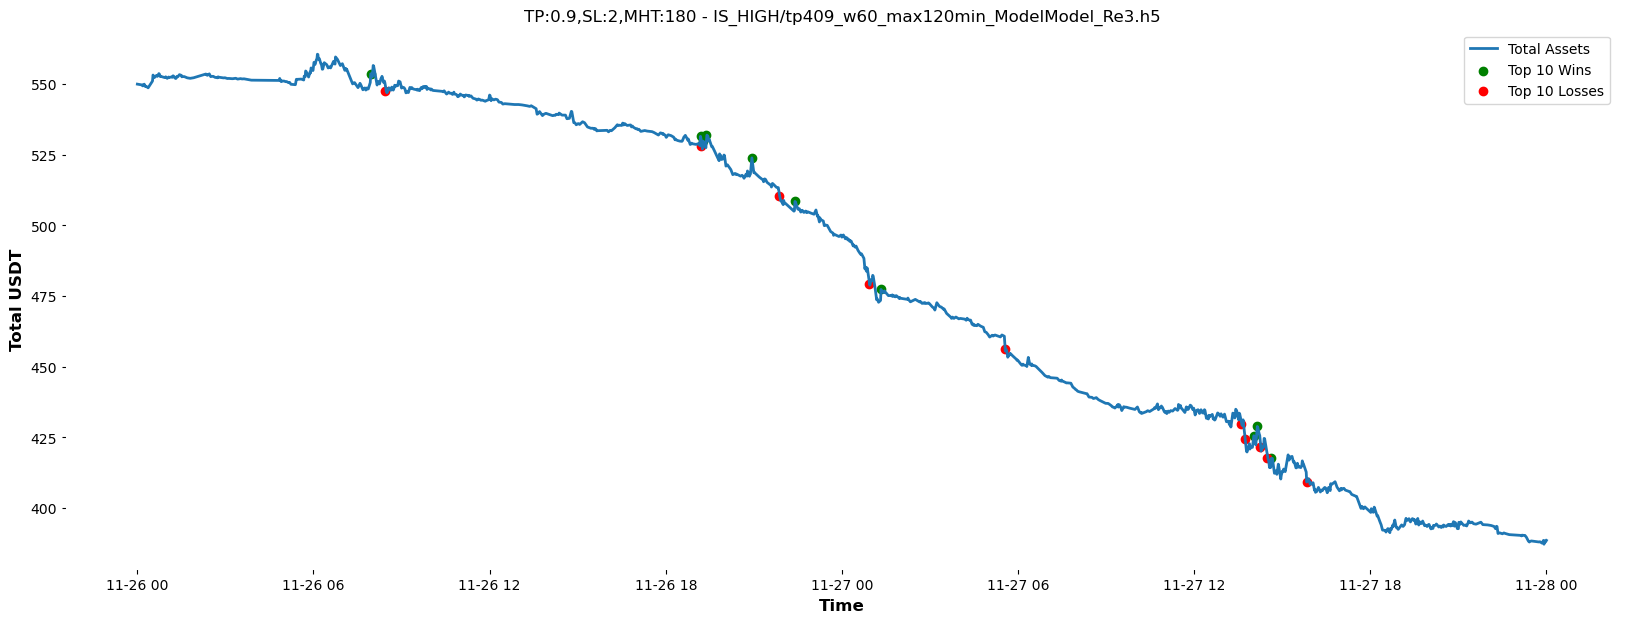

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.3 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 401.63 USDT
Profit: -148.37 USDT
Return on Investment (ROI): -26.98%


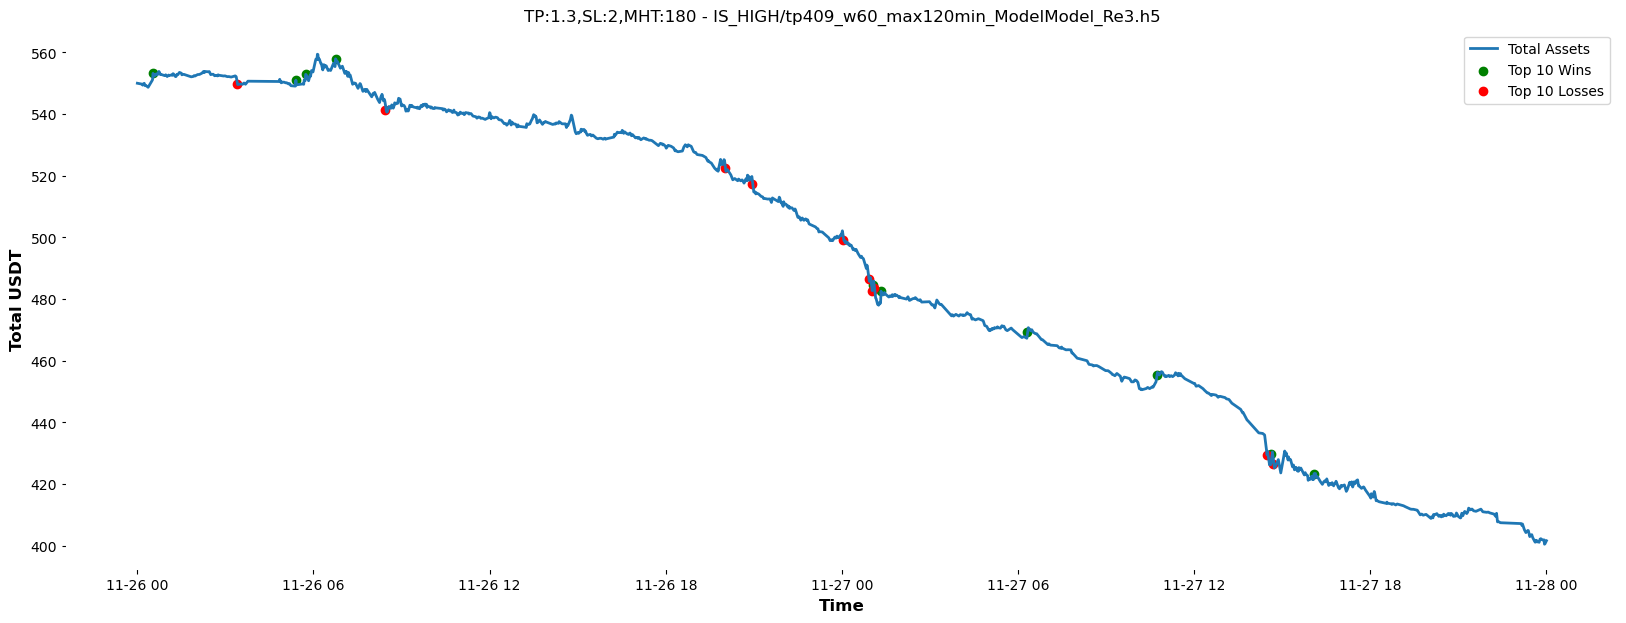

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.7 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 484.49 USDT
Profit: -65.51 USDT
Return on Investment (ROI): -11.91%


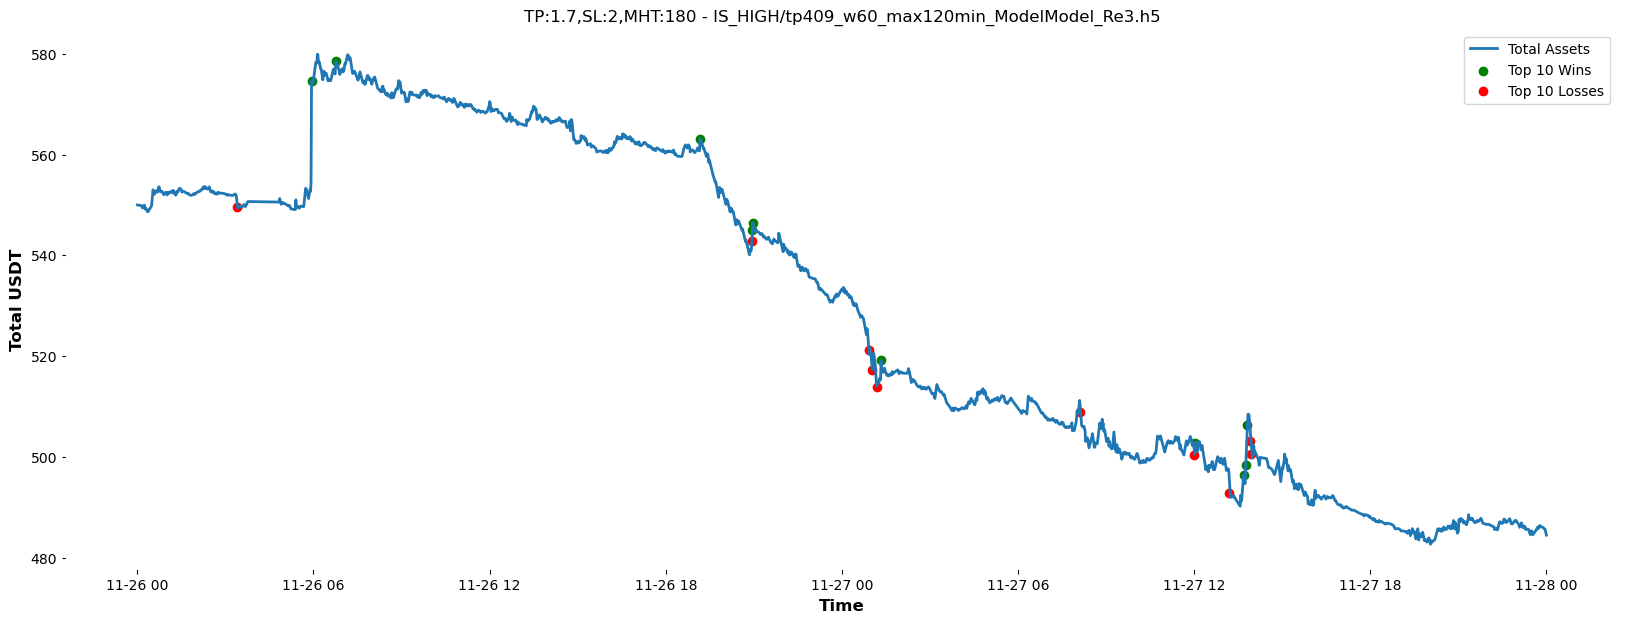

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.3 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 455.59 USDT
Profit: -94.41 USDT
Return on Investment (ROI): -17.17%


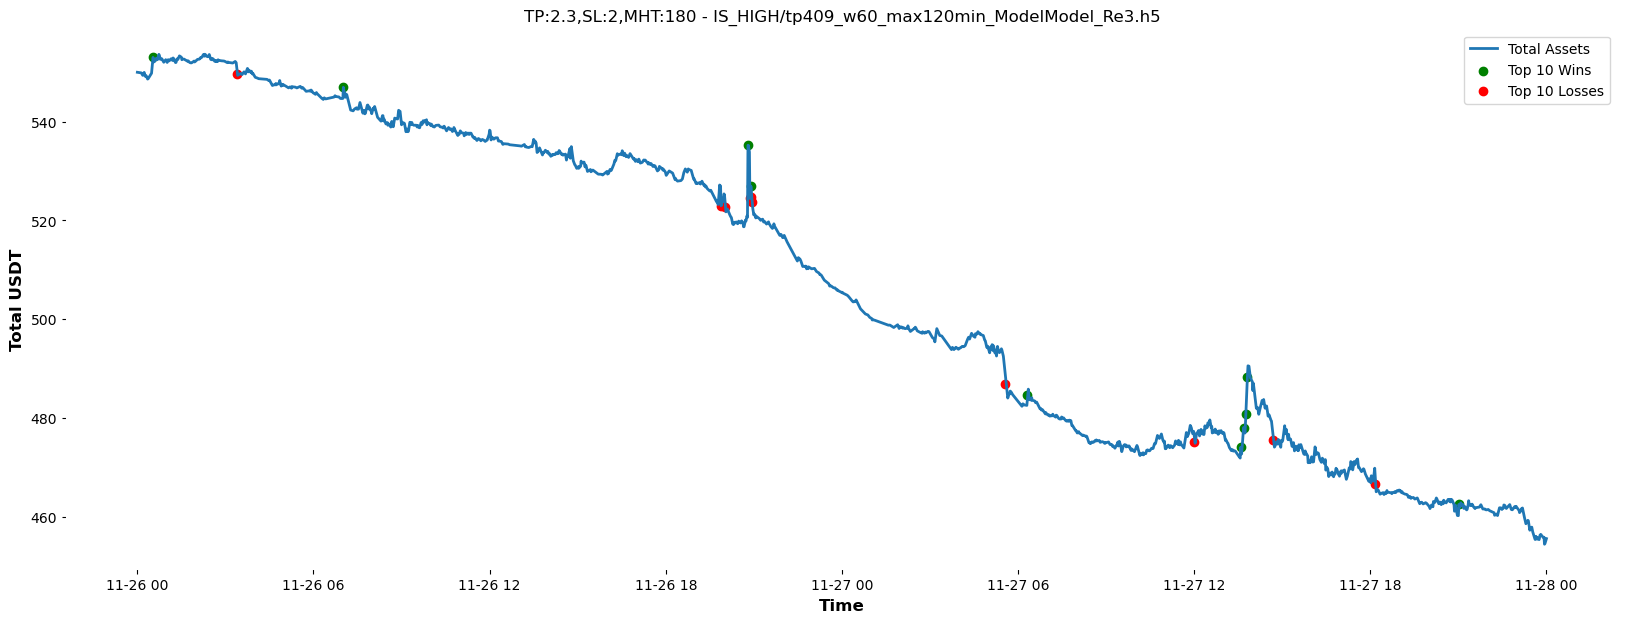

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.7 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 457.37 USDT
Profit: -92.63 USDT
Return on Investment (ROI): -16.84%


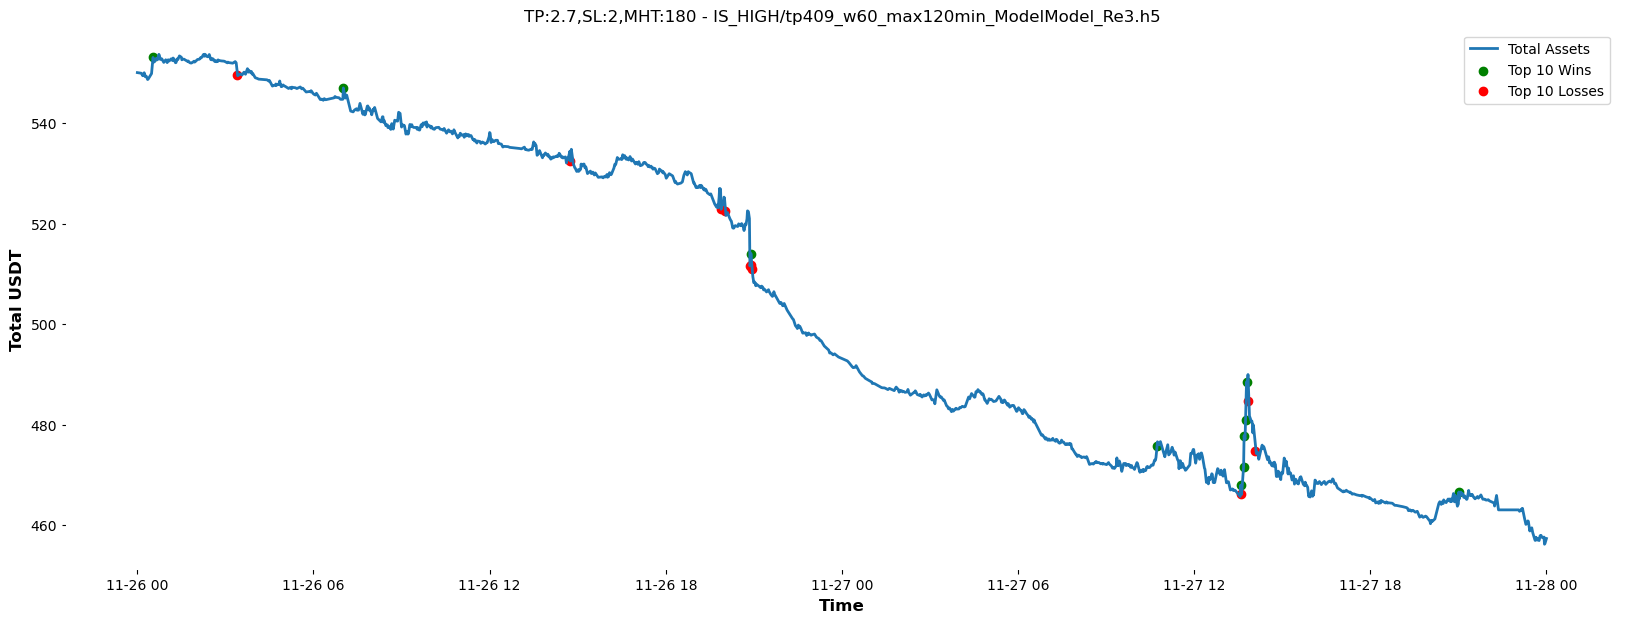

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 470.47 USDT
Profit: -79.53 USDT
Return on Investment (ROI): -14.46%


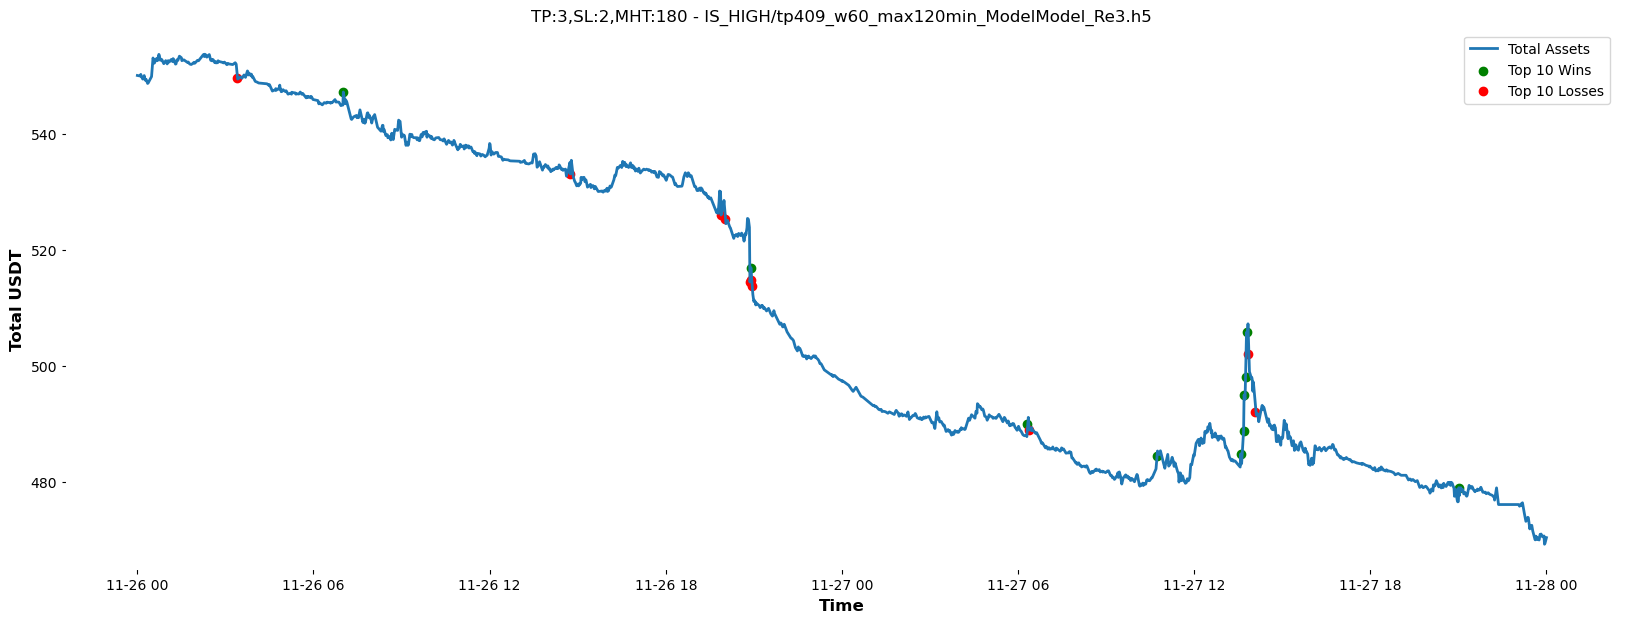

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3.3 , SL:2 , MHT:180 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 478.04 USDT
Profit: -71.96 USDT
Return on Investment (ROI): -13.08%


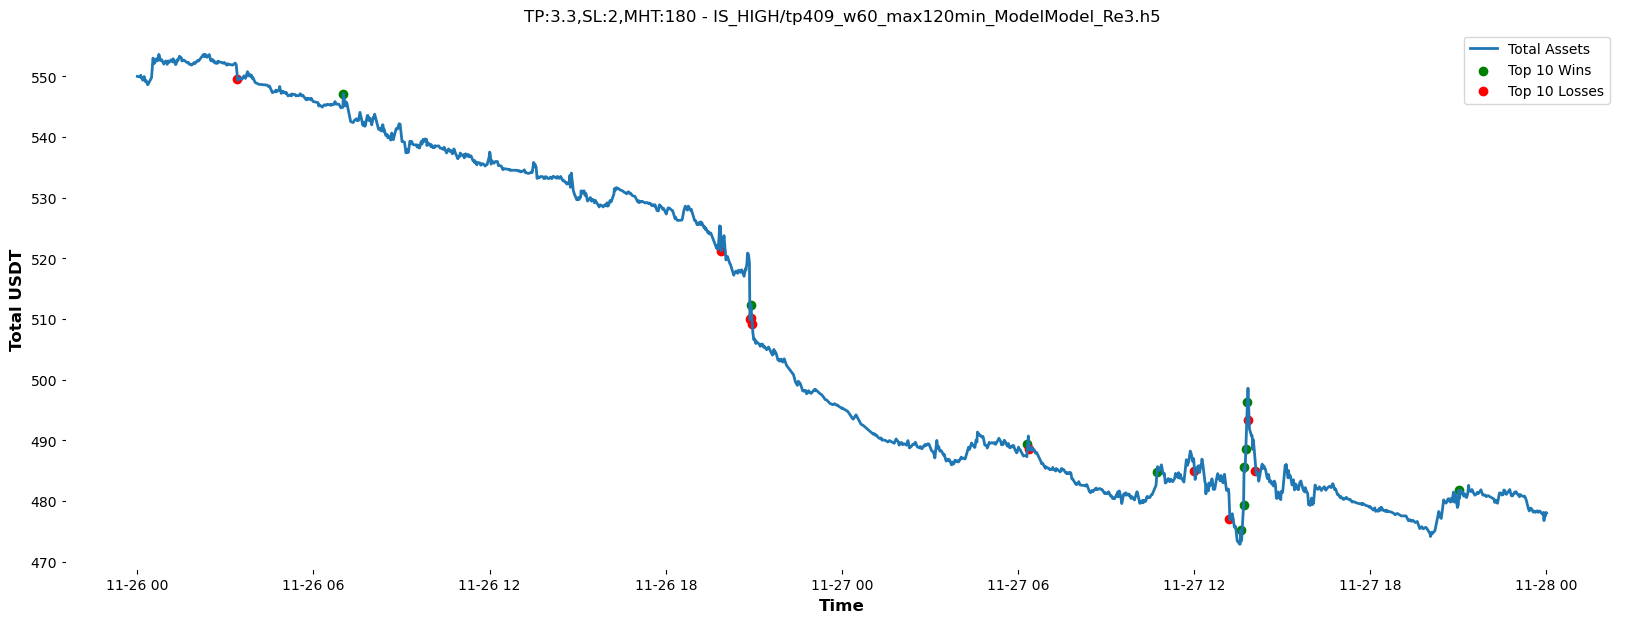

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.9 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 499.01 USDT
Profit: -50.99 USDT
Return on Investment (ROI): -9.27%


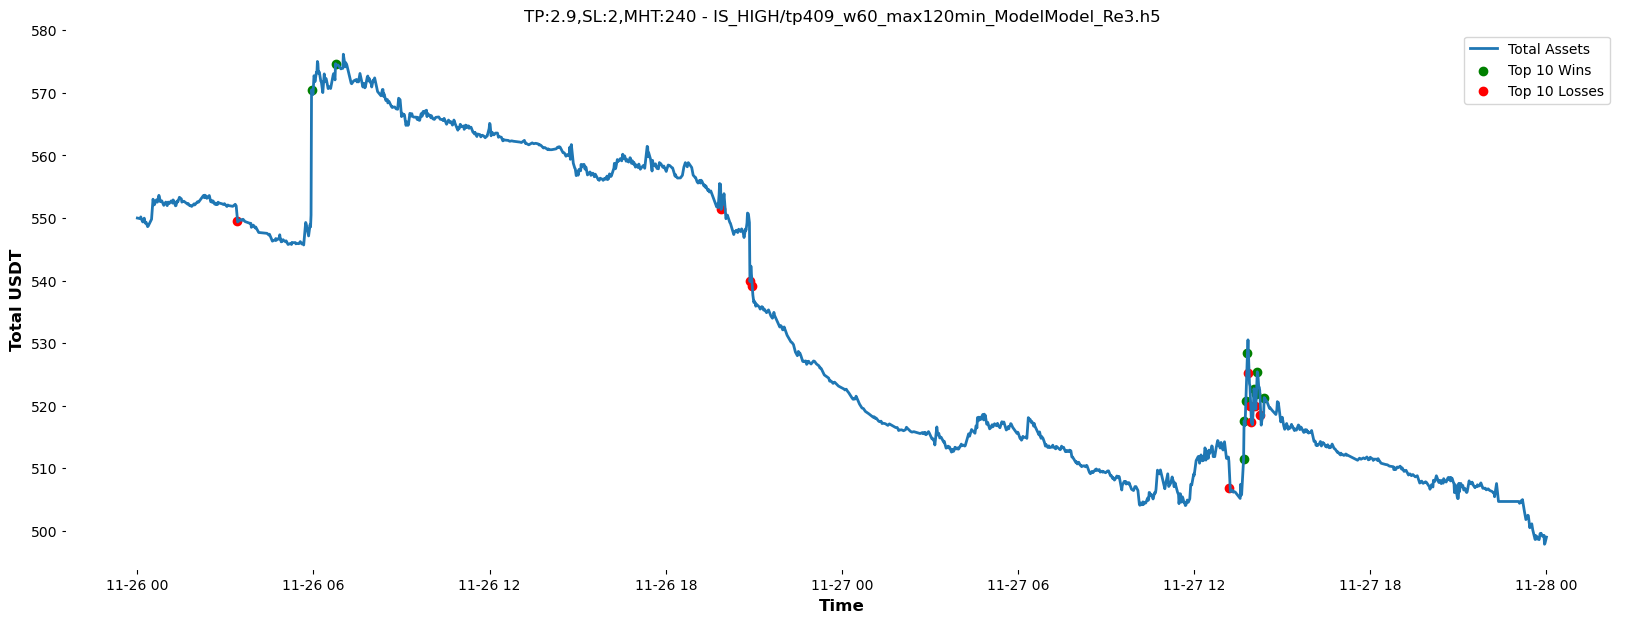

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:4 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 519.59 USDT
Profit: -30.41 USDT
Return on Investment (ROI): -5.53%


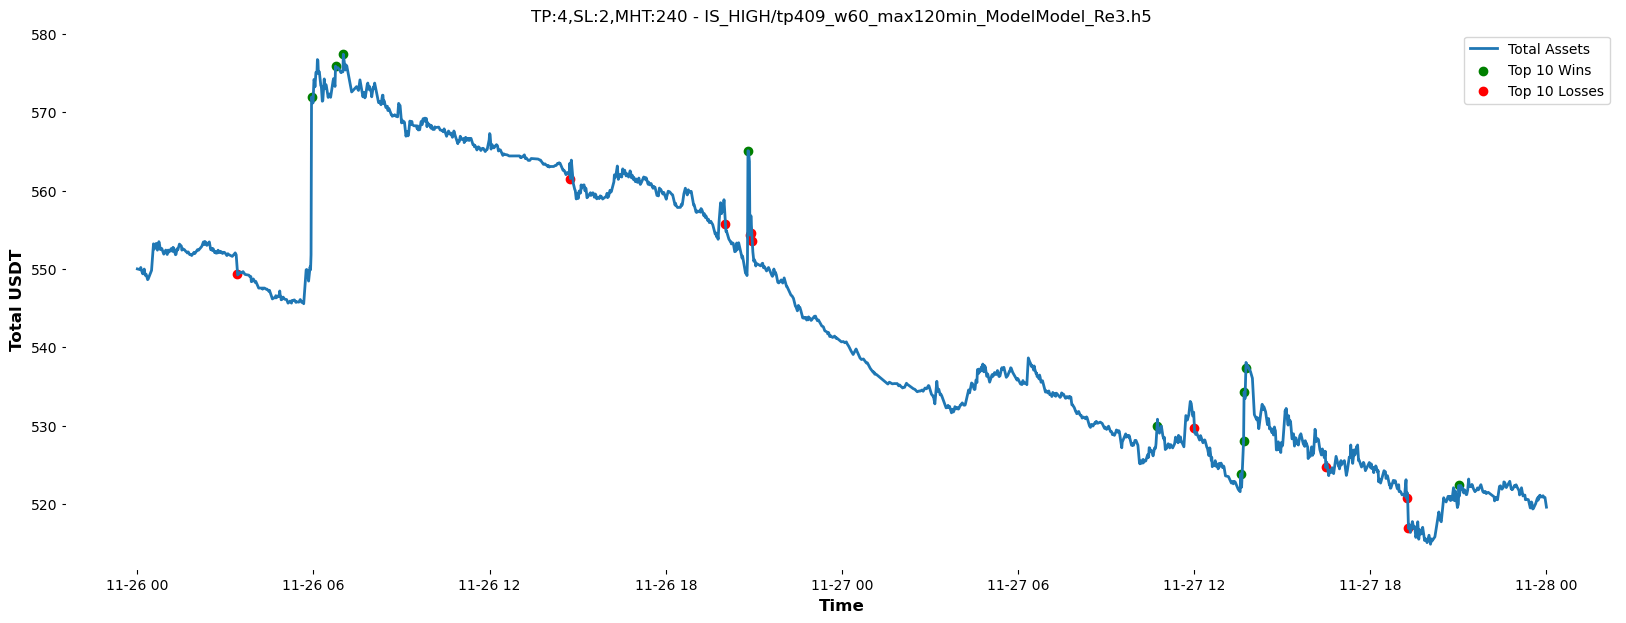

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:5 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 524.94 USDT
Profit: -25.06 USDT
Return on Investment (ROI): -4.56%


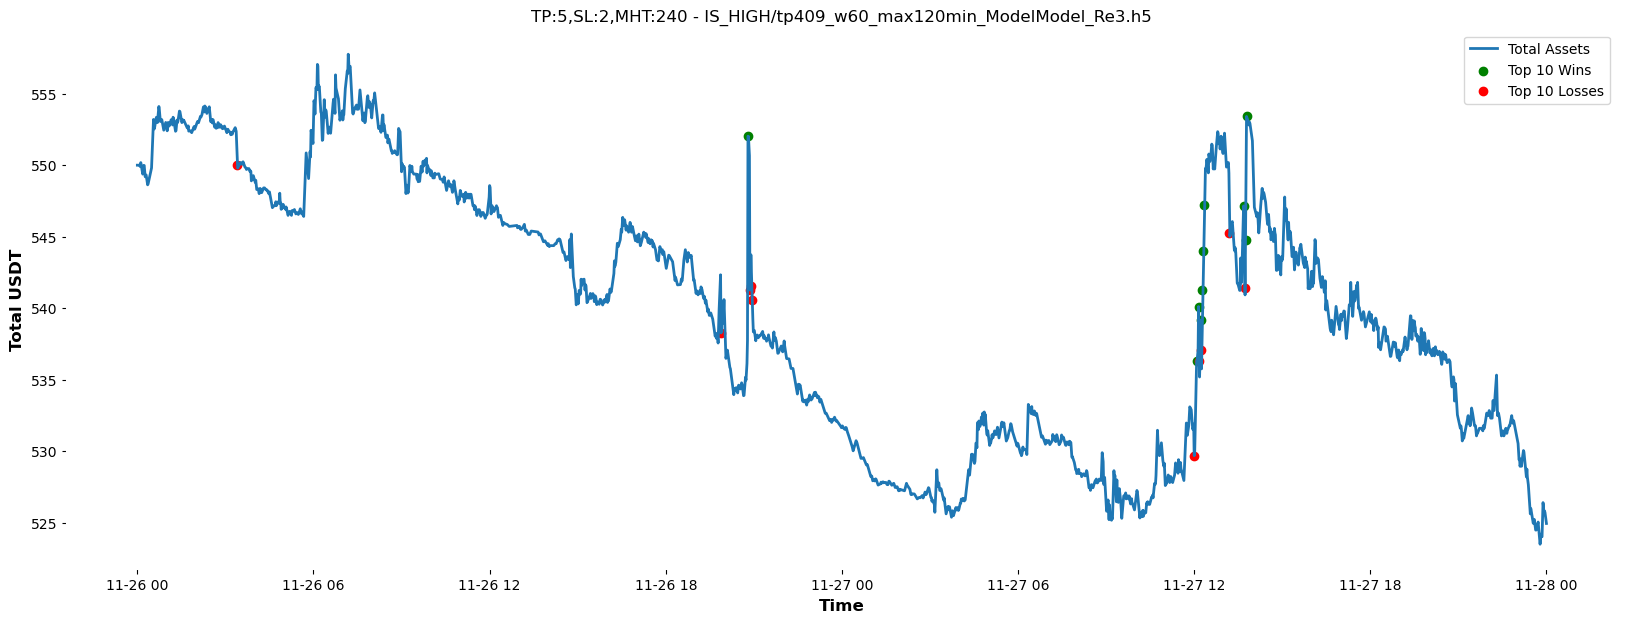

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:0.9 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 373.29 USDT
Profit: -176.71 USDT
Return on Investment (ROI): -32.13%


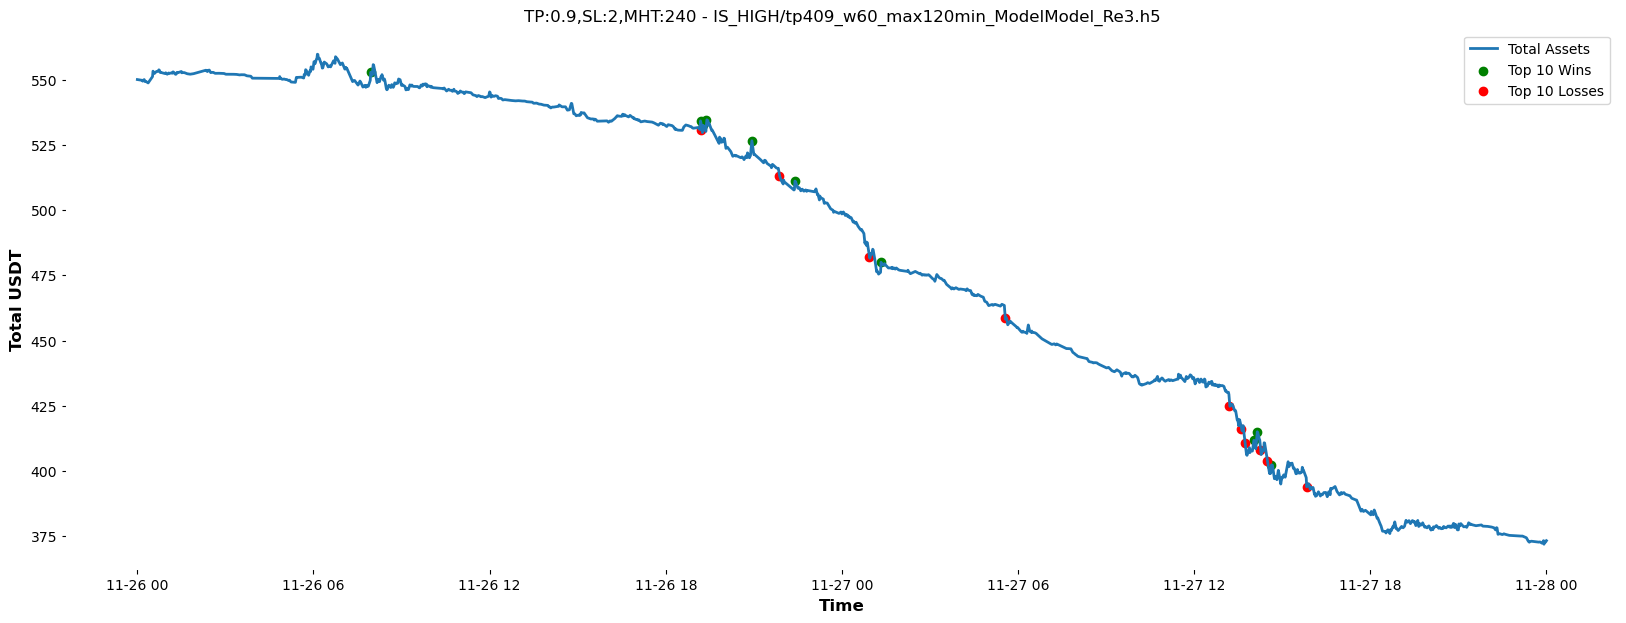

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.3 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 402.99 USDT
Profit: -147.01 USDT
Return on Investment (ROI): -26.73%


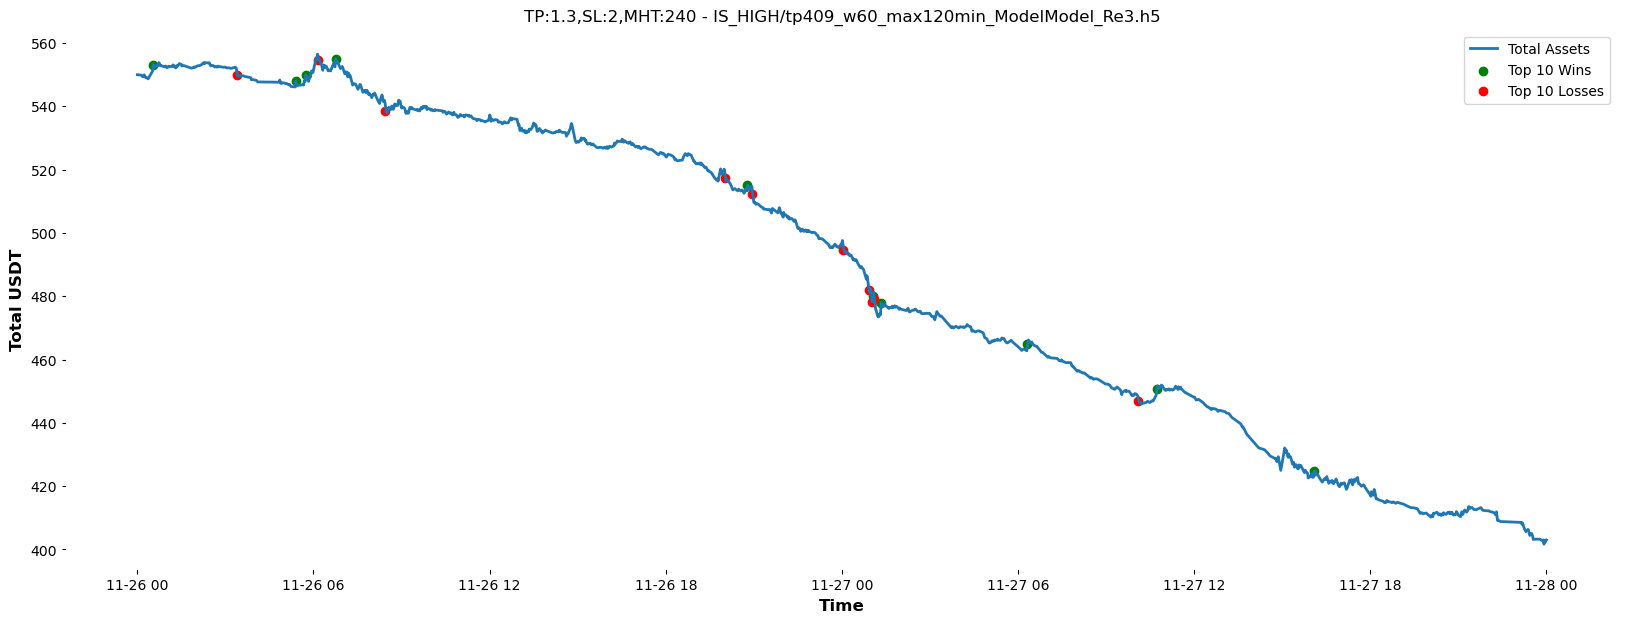

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.7 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 474.51 USDT
Profit: -75.49 USDT
Return on Investment (ROI): -13.73%


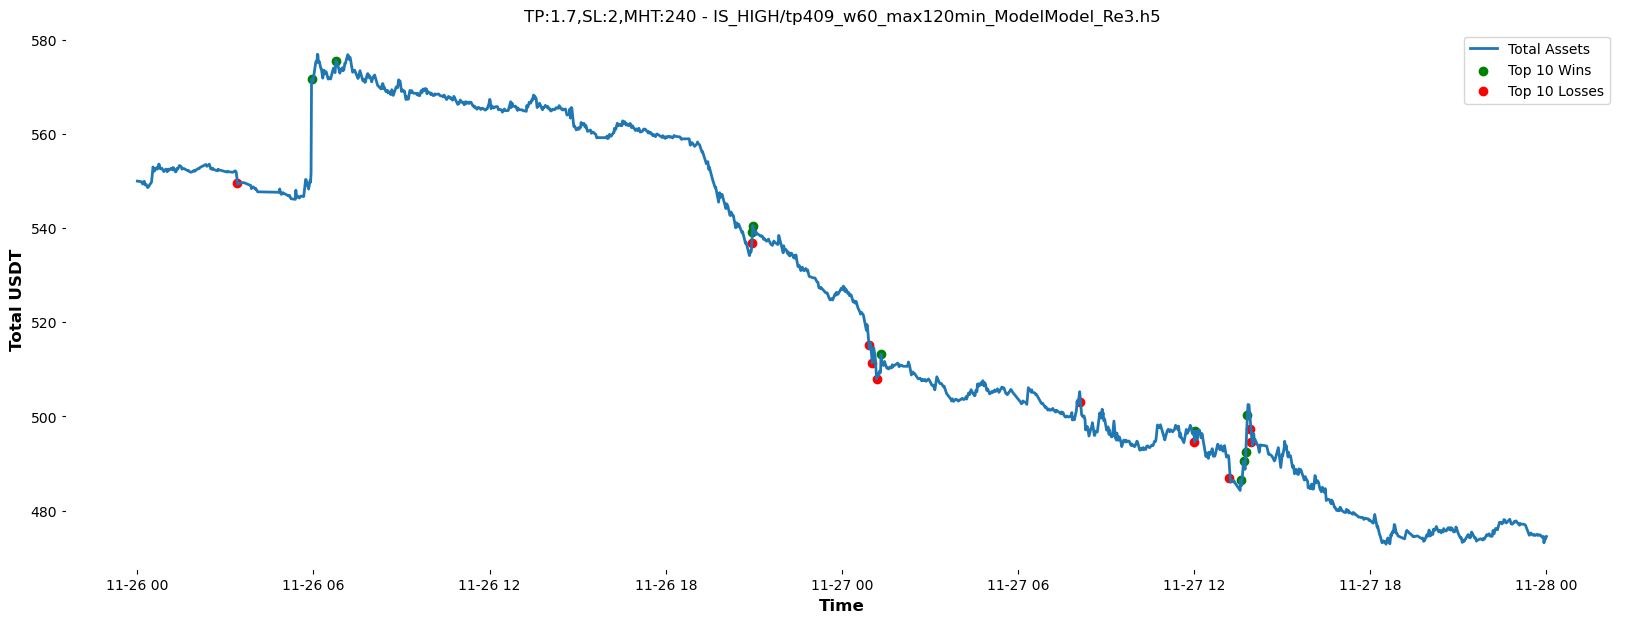

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.3 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 479.45 USDT
Profit: -70.55 USDT
Return on Investment (ROI): -12.83%


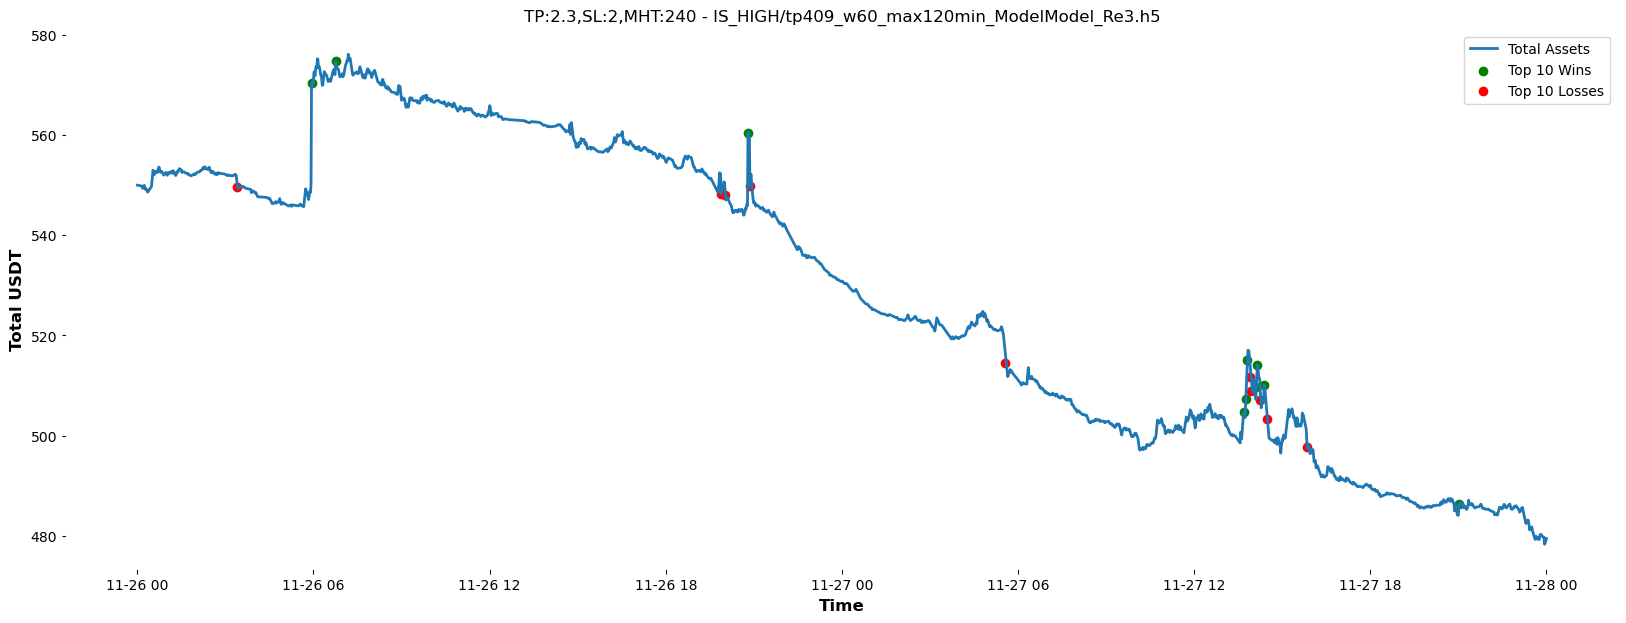

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.7 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 486.19 USDT
Profit: -63.81 USDT
Return on Investment (ROI): -11.60%


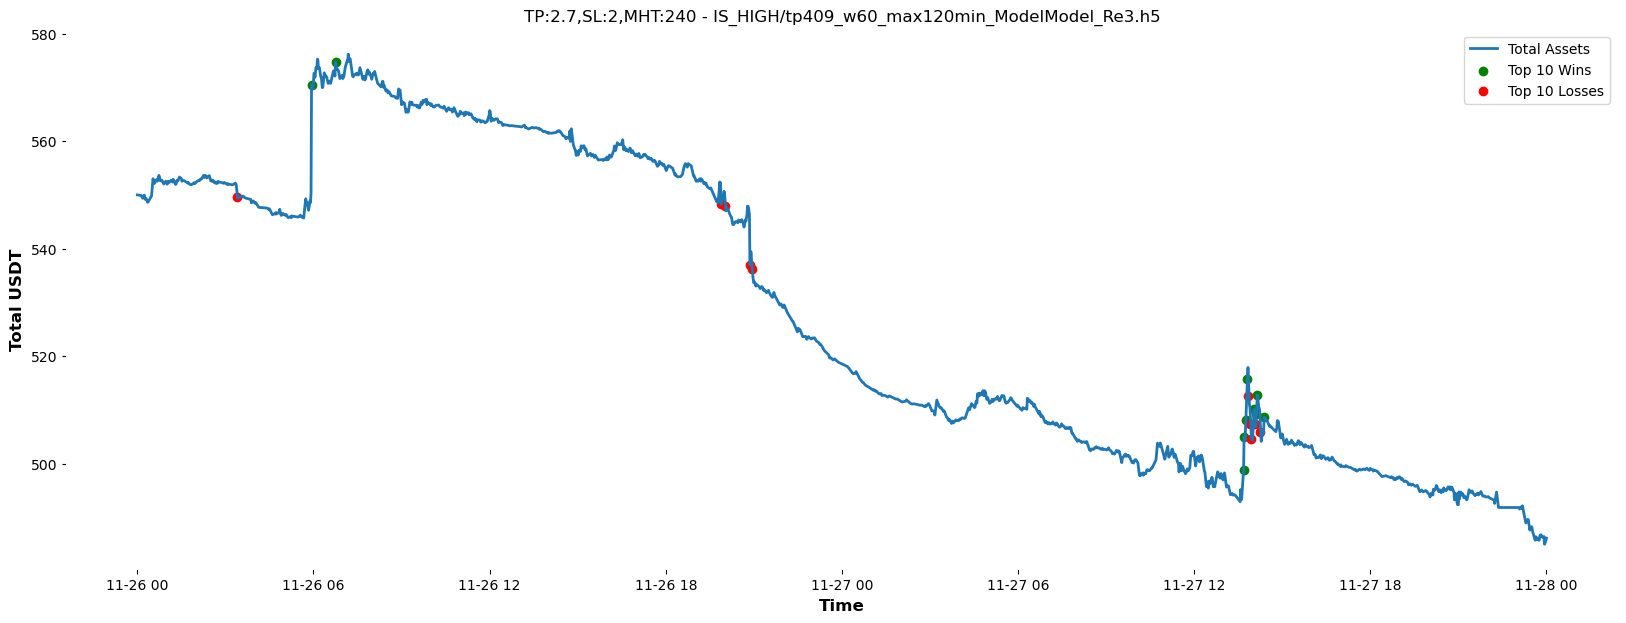

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 501.83 USDT
Profit: -48.17 USDT
Return on Investment (ROI): -8.76%


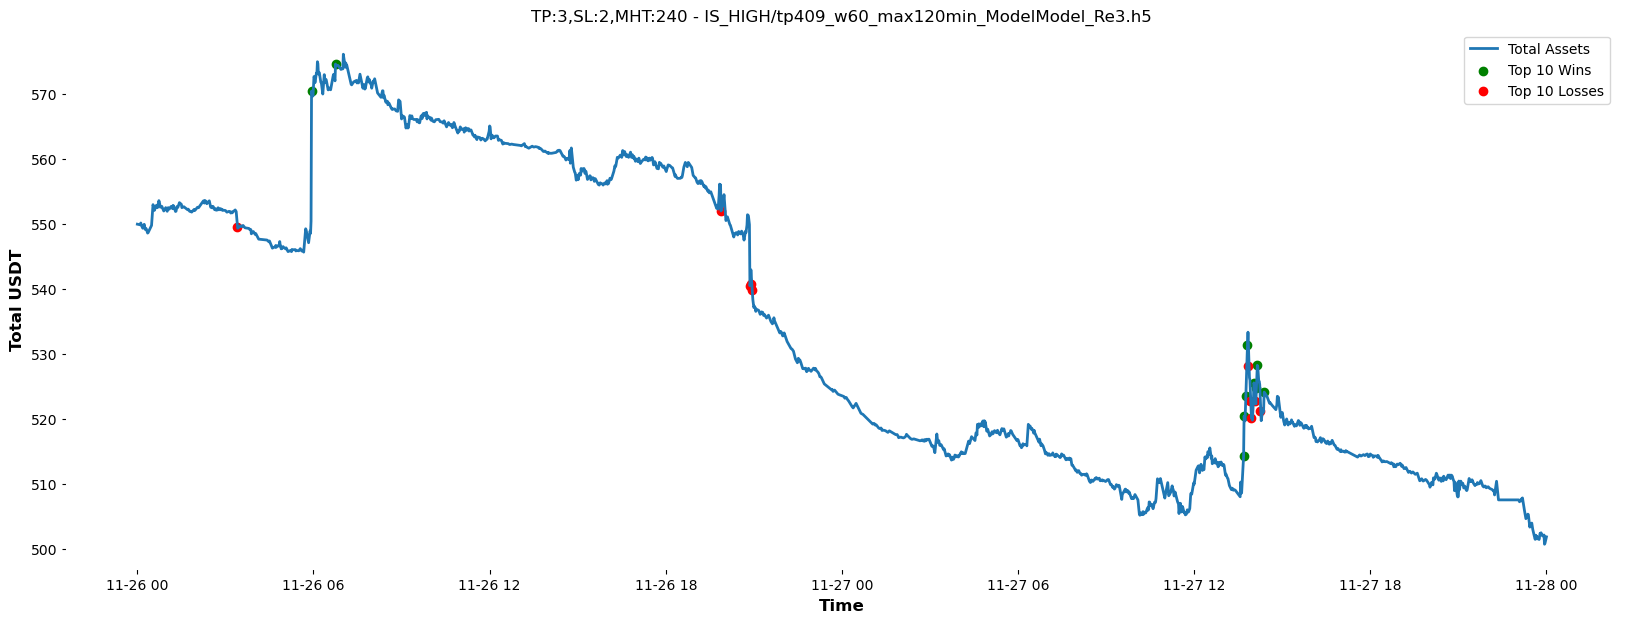

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3.3 , SL:2 , MHT:240 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 505.28 USDT
Profit: -44.72 USDT
Return on Investment (ROI): -8.13%


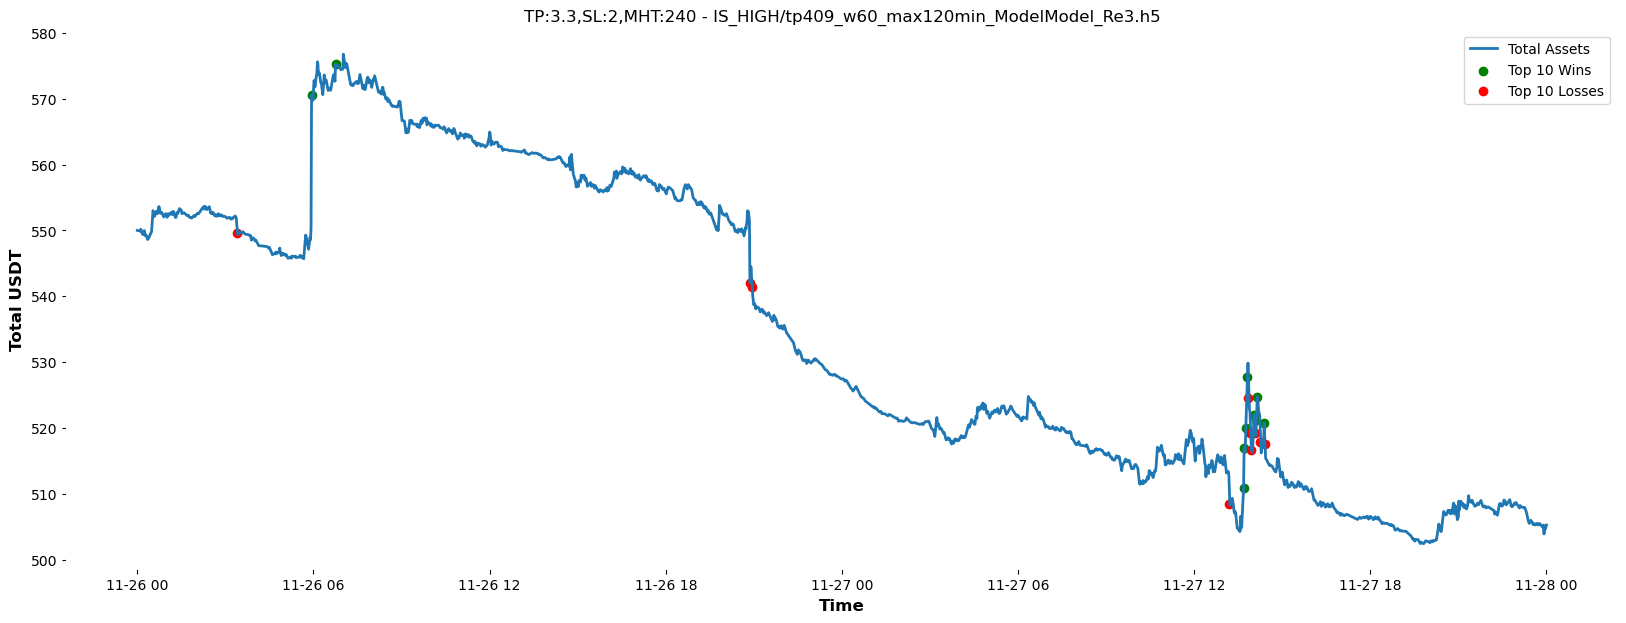

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.9 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 535.28 USDT
Profit: -14.72 USDT
Return on Investment (ROI): -2.68%


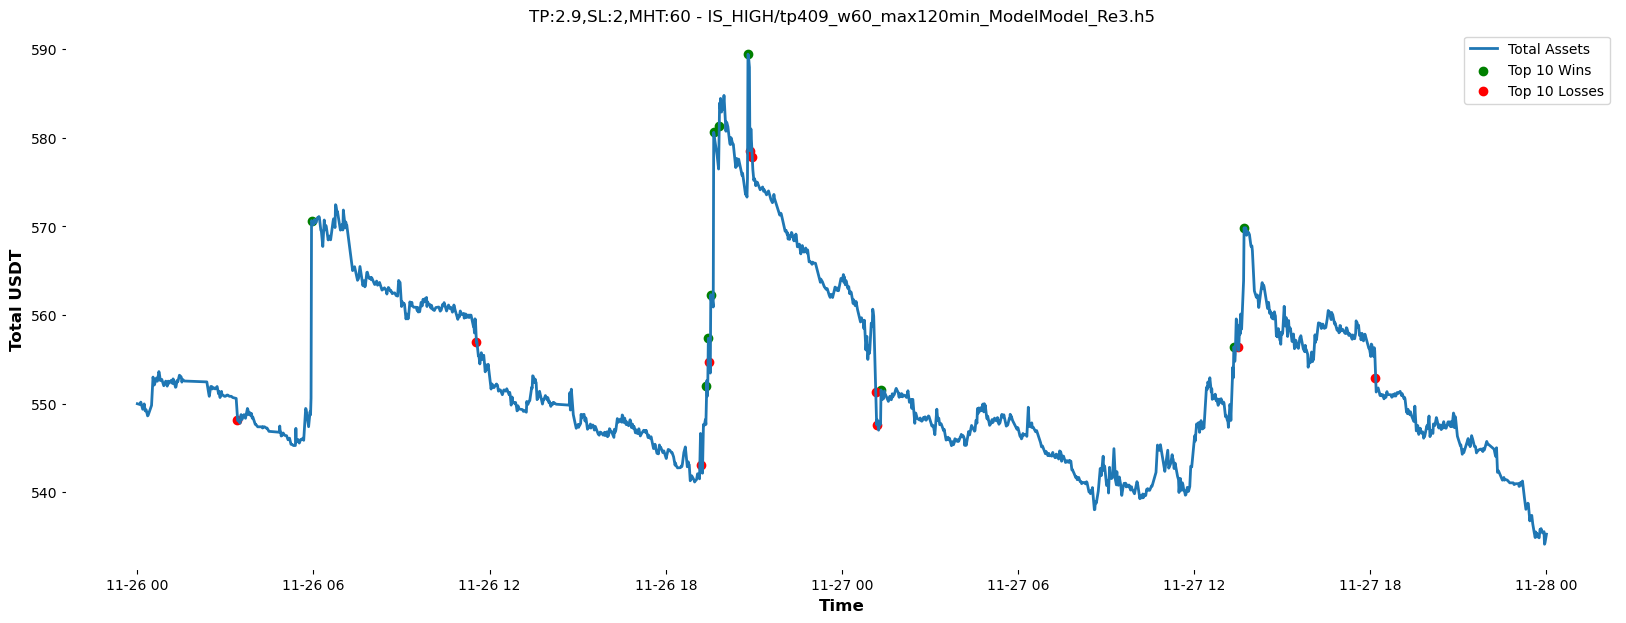

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:4 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 573.17 USDT
Profit: 23.17 USDT
Return on Investment (ROI): 4.21%


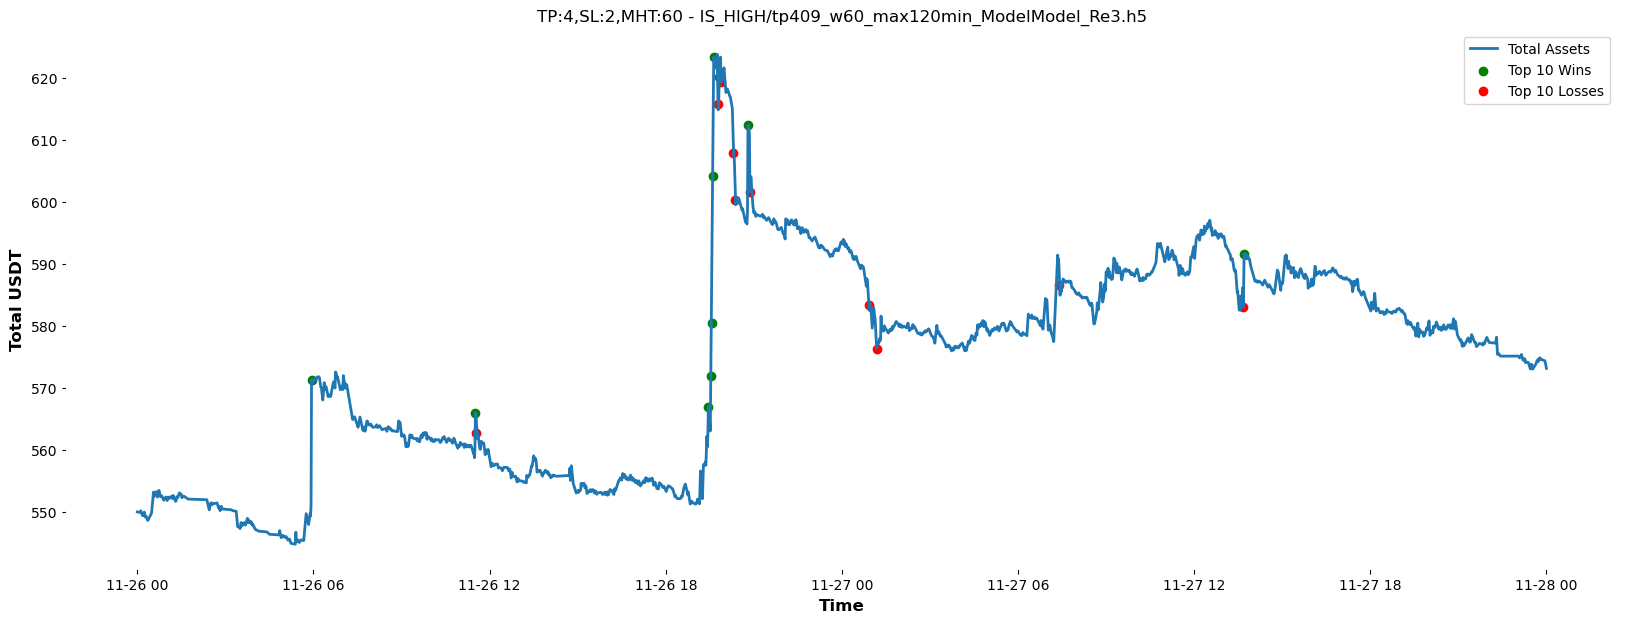

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:5 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 567.74 USDT
Profit: 17.74 USDT
Return on Investment (ROI): 3.23%


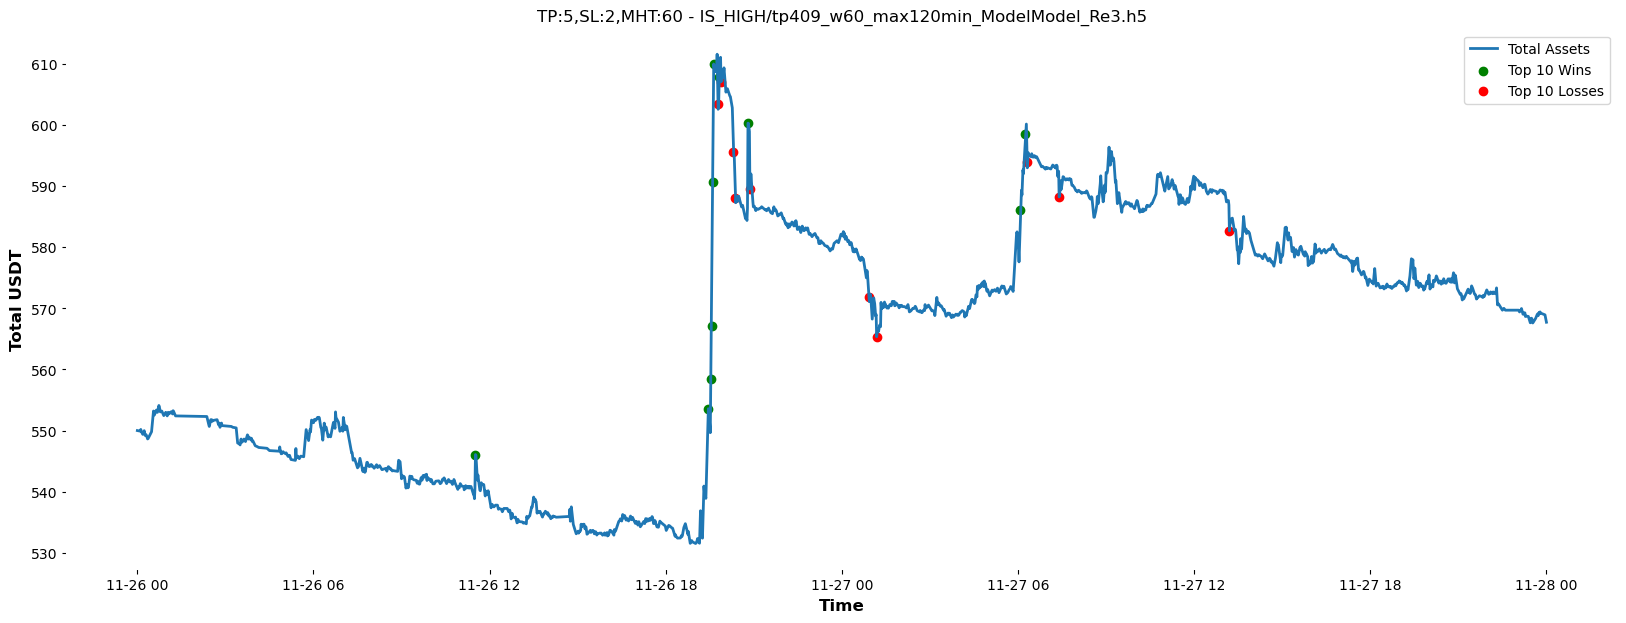

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:0.9 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 401.12 USDT
Profit: -148.88 USDT
Return on Investment (ROI): -27.07%


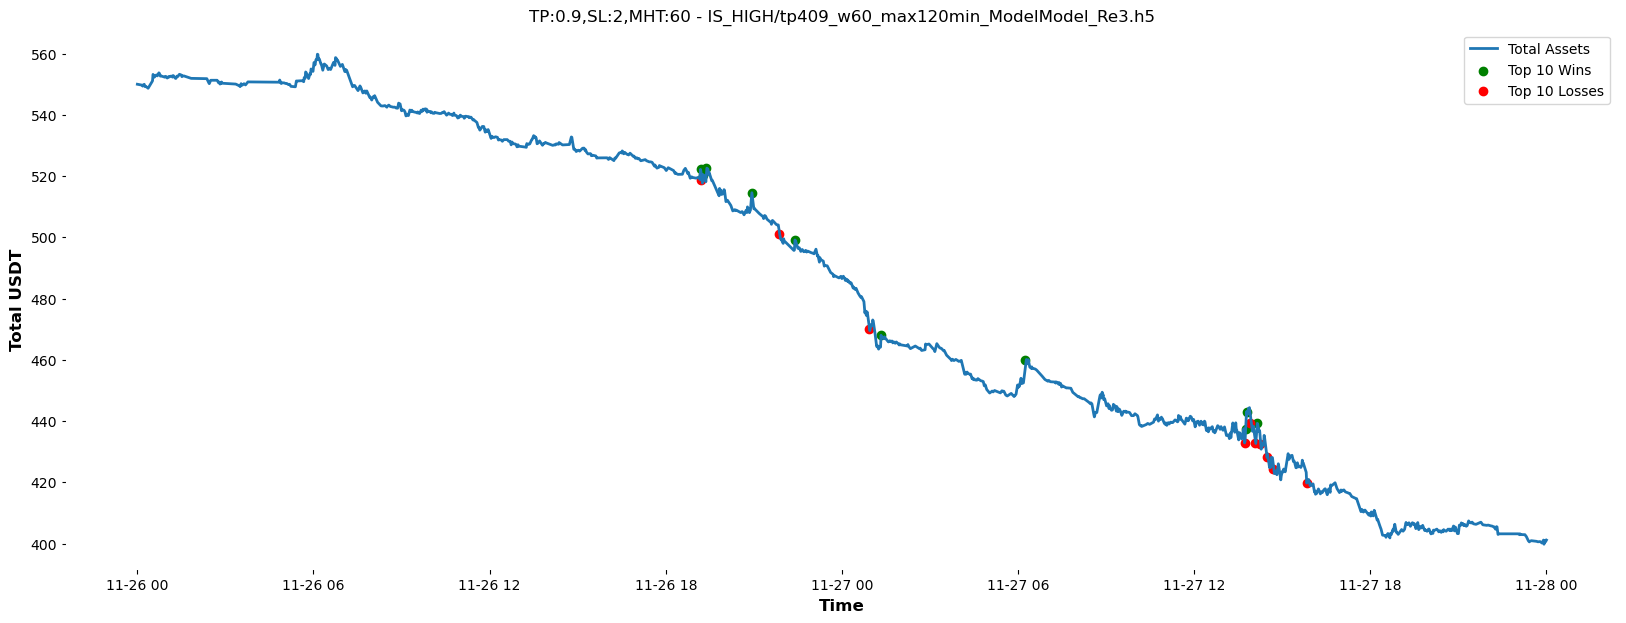

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.3 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 420.86 USDT
Profit: -129.14 USDT
Return on Investment (ROI): -23.48%


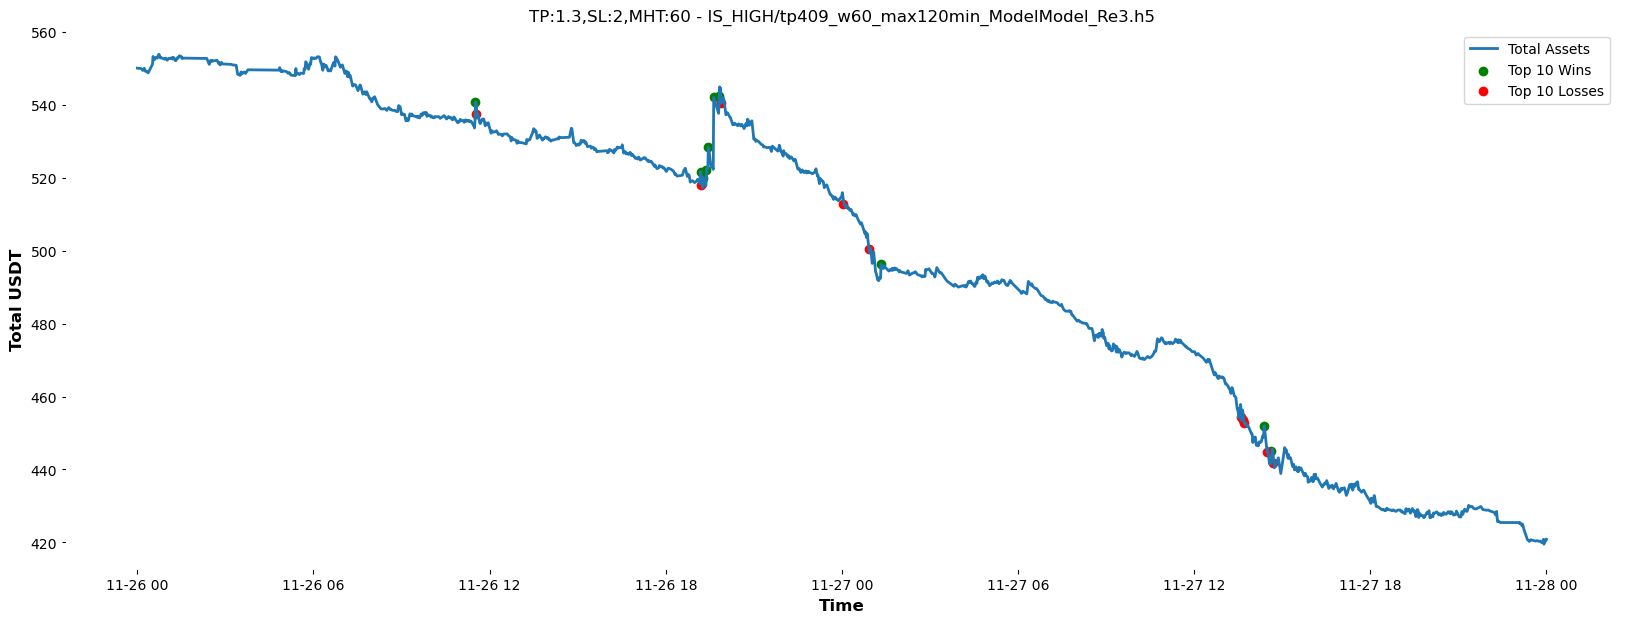

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.7 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 447.54 USDT
Profit: -102.46 USDT
Return on Investment (ROI): -18.63%


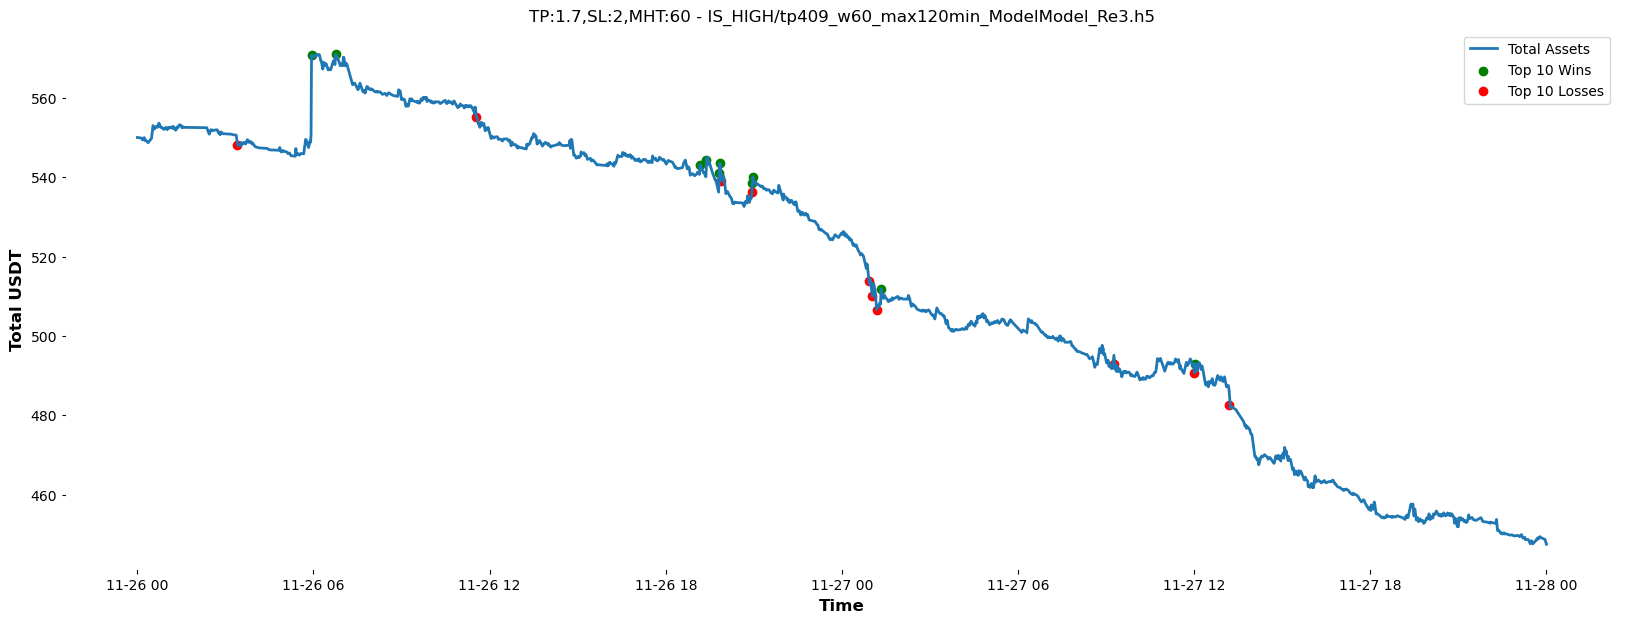

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.3 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 506.44 USDT
Profit: -43.56 USDT
Return on Investment (ROI): -7.92%


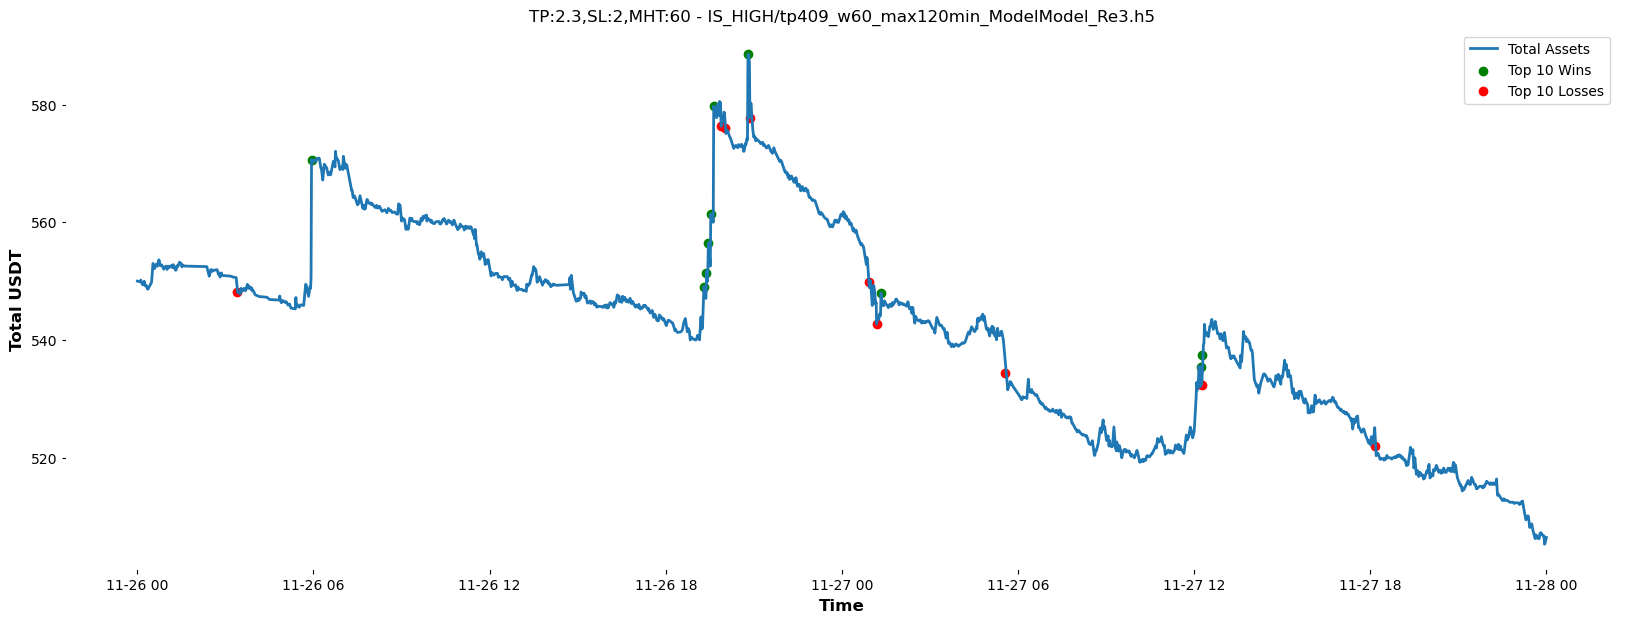

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.7 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 500.27 USDT
Profit: -49.73 USDT
Return on Investment (ROI): -9.04%


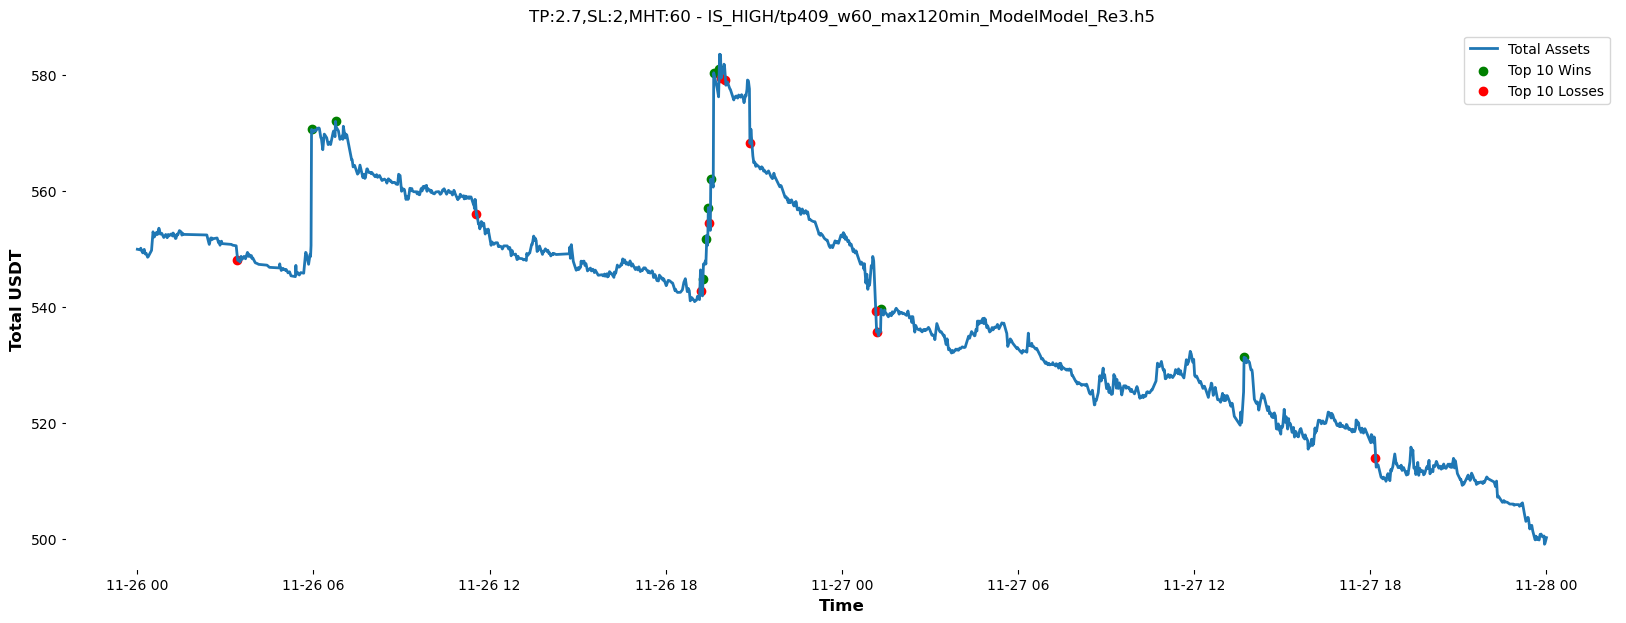

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 548.21 USDT
Profit: -1.79 USDT
Return on Investment (ROI): -0.33%


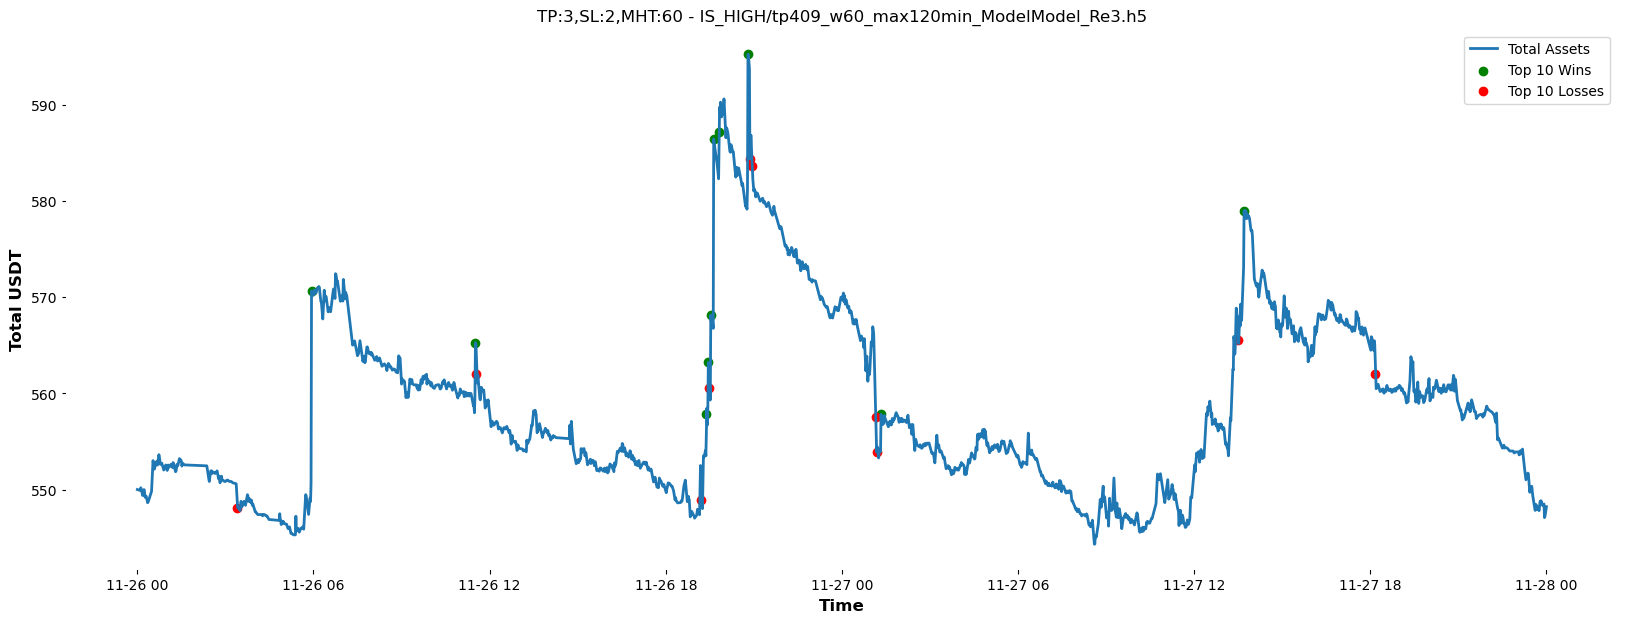

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:3.3 , SL:2 , MHT:60 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 523.40 USDT
Profit: -26.60 USDT
Return on Investment (ROI): -4.84%


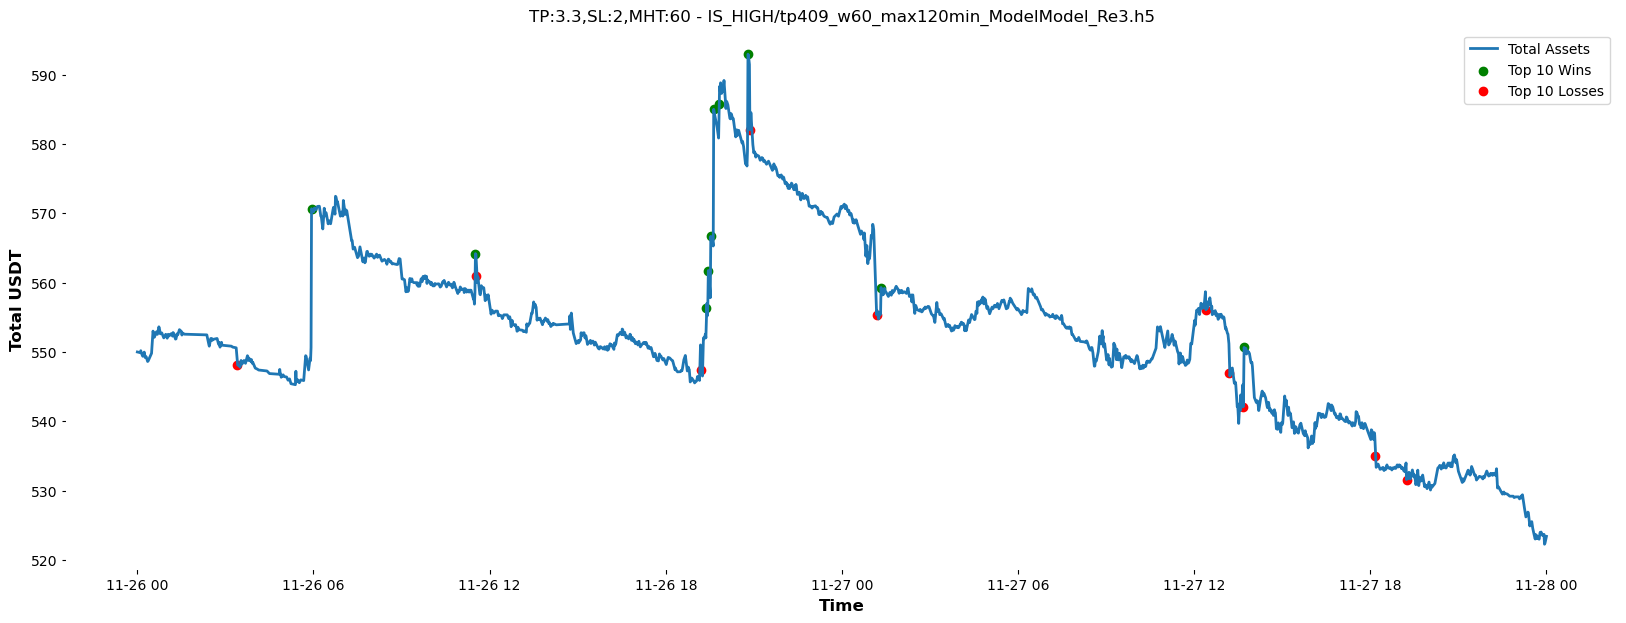

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.9 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 513.26 USDT
Profit: -36.74 USDT
Return on Investment (ROI): -6.68%


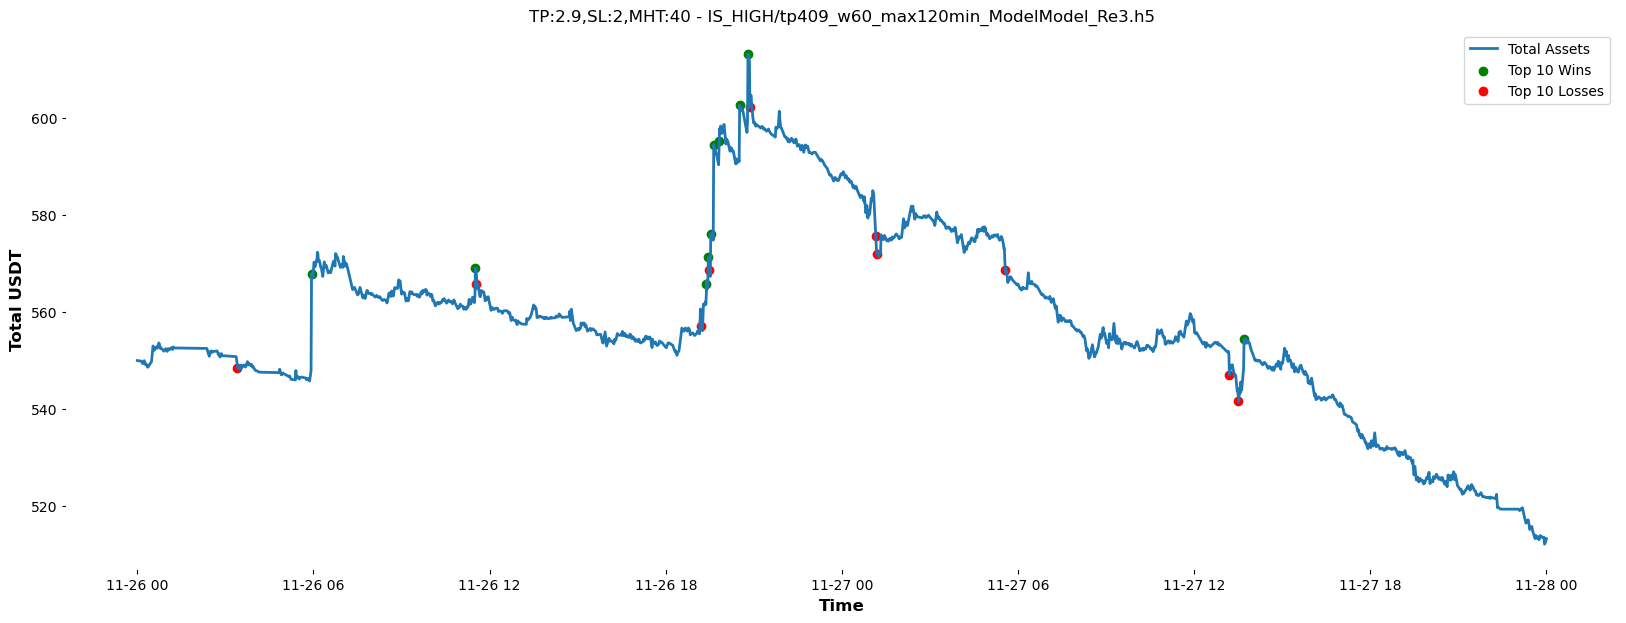

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:4 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 567.31 USDT
Profit: 17.31 USDT
Return on Investment (ROI): 3.15%


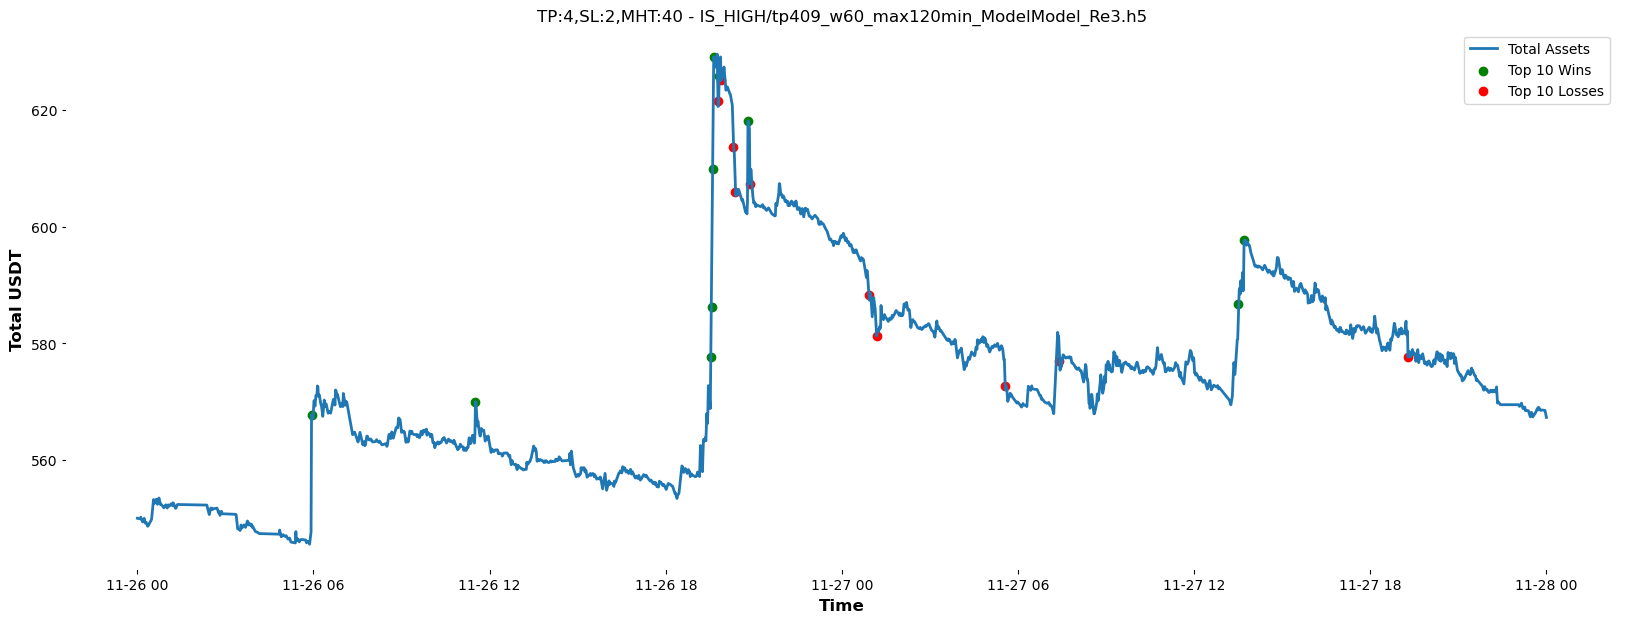

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:5 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 532.62 USDT
Profit: -17.38 USDT
Return on Investment (ROI): -3.16%


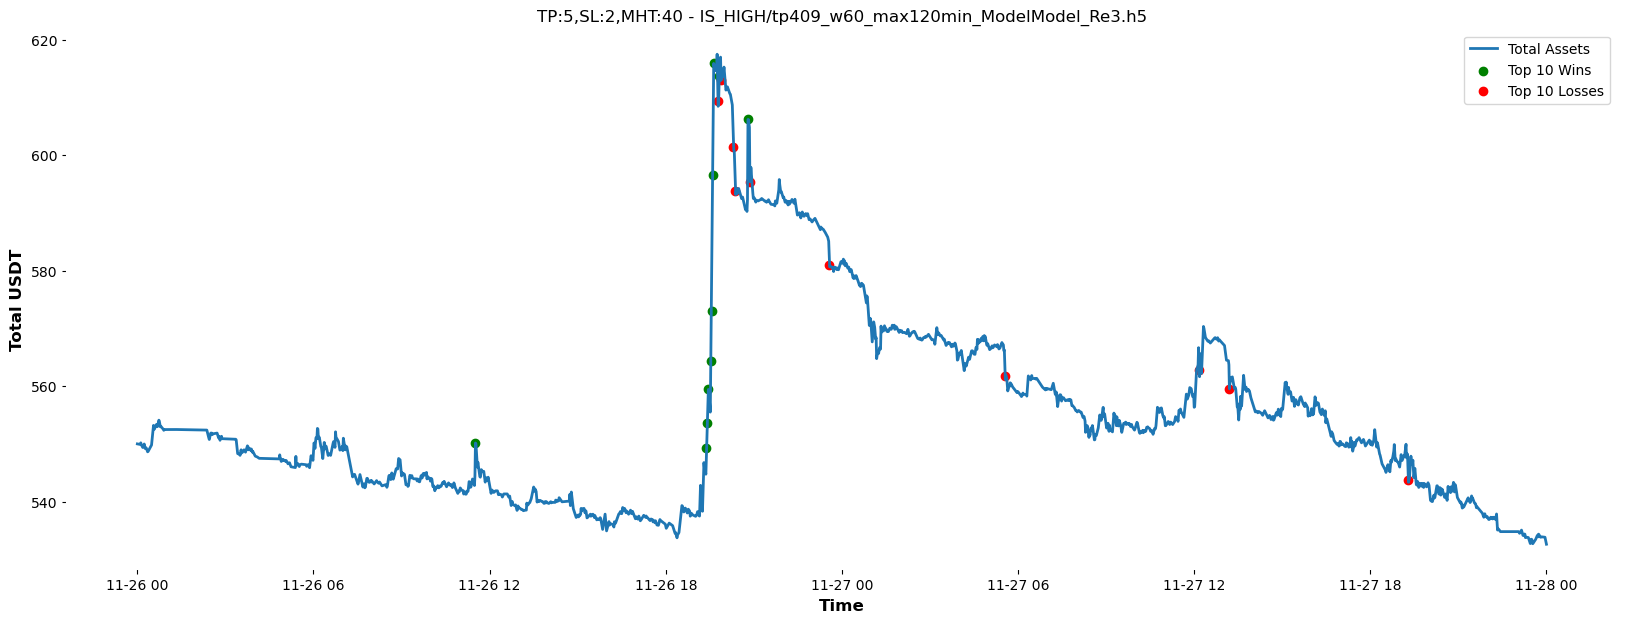

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:0.9 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 378.34 USDT
Profit: -171.66 USDT
Return on Investment (ROI): -31.21%


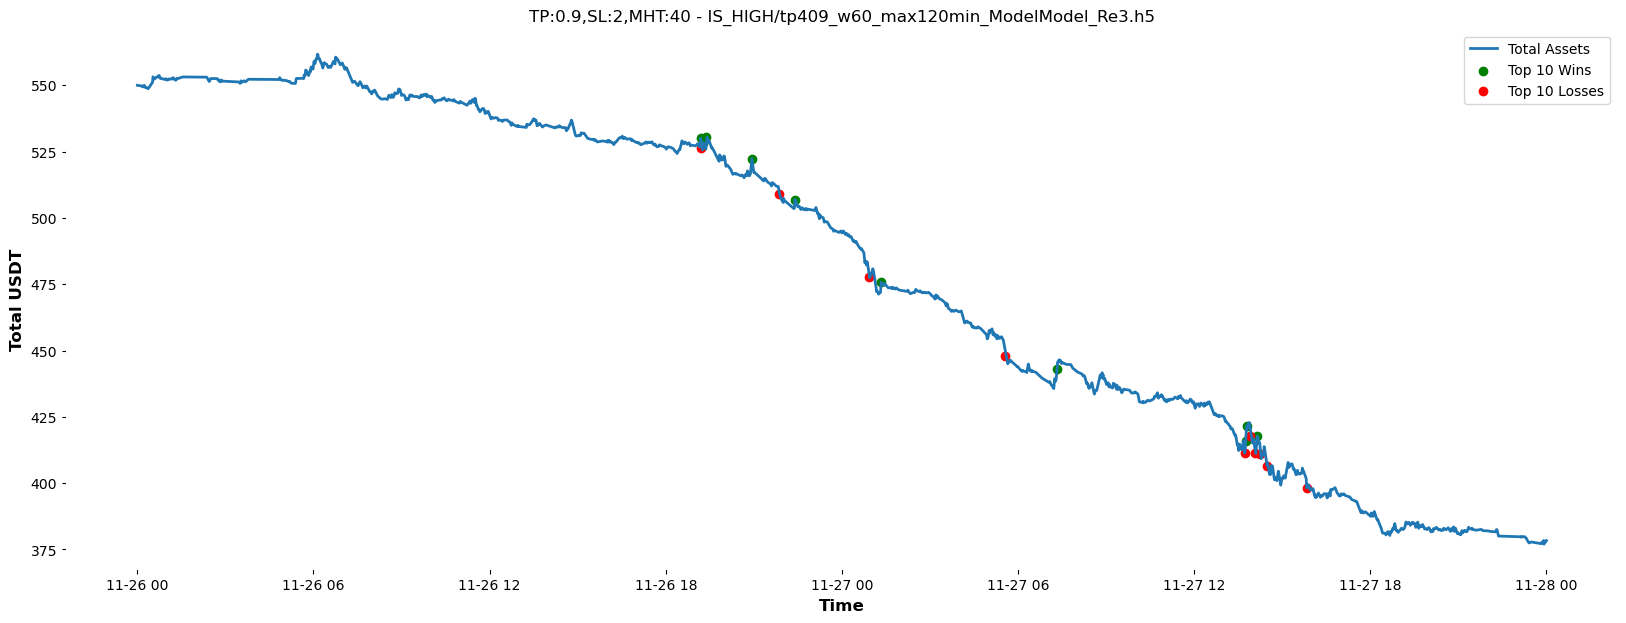

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.3 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 437.52 USDT
Profit: -112.48 USDT
Return on Investment (ROI): -20.45%


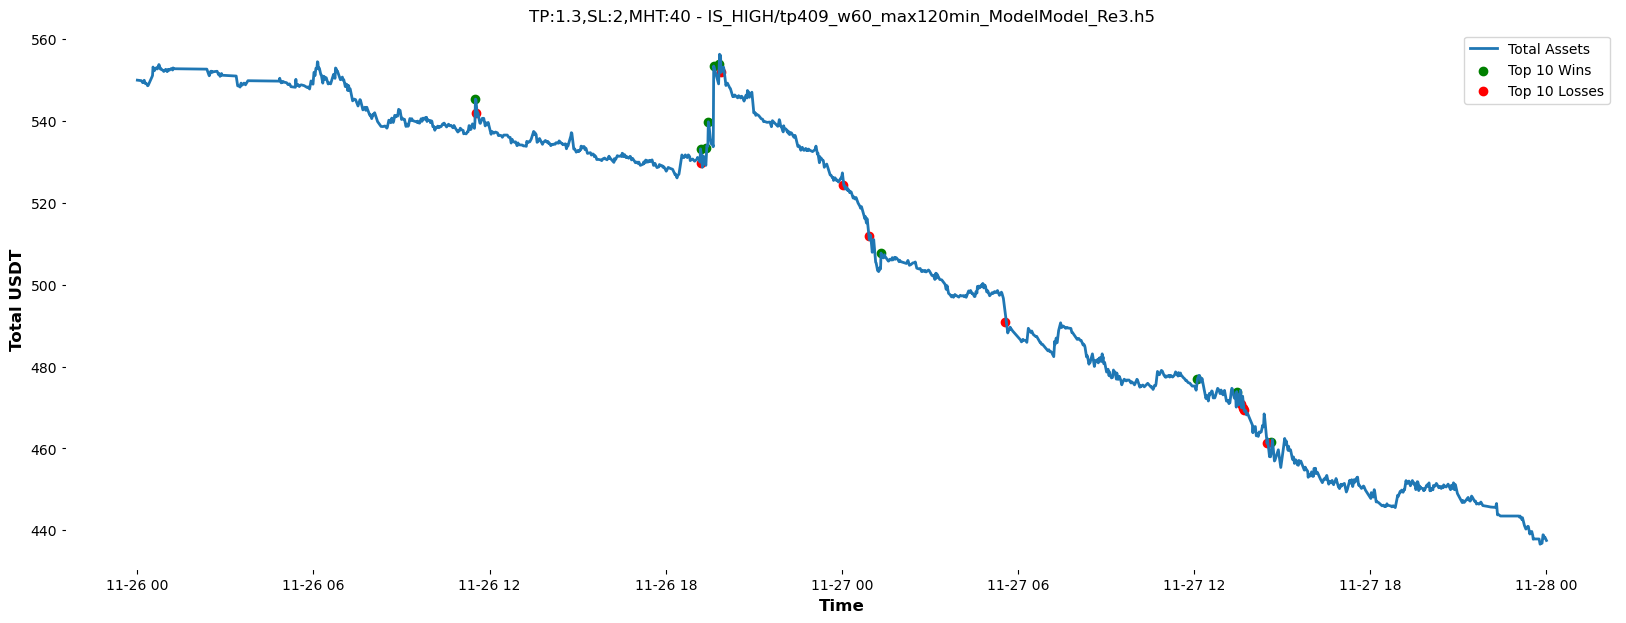

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:1.7 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 425.69 USDT
Profit: -124.31 USDT
Return on Investment (ROI): -22.60%


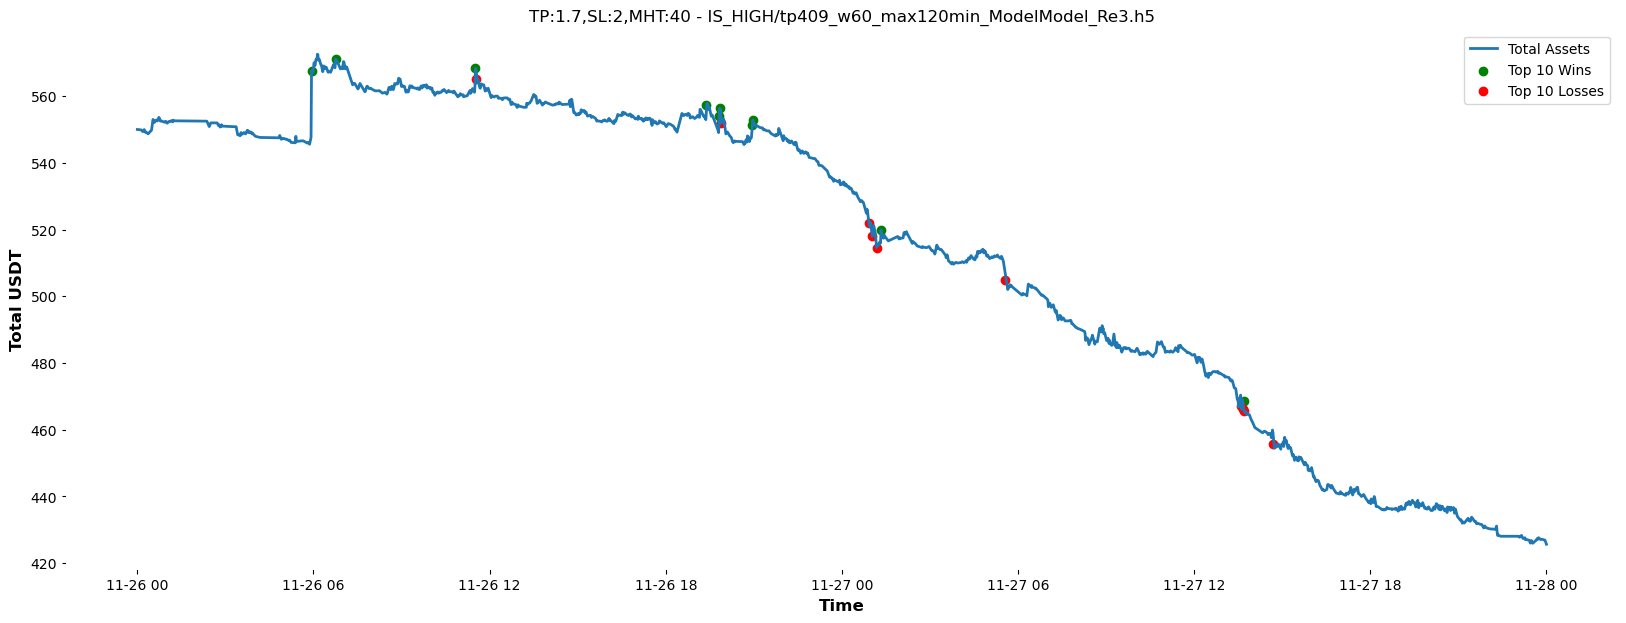

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.3 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 
Initial Investment: 550.00 USDT
Final Value: 473.70 USDT
Profit: -76.30 USDT
Return on Investment (ROI): -13.87%


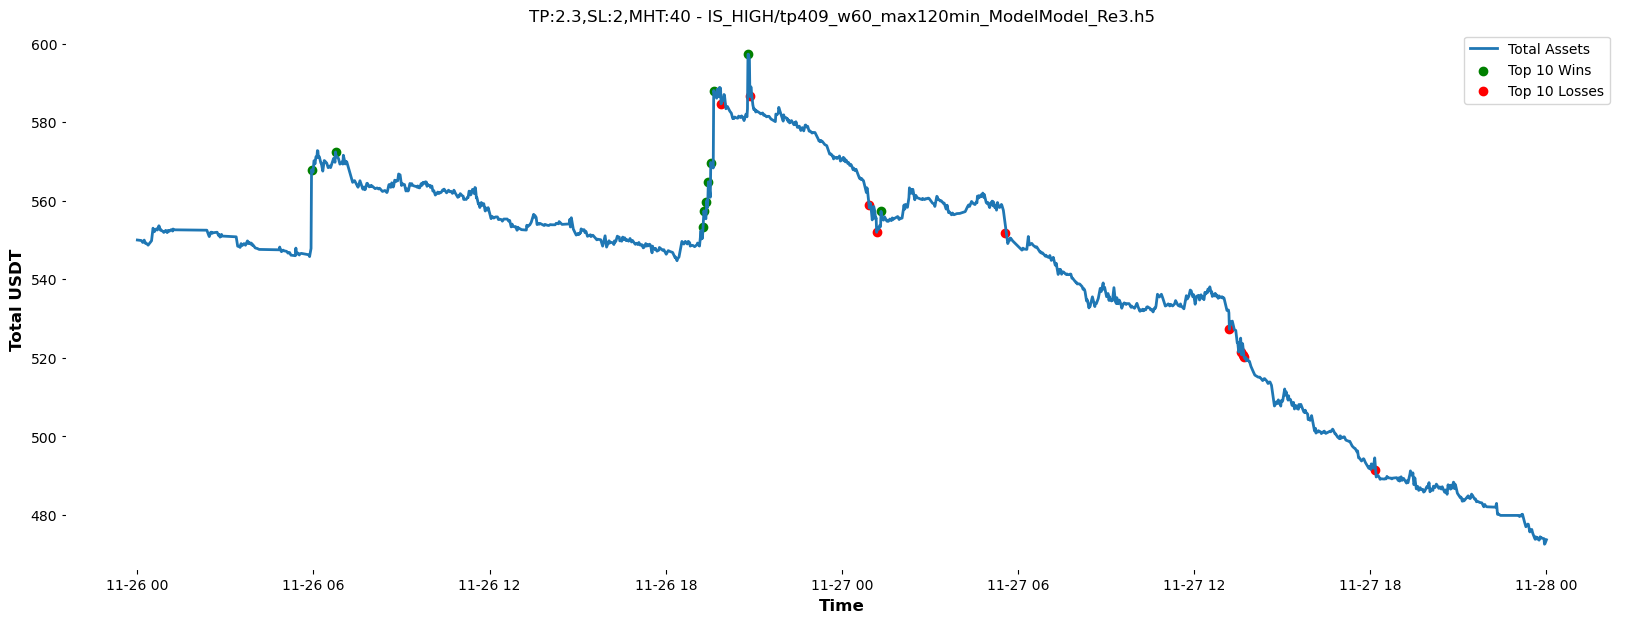

total trades 0 whith 0 win / 0 losses  
saving Test in workdir/backtest/409_60.csv
=========================== TP:2.7 , SL:2 , MHT:40 Model:/UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5   ===========================================
Testing model: /UltimeTradingBot/Data/IS_HIGH/tp409_w60_max120min_ModelModel_Re3.h5 


KeyboardInterrupt: 

In [81]:
testname="409_60"

TAKE_PROFIT_RANGE = [2.9,4,5,0.9,1.3,1.7,2.3,2.7,3,3.3]# [2.1,1,0.7,3,1.5,1.7,1.8,1.9,2.5,3.5,5]#[2.4, 1.3 , 1.9 ,2.2, 1.8,3.5  ,2.5 ,1, 1.5 , 1.6 , 1.7 ]  # Define the range of values for take profit
MAX_HOLDING_TIME_RANGE =[180,240,60,40,720,240,1440] #[80,1440,120,40,240]#[ 240,300,1440,200, 720]  # Define the range of values for max holding time
STOP_LOSS_RANGE = [2,5,3,15,1]#[ 10,3.5, 5,1,7,2.5]  # Define the range of values for stop loss


for Model_FileName in Model_lists:
    SIGNAL_DF = generate_signals_costum(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=50,w1h=8,w1d=7,
                                                btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
    for stop_loss in STOP_LOSS_RANGE:
        for max_holding_time in MAX_HOLDING_TIME_RANGE:
                for take_profit in TAKE_PROFIT_RANGE: 
                    MAX_HOLDING_TIME=max_holding_time
                    TAKE_PROFIT= take_profit
                    STOP_LOSS=  stop_loss
                    print(f"=========================== TP:{take_profit} , SL:{stop_loss} , MHT:{max_holding_time} Model:{Model_FileName}   ===========================================")
                    try:
                        model_file=Model_FileName
                        print(f"Testing model: {model_file} ")
                        backtest_model=load_model(Model_FileName)

                        ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])

                
                        USE_TRAILING_STOP_LOSS= False

                        TRAILING_DATA=pd.DataFrame()
                        PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
                        Mname=Model_FileName.split('Data/')[1]
                        metrics=get_back_test_metrics(PORTFOLIO, f"TP:{TAKE_PROFIT},SL:{STOP_LOSS},MHT:{MAX_HOLDING_TIME} - {Mname}")
                        win,loss=calculate_wins_losses(ORDER_HISTORY)

                        tt4=save_results2(TAKE_PROFIT,Model_FileName,metrics['final_value'],metrics['profit'],metrics['roi'],win,max(metrics['top_10_wins']['total_USDT']),min(metrics['top_10_losses']['total_USDT']),STOP_LOSS,MAX_HOLDING_TIME,csvname=f"workdir/backtest/{testname}.csv")
                    except Exception as e:
                        print(f"Error {Model_FileName}:    {e}")


In [ ]:
good_tests=tt4[tt4["ROI"]>=5]

In [ ]:
good_tests.sort_values("ROI")

In [ ]:
tests_history=pd.read_csv(f"workdir/backtest/test_all_models_between_{start_period.date()}--{end_period.date()}.csv",index_col=0)
print(set(tests_history.sort_values("ROI",ascending=False)[:20]["Model-FileName"]))
tests_history.sort_values("ROI",ascending=False)[:20]



MAX_HOLDING_TIME=60*24

TAKE_PROFIT= 2  
STOP_LOSS=  10 
PRECISION = -0.4

"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max120min_Model_VeryBig.h5"#-> 4,53

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_ffnn.h5"#->12.89 USDT

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_vInit.h5"#->-0.79 USDT

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_true_win_model_Re12.h5"#->9.69 USDT

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_true_win_model_Re13.h5"#-> +16.15 USDT 

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_true_win_model_Re11.h5"#-> +5.93 USDT 

#"/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_VeryDeep.h5" #->3.39

/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Model_VeryDeep.h5#->-46.92 USDT

/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Model_vInit.h5 -> -8.99%

#"/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Model_cnn1.h5" -> -29.94 USDT

"/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Model_VeryBig.h5" -> -9.73%

"/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Anti-Model_v2.h5"->-33.09 USDT

"/UltimeTradingBot/Data/IS_HIGH/tp111_w15_max5min_Model_true_win_model_Re1.h5"-> +11.16 USDT
tp111_w15_max5min_Model_minicnn.h5 xX
